# Traffic station classification for Traffic Management

The [dataset made available to us](https://www.kaggle.com/jboysen/us-traffic-2015) was compiled by the US Department  of Transportation. 

From the US Department of Transportation's perspective, we are likely concerned about the areas with high traffic volume. We want to understand which areas have high traffic volume, what causes them to have high traffic volume and if there are any things policy-wise we can do to improve traffic management for these areas.

With this in mind, we will deliver at least 5 key insights and recommendations to help the US Department of Transportation.

In terms of scoping as a data science project, it will be a classification task to classify stations into High Traffic stations and Low Traffic stations. 

- Given that the government is interested in **areas** with high traffic volume, this is likely more intuitive and relevant, compared to scoping it as a regression task to predict traffic volume.

- We will do the prediction at station level, since sensor level is too granular and we do not have sufficient samples for state level. We could potentially do the classification at county level, but many of the features such as type of sensor is more relevant to station level. Moreover, to identify county level insights, we could define county as a feature and aggregate stations by county after the prediction as well.

- Lastly, from the classification, we can identify the most important features associated with high traffic stations, which allows us to find key insights and make recommendations to the US Department of Transportation.

In terms of the approach, we will first do some preliminary exploration to understand the different features of the dataset and also do some data cleaning. Then, we will do exploratory data analysis to further understand our data through visualizations, as well as correlation analysis to remove highly correlated features. Lastly, we will build our model, identify the most important features and come up with insights for traffic planning.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
import json
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import random

RANDOM_STATE = 1
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
traffic_station_df = pd.read_csv('dot_traffic_stations_2015.txt.gz')

In [3]:
traffic_volume_df = pd.read_csv('dot_traffic_2015.txt.gz')

In [4]:
#Read US state and counties fips code, obtained from us gov website
us_states = pd.read_csv('us_states.csv')
us_counties = pd.read_csv('us_counties.csv')

In [5]:
traffic_station_df.head()

algorithm_of_vehicle_classification  \
0                                 NaN   
1                                 NaN   
2                                   G   
3                                   D   
4                                   G   

  algorithm_of_vehicle_classification_name calibration_of_weighing_system  \
0                                      NaN                            NaN   
1                                      NaN                            NaN   
2      Axle spacing with Scheme F modified                            NaN   
3            Vehicle length classification                              M   
4      Axle spacing with Scheme F modified                              0   

           calibration_of_weighing_system_name  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3  Moving average of the steering axle of 3S2s   
4                                          NaN   

   classification_system_for_vehicle_classification  concurrent_route_signing  \
0                                                13                         3   
1                                                13                         3   
2                                                15                         1   
3                                                13                         0   
4                                                14                         1   

  concurrent_signed_route_number  direction_of_travel  \
0                            091                    7   
1                            099                    5   
2                            005                    1   
3                            NaN                    5   
4                         000000                    7   

  direction_of_travel_name  fips_county_code  ...  \
0                     West                59  ...   
1                    South                77  ...   
2                    North                93  ...   
3                    South                35  ...   
4                     West                27  ...   

         sample_type_for_vehicle_classification_name second_type_of_sensor  \
0  Station not used for Heavy Vehicle Travel Info...                     N   
1  Station not used for Heavy Vehicle Travel Info...                     N   
2  Station used for Heavy Vehicle Travel Informat...                     N   
3  Station not used for Heavy Vehicle Travel Info...                   NaN   
4  Station not used for Heavy Vehicle Travel Info...                   NaN   

  shrp_site_identification station_id                station_location  \
0                      NaN     129130    LAKEVIEW AVENUE ORA91R10.091   
1                      NaN     100190    LITTLE JOHN CREEK SJ9912.526   
2                      NaN     022940            EDGEWOOD SIS5R22.999   
3                      NaN     000302  I 15  12900 South  M.P.  290.6   
4                      NaN     W01136     E. of Franklin Rd Underpass   

   type_of_sensor type_of_sensor_name  year_of_data  \
0               L     Inductance loop            15   
1               L     Inductance loop            15   
2               P       Piezoelectric            15   
3               X          Radio wave            15   
4               L     Inductance loop            15   

   year_station_discontinued year_station_established  
0                          0                       97  
1                          0                       97  
2                          0                       69  
3                          0                       11  
4                          0                       95  

[5 rows x 55 columns]

In [6]:
traffic_volume_df.head()

date  day_of_data  day_of_week  direction_of_travel  \
0  2015-04-07            7            3                    1   
1  2015-09-26           26            7                    7   
2  2015-06-16           16            3                    3   
3  2015-04-26           26            1                    5   
4  2015-05-23           23            7                    3   

  direction_of_travel_name  fips_state_code functional_classification  \
0                    North               56                        3R   
1                     West               21                        1U   
2                     East                6                        1U   
3                    South               55                        1U   
4                     East                4                        4R   

           functional_classification_name  lane_of_travel  month_of_data  ...  \
0       Rural: Principal Arterial - Other               1              4  ...   
1  Urban: Principal Arterial - Interstate               2              9  ...   
2  Urban: Principal Arterial - Interstate               0              6  ...   
3  Urban: Principal Arterial - Interstate               1              4  ...   
4                   Rural: Minor Arterial               0              5  ...   

   traffic_volume_counted_after_1500_to_1600  \
0                                         89   
1                                       1617   
2                                       4244   
3                                       1011   
4                                         83   

   traffic_volume_counted_after_1600_to_1700  \
0                                        122   
1                                       1669   
2                                       4405   
3                                        959   
4                                         61   

  traffic_volume_counted_after_1700_to_1800  \
0                                       124   
1                                      1308   
2                                      4609   
3                                       851   
4                                        55   

   traffic_volume_counted_after_1800_to_1900  \
0                                        110   
1                                       1068   
2                                       4361   
3                                        708   
4                                         35   

   traffic_volume_counted_after_1900_to_2000  \
0                                         69   
1                                        928   
2                                       3272   
3                                        559   
4                                         29   

   traffic_volume_counted_after_2000_to_2100  \
0                                         73   
1                                        885   
2                                       2243   
3                                        457   
4                                         21   

   traffic_volume_counted_after_2100_to_2200  \
0                                         28   
1                                        798   
2                                       2050   
3                                        297   
4                                         23   

   traffic_volume_counted_after_2200_to_2300  \
0                                         12   
1                                        650   
2                                       1453   
3                                        207   
4                                          9   

   traffic_volume_counted_after_2300_to_2400  year_of_data  
0                                          6            15  
1                                        613            15  
2                                        892            15  
3                                        110            15  
4                                          7            15  

[5 rows x 38 columns]

At first glance, it appears that traffic_station_df is a dataframe containing information about a station (eg. station location, type of sensors it uses, year station is established), while traffic_volume_df is a dataframe containing daily information on traffic_volume for a particular station. 

We can move forward to explore features in each dataframe in more detail.

# Preliminary exploration of features + Data cleaning

### Exploring features in traffic_volume_df

In [7]:
traffic_volume_df.columns

Index(['date', 'day_of_data', 'day_of_week', 'direction_of_travel',
       'direction_of_travel_name', 'fips_state_code',
       'functional_classification', 'functional_classification_name',
       'lane_of_travel', 'month_of_data', 'record_type', 'restrictions',
       'station_id', 'traffic_volume_counted_after_0000_to_0100',
       'traffic_volume_counted_after_0100_to_0200',
       'traffic_volume_counted_after_0200_to_0300',
       'traffic_volume_counted_after_0300_to_0400',
       'traffic_volume_counted_after_0400_to_0500',
       'traffic_volume_counted_after_0500_to_0600',
       'traffic_volume_counted_after_0600_to_0700',
       'traffic_volume_counted_after_0700_to_0800',
       'traffic_volume_counted_after_0800_to_0900',
       'traffic_volume_counted_after_0900_to_1000',
       'traffic_volume_counted_after_1000_to_1100',
       'traffic_volume_counted_after_1100_to_1200',
       'traffic_volume_counted_after_1200_to_1300',
       'traffic_volume_counted_after_1300_to_

It appears that the dataframe has a mix of date columns ('date', 'day_of_week', 'month_of_data', 'year_of_data'), traffic volume columns, as well as other features related to the road ('functional_classification', 'direction_of_travel', 'lane_of_travel').

It also has 'station_id' and 'fips_state_code' as identifiers for the station.

In [8]:
traffic_volume_df.describe()

day_of_data  day_of_week  direction_of_travel  fips_state_code  \
count  7140391.000  7140391.000          7140391.000      7140391.000   
mean        15.727        4.014                3.883           29.670   
std          8.769        1.998                2.287           16.706   
min          1.000        1.000                0.000            1.000   
25%          8.000        2.000                1.000           13.000   
50%         16.000        4.000                4.000           30.000   
75%         23.000        6.000                5.000           44.000   
max         31.000        7.000                9.000           56.000   

       lane_of_travel  month_of_data  record_type  restrictions  \
count     7140391.000    7140391.000  7140391.000         0.000   
mean            1.292          6.520        3.000           NaN   
std             1.080          3.455        0.000           NaN   
min             0.000          1.000        3.000           NaN   
25%             1.000          4.000        3.000           NaN   
50%             1.000          7.000        3.000           NaN   
75%             2.000         10.000        3.000           NaN   
max             9.000         12.000        3.000           NaN   

       traffic_volume_counted_after_0000_to_0100  \
count                                7140391.000   
mean                                     114.588   
std                                      281.849   
min                                       -1.000   
25%                                       13.000   
50%                                       42.000   
75%                                      126.000   
max                                    99999.000   

       traffic_volume_counted_after_0100_to_0200  ...  \
count                                7140391.000  ...   
mean                                      78.746  ...   
std                                      220.287  ...   
min                                       -1.000  ...   
25%                                        8.000  ...   
50%                                       27.000  ...   
75%                                       85.000  ...   
max                                    80741.000  ...   

       traffic_volume_counted_after_1500_to_1600  \
count                                7140391.000   
mean                                     749.716   
std                                     1143.318   
min                                       -1.000   
25%                                      183.000   
50%                                      438.000   
75%                                      891.000   
max                                    99999.000   

       traffic_volume_counted_after_1600_to_1700  \
count                                7140391.000   
mean                                     777.044   
std                                     1173.933   
min                                       -1.000   
25%                                      186.000   
50%                                      452.000   
75%                                      934.000   
max                                    99999.000   

       traffic_volume_counted_after_1700_to_1800  \
count                                7140391.000   
mean                                     756.554   
std                                     1172.116   
min                                       -1.000   
25%                                      174.000   
50%                                      432.000   
75%                                      907.000   
max                                    99999.000   

       traffic_volume_counted_after_1800_to_1900  \
count                                7140391.000   
mean                                     617.332   
std                                     1061.545   
min                                       -1.000   
25%                                      131.000   
50%                                      33

From the above, we can observe that record_type column only has value 3 and restrictions column only has NaN values, which aren't very meaningful. We can therefore drop these 2 columns.

Furthermore, we notice that for the traffic volume columns, the minimum value is -1, which doesn't make sense since traffic volume is a non-negative metric. Let's set these records to 0 instead.

Lastly, it seems that several of our traffic volume columns have a max value of 99,999 which is kind of weird. We shall explore a few samples for this case.

In [9]:
traffic_volume_df.drop(['record_type','restrictions'], axis = 1, inplace = True)

In [10]:
traffic_volume_columns = traffic_volume_df.iloc[:,11:35].columns.to_list()
traffic_volume_df[traffic_volume_columns] = traffic_volume_df[traffic_volume_df.iloc[:,11:35].columns.to_list()].clip(lower=0)
traffic_volume_df.describe()

day_of_data  day_of_week  direction_of_travel  fips_state_code  \
count  7140391.000  7140391.000          7140391.000      7140391.000   
mean        15.727        4.014                3.883           29.670   
std          8.769        1.998                2.287           16.706   
min          1.000        1.000                0.000            1.000   
25%          8.000        2.000                1.000           13.000   
50%         16.000        4.000                4.000           30.000   
75%         23.000        6.000                5.000           44.000   
max         31.000        7.000                9.000           56.000   

       lane_of_travel  month_of_data  \
count     7140391.000    7140391.000   
mean            1.292          6.520   
std             1.080          3.455   
min             0.000          1.000   
25%             1.000          4.000   
50%             1.000          7.000   
75%             2.000         10.000   
max             9.000         12.000   

       traffic_volume_counted_after_0000_to_0100  \
count                                7140391.000   
mean                                     114.588   
std                                      281.849   
min                                        0.000   
25%                                       13.000   
50%                                       42.000   
75%                                      126.000   
max                                    99999.000   

       traffic_volume_counted_after_0100_to_0200  \
count                                7140391.000   
mean                                      78.746   
std                                      220.287   
min                                        0.000   
25%                                        8.000   
50%                                       27.000   
75%                                       85.000   
max                                    80741.000   

       traffic_volume_counted_after_0200_to_0300  \
count                                7140391.000   
mean                                      66.225   
std                                      210.264   
min                                        0.000   
25%                                        7.000   
50%                                       21.000   
75%                                       70.000   
max                                    90017.000   

       traffic_volume_counted_after_0300_to_0400  ...  \
count                                7140391.000  ...   
mean                                      70.161  ...   
std                                      224.248  ...   
min                                        0.000  ...   
25%                                        7.000  ...   
50%                                       23.000  ...   
75%                                       75.000  ...   
max                                    90012.000  ...   

       traffic_volume_counted_after_1500_to_1600  \
count                                7140391.000   
mean                                     749.716   
std                                     1143.318   
min                                        0.000   
25%                                      183.000   
50%                                      438.000   
75%                                      891.000   
max                                    99999.000   

       traffic_volume_counted_after_1600_to_1700  \
count                                7140391.000   
mean                                     777.044   
std                                     1173.933   
min                                        0.000   
25%                                      186.000   
50%                                      452.000   
75%                                      934.000   
max                                    99999.000   

       traffic_volume_counted_after_1700_to_1800  \
count                                7140391.000   
mean                     

After applying the treatment, we can see that the minimum value for Traffic volume columns is now 0. Let's go ahead and explore samples which have 99,999 values.

In [11]:
traffic_volume_df.query('traffic_volume_counted_after_2300_to_2400 == 99999').iloc[1]

date                                                                     2015-07-13
day_of_data                                                                      13
day_of_week                                                                       2
direction_of_travel                                                               1
direction_of_travel_name                                                      North
fips_state_code                                                                  54
functional_classification                                                        1R
functional_classification_name               Rural: Principal Arterial - Interstate
lane_of_travel                                                                    2
month_of_data                                                                     7
station_id                                                                   000050
traffic_volume_counted_after_0000_to_0100                                   

In [12]:
filter_str = ''
for i in range(0, len(traffic_volume_columns)):
    if i != len(traffic_volume_columns) - 1:
        filter_str += traffic_volume_columns[i] + ' == 99999 | '
    else:
        filter_str += traffic_volume_columns[i] + ' == 99999'
    
traffic_volume_df.query(filter_str)

date  day_of_data  day_of_week  direction_of_travel  \
5126     2015-08-31           31            2                    1   
345918   2015-02-26           26            5                    3   
502567   2015-07-13           13            2                    1   
815383   2015-01-27           27            3                    3   
1110856  2015-06-29           29            2                    1   
1162143  2015-06-03            3            4                    5   
1332255  2015-06-23           23            3                    3   
1856191  2015-06-03            3            4                    5   
1981984  2015-01-27           27            3                    7   
2430562  2015-02-04            4            4                    3   
2583136  2015-02-02            2            2                    1   
2608226  2015-07-13           13            2                    1   
2793141  2015-09-18           18            6                    1   
3060235  2015-02-26           26            5                    7   
3060890  2015-07-13           13            2                    5   
3520276  2015-06-29           29            2                    1   
3870173  2015-06-23           23            3                    3   
4087633  2015-01-27           27            3                    7   
4812542  2015-02-26           26            5                    3   
5086973  2015-06-23           23            3                    7   
5658279  2015-01-27           27            3                    3   
5801572  2015-06-23           23            3                    7   
5855121  2015-07-13           13            2                    5   
6049722  2015-09-18           18            6                    1   
6119018  2015-09-18           18            6                    5   
6119155  2015-08-31           31            2                    5   
6133242  2015-06-29           29            2                    5   
6203794  2015-09-08            8            3                    3   
6297705  2015-02-04            4            4                    7   
6570691  2015-08-31           31            2                    1   
6740188  2015-09-08            8            3                    7   
6807760  2015-02-02            2            2                    1   
6995595  2015-02-02            2            2                    1   

        direction_of_travel_name  fips_state_code functional_classification  \
5126                       North               13                        3U   
345918                      East               13                        1U   
502567                     North               54                        1R   
815383                      East               13                        1U   
1110856                    North               13                        3U   
1162143                    South               13                        1U   
1332255                     East               13                        1R   
1856191                    South               13                        1U   
1981984                     West               13                        1U   
2430562                     East               13                        4U   
2583136                    North               13                        1U   
2608226                    North               54                        1R   
2793141                    North               13                        3U   
3060235                     West               13                        1U   
3060890                    South               54                        1R   
3520276                    North               13                        3U   
3870173                     East               13                        1R   
4087633                     West               13                        1U   
4812542                     East               13                        1U   
5086973                     West               13     

It appears that we have 33 records of traffic volume which have at least one 99,999 value.

Looking at the samples, it seems that traffic volume of 99,999 is most likely due to a sensor or data recording issue, since it's very unlikely that traffic volume can increase so much within 1 hour, or sustain at 99,999 over several hours.

Therefore, we will have to find an appropriate way to treat these records. To do so, we can replace the 99,999 values with the median across all the traffic volume columns for that particular record.

- This will work since there aren't any samples where 99,999 occurs more than 50% of the time across all columns. Therefore, taking the median across all columns won't return 99,999.

- Ideally, taking the median or average across just non-99999 values will be more accurate, but doing it across all columns will be much easier.

In [13]:
#Get max value to help us filter for 99999 value records
traffic_volume_df['max'] = traffic_volume_df.iloc[:,11:35].max(axis = 1)
traffic_volume_df['median'] = traffic_volume_df.iloc[:,11:35].median(axis = 1)

for i, row in traffic_volume_df.loc[traffic_volume_df['max'] == 99999].iterrows():
    traffic_volume_df.loc[i] = row.replace(99999, int(row['median']))   

In [14]:
traffic_volume_df.describe()

day_of_data  day_of_week  direction_of_travel  fips_state_code  \
count  7140391.000  7140391.000          7140391.000      7140391.000   
mean        15.727        4.014                3.883           29.670   
std          8.769        1.998                2.287           16.706   
min          1.000        1.000                0.000            1.000   
25%          8.000        2.000                1.000           13.000   
50%         16.000        4.000                4.000           30.000   
75%         23.000        6.000                5.000           44.000   
max         31.000        7.000                9.000           56.000   

       lane_of_travel  month_of_data  \
count     7140391.000    7140391.000   
mean            1.292          6.520   
std             1.080          3.455   
min             0.000          1.000   
25%             1.000          4.000   
50%             1.000          7.000   
75%             2.000         10.000   
max             9.000         12.000   

       traffic_volume_counted_after_0000_to_0100  \
count                                7140391.000   
mean                                     114.504   
std                                      266.563   
min                                        0.000   
25%                                       13.000   
50%                                       42.000   
75%                                      126.000   
max                                    74468.000   

       traffic_volume_counted_after_0100_to_0200  \
count                                7140391.000   
mean                                      78.746   
std                                      220.287   
min                                        0.000   
25%                                        8.000   
50%                                       27.000   
75%                                       85.000   
max                                    80741.000   

       traffic_volume_counted_after_0200_to_0300  \
count                                7140391.000   
mean                                      66.225   
std                                      210.264   
min                                        0.000   
25%                                        7.000   
50%                                       21.000   
75%                                       70.000   
max                                    90017.000   

       traffic_volume_counted_after_0300_to_0400  ...  \
count                                7140391.000  ...   
mean                                      70.161  ...   
std                                      224.248  ...   
min                                        0.000  ...   
25%                                        7.000  ...   
50%                                       23.000  ...   
75%                                       75.000  ...   
max                                    90012.000  ...   

       traffic_volume_counted_after_1700_to_1800  \
count                                7140391.000   
mean                                     756.498   
std                                     1169.760   
min                                        0.000   
25%                                      174.000   
50%                                      432.000   
75%                                      907.000   
max                                    90900.000   

       traffic_volume_counted_after_1800_to_1900  \
count                                7140391.000   
mean                                     617.277   
std                                     1058.936   
min                                        0.000   
25%                                      131.000   
50%                                      337.000   
75%                                      722.000   
max                                    98002.000   

       traffic_volume_counted_after_1900_to_2000  \
count                                7140391.000   
mean                     

We can see that the 99,999 values are no longer showing as the max values. 

In [15]:
traffic_volume_df.query('fips_state_code == 54 & station_id == "000050" & date == "2015-07-13" & direction_of_travel == 1 & lane_of_travel == 2').iloc[0]

date                                                                     2015-07-13
day_of_data                                                                      13
day_of_week                                                                       2
direction_of_travel                                                               1
direction_of_travel_name                                                      North
fips_state_code                                                                  54
functional_classification                                                        1R
functional_classification_name               Rural: Principal Arterial - Interstate
lane_of_travel                                                                    2
month_of_data                                                                     7
station_id                                                                   000050
traffic_volume_counted_after_0000_to_0100                                   

Moreover, for the sample with 99,999 values we had shown earlier, these values have been replaced by the median 806. Even though the median is a bit higher than if we had taken the median across only non-99999 values, it is still a reasonable traffic volume value.

Now that we've cleaned up these values, we'll drop the max and median columns, as well as sum up the various traffic volume columns so that it's easier for analysis later.

In [16]:
traffic_volume_df.drop(['max','median'], axis = 1, inplace = True)
traffic_volume_df['traffic_volume_daily'] = traffic_volume_df.iloc[:,11:35].sum(axis = 1)

Great, let's move on to exploring the different features.

In [17]:
traffic_volume_df.direction_of_travel_name.value_counts()

North                                                              2013229
South                                                              1996850
East                                                               1460887
West                                                               1447497
North-South or Northeast-Southwest combined (ATR stations only)      60344
Southeast                                                            40243
Northwest                                                            38500
East-West or Southeast-Northwest combined (ATR stations only)        31465
Northeast                                                            25833
Southwest                                                            25543
Name: direction_of_travel_name, dtype: int64

It seems that the other directions apart from North, South, East, West have relatively low number of records. We can group the other directions into 1 category so that we get a greater signal.

In [18]:
traffic_volume_df['direction_of_travel_name_clean'] =  traffic_volume_df['direction_of_travel_name'].apply(lambda x: x if x in ['North', 'South', 'East', 'West'] else 'Others')

In [19]:
traffic_volume_df['lane_of_travel'].value_counts()

1    2849316
2    1799970
0    1695513
3     527434
4     185915
5      53827
6      21265
7       6176
8        905
9         70
Name: lane_of_travel, dtype: int64

Lane of travel by itself isn't very interpretable. Recall that traffic_station_df has columns lane_of_travel and lane_of_travel_name. We can use this mapping to derive lane_of_travel_name for traffic_volume_df.

In [20]:
lanes_mapping = traffic_station_df[['lane_of_travel', 'lane_of_travel_name']].drop_duplicates()
lanes_mapping

lane_of_travel       lane_of_travel_name
0                  4               Other lanes
1                  1  Outside (rightmost) lane
2                  2               Other lanes
9                  0  Data with lanes combined
15                 3               Other lanes
43                 6               Other lanes
55                 5               Other lanes
1231               7               Other lanes
1788               8               Other lanes
2186               9               Other lanes

In [21]:
traffic_volume_df = pd.merge(traffic_volume_df, lanes_mapping, on = 'lane_of_travel', how = 'left')

From the above, we noticed that even though lane_of_travel has 10 categories, it only maps to 3 categories in lane_of_travel_name (Data with lanes combined, Outside rightmost lane, Other lanes).

Given that lanes such as lanes 2 and 3 have high number of samples as well, we can create a more granular mapping for lane_of_travel. We shall group together lane_of_travel 4 to 9 into one category, due to the low sample counts of the individual lanes.

In [22]:
traffic_volume_df['lane_of_travel_clean'] =  traffic_volume_df['lane_of_travel'].apply(lambda x: str(x) if x < 4 else 'Others')

In [23]:
traffic_volume_df.functional_classification_name.value_counts()

Urban: Principal Arterial - Interstate                       1702277
Rural: Principal Arterial - Other                            1393694
Urban: Principal Arterial - Other                            1113402
Rural: Principal Arterial - Interstate                       1005665
Urban: Principal Arterial - Other Freeways or Expressways     668350
Rural: Minor Arterial                                         487324
Rural: Major Collector                                        319181
Urban: Minor Arterial                                         315049
Urban: Collector                                               79946
Rural: Minor Collector                                         37096
Urban: Local System                                            10691
Rural: Local System                                             7716
Name: functional_classification_name, dtype: int64

Functional classification refers to the type of road the station is monitoring. It appears that there are 3 main types of roads:
1. Arterial
    - Urban: Principal Arterial - Interstate, Principal Arterial - Other, Arterial - Other Freeways or Expressways
    - Rural: Major/ Minor/ Principal Arterial - Interstate, Principal Arterial - Other
2. Collector
    - Urban: Collector
    - Rural: Major/ Minor

3. Local
    - Urban: Local 
    - Rural: Local
    
From this, we can create several new features:
- urban_road_type: 'Urban', 'Rural'
- us_road_type: 'Arterial', 'Collector', 'Local'

Let's create urban_road_type feature first since it can help us filter by Urban and Rural roads, which can be helpful. Let's create us_road_type feature later, when we explore features in traffic_station_df.

In [24]:
traffic_volume_df['urban_road_type'] = traffic_volume_df['functional_classification_name'].apply(lambda x: 'Urban' if 'Urban' in x else 'Rural')                                                     

In [25]:
#Check to see if features are created correctly
traffic_volume_df.loc[traffic_volume_df['urban_road_type'] == 'Urban']['functional_classification_name'].value_counts()

Urban: Principal Arterial - Interstate                       1702277
Urban: Principal Arterial - Other                            1113402
Urban: Principal Arterial - Other Freeways or Expressways     668350
Urban: Minor Arterial                                         315049
Urban: Collector                                               79946
Urban: Local System                                            10691
Name: functional_classification_name, dtype: int64

### Exploring features in traffic_station_df

In [26]:
traffic_station_df.columns

Index(['algorithm_of_vehicle_classification',
       'algorithm_of_vehicle_classification_name',
       'calibration_of_weighing_system', 'calibration_of_weighing_system_name',
       'classification_system_for_vehicle_classification',
       'concurrent_route_signing', 'concurrent_signed_route_number',
       'direction_of_travel', 'direction_of_travel_name', 'fips_county_code',
       'fips_state_code', 'functional_classification',
       'functional_classification_name', 'hpms_sample_identifier',
       'hpms_sample_type', 'lane_of_travel', 'lane_of_travel_name', 'latitude',
       'longitude', 'lrs_identification', 'lrs_location_point',
       'method_of_data_retrieval', 'method_of_data_retrieval_name',
       'method_of_traffic_volume_counting',
       'method_of_traffic_volume_counting_name', 'method_of_truck_weighing',
       'method_of_truck_weighing_name', 'method_of_vehicle_classification',
       'method_of_vehicle_classification_name', 'national_highway_system',
       'num

In [27]:
for col in traffic_station_df.columns:
    print(traffic_station_df[col].value_counts())

F    7100
G    5155
D    2267
0    1231
L    1082
K     548
Z     465
M     420
N     116
H      98
C      42
A      36
1      10
E       6
Name: algorithm_of_vehicle_classification, dtype: int64
Axle spacing with Scheme F                                                             7100
Axle spacing with Scheme F modified                                                    5155
Vehicle length classification                                                          2267
Axle spacing and vehicle length algorithm                                              1082
Axle spacing and weight algorithm                                                       548
Other means not specified above                                                         465
Axle spacing weight and vehicle length algorithm                                        420
Axle spacing and other input(s) not specified above                                     116
Other axle spacing algorithm                                        

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX    212
I 10                               91
SR 101                             70
US 60                              64
I 17                               54
                                 ... 
2.4 MI E RAMP FR RTE 33             1
US-45 LAND O' LAKES  SOUTH BO       1
NOME/TELLER RD NORTH OF NOME B      1
U.S. 1 TO I-77                      1
I-94 BELLIVILLE EB TOTAL            1
Name: station_location, Length: 8197, dtype: int64
L    15835
P     5755
W     1783
Q     1542
B      904
X      863
Z      440
R      328
H      212
S      201
E       66
U       53
I       43
M       26
A       24
G       17
V       12
K        6
F        4
Name: type_of_sensor, dtype: int64
Inductance loop                           15835
Piezoelectric                              5755
Microwave                                  1783
Quartz piezoelectric - NEW                 1542
Bending plate                               904
Radio wave                                  863

It appears that the dataframe has many different features, some of which may not be relevant to us (eg. algorithm of vehicle classification won't be that useful to us, since we're not interested in type of vehicle).

Let's first filter the dataframe by active stations (since we do not want to analyze stations that have been discontinued), and then select only features that may be relevant to us.

In [28]:
columns = ['fips_state_code', 'fips_county_code', 'station_id', 'type_of_sensor', 'type_of_sensor_name', \
            'second_type_of_sensor', 'station_location', 'latitude', 'longitude', \
             'functional_classification', 'functional_classification_name', 'direction_of_travel', \
            'direction_of_travel_name', 'lane_of_travel', 'lane_of_travel_name', 'method_of_data_retrieval', 'method_of_data_retrieval_name', \
            'method_of_traffic_volume_counting', 'method_of_traffic_volume_counting_name', 'number_of_lanes_in_direction_indicated', \
            'number_of_lanes_monitored_for_traffic_volume', 'primary_purpose', 'primary_purpose_name', \
            'sample_type_for_traffic_volume', 'sample_type_for_traffic_volume_name', 'national_highway_system', 'year_station_established']

traffic_station_df_clean = traffic_station_df.loc[traffic_station_df.year_station_discontinued == 0][columns]
print(len(traffic_station_df_clean))
traffic_station_df_clean.head()

27494


fips_state_code  fips_county_code station_id type_of_sensor  \
0                6                59     129130              L   
1                6                77     100190              L   
2                6                93     022940              P   
3               49                35     000302              X   
4               34                27     W01136              L   

  type_of_sensor_name second_type_of_sensor                station_location  \
0     Inductance loop                     N    LAKEVIEW AVENUE ORA91R10.091   
1     Inductance loop                     N    LITTLE JOHN CREEK SJ9912.526   
2       Piezoelectric                     N            EDGEWOOD SIS5R22.999   
3          Radio wave                   NaN  I 15  12900 South  M.P.  290.6   
4     Inductance loop                   NaN     E. of Franklin Rd Underpass   

   latitude  longitude functional_classification  ...  \
0    33.851    117.814                        2U  ...   
1    37.875    121.220                        3R  ...   
2    41.442    122.435                        1R  ...   
3    40.517    111.892                        1U  ...   
4    40.892     74.484                        1U  ...   

  method_of_traffic_volume_counting  \
0                                 3   
1                                 3   
2                                 3   
3                                 3   
4                                 2   

       method_of_traffic_volume_counting_name  \
0  Permanent automatic traffic recorder (ATR)   
1  Permanent automatic traffic recorder (ATR)   
2  Permanent automatic traffic recorder (ATR)   
3  Permanent automatic traffic recorder (ATR)   
4           Portable traffic recording device   

  number_of_lanes_in_direction_indicated  \
0                                      5   
1                                      2   
2                                      2   
3                                      5   
4                                      4   

   number_of_lanes_monitored_for_traffic_volume primary_purpose  \
0                                             5               P   
1                                             2               P   
2                                             2               P   
3                                             5               P   
4                                             4               P   

                      primary_purpose_name sample_type_for_traffic_volume  \
0  Planning or traffic statistics purposes                              T   
1  Planning or traffic statistics purposes                              T   
2  Planning or traffic statistics purposes                              T   
3  Planning or traffic statistics purposes                              T   
4  Planning or traffic statistics purposes                              T   

      sample_type_for_traffic_volume_name national_highway_system  \
0  Station used for Traffic Volume Trends                       Y   
1  Station used for Traffic Volume Trends                       Y   
2  Station used for Traffic Volume Trends                       Y   
3  Station used for Traffic Volume Trends                       Y   
4  Station used for Traffic Volume Trends                       Y   

   year_station_established  
0                        97  
1                        97  
2                        69  
3                        11  
4                        95  

[5 rows x 27 columns]

It seems that there could be a hierarchy of fips_state_code -> fips_county_code -> station_id -> sensor, in the sense that for a given fips_state_code, there may be multiple fips_county_code.

Similarly, for a given fips_county_code, there may be multiple station_id, and for a given station_id there may be multiple sensors.

In [29]:
traffic_station_df_clean.query("station_id == '000001'")

fips_state_code  fips_county_code station_id type_of_sensor  \
1140                23                31     000001              P   
1693                45                63     000001              L   
1905                34                23     000001              P   
4364                34                23     000001              P   
5784                34                23     000001              P   
5818                56                21     000001              L   
6341                34                23     000001              P   
6412                54                89     000001              P   
6684                16                55     000001              L   
7090                34                23     000001              P   
7447                16                55     000001              L   
7894                 8                95     000001              P   
8082                42                49     000001              P   
8232                56                21     000001              L   
9128                33                13     000001              L   
10019               31               157     000001              L   
10821               54                89     000001              P   
10906               33                13     000001              L   
11254               56                21     000001              L   
12062               23                31     000001              P   
12204               23                31     000001              P   
12577               23                31     000001              P   
13152               54                89     000001              P   
13630               13                89     000001              L   
13797               13                89     000001              L   
14449               34                23     000001              L   
15088               33                13     000001              L   
15144               33                13     000001              L   
16027               13                89     000001              L   
16340               42                49     000001              P   
16684               34                23     000001              L   
16784               54                89     000001              P   
17063               13                89     000001              L   
17763               13                89     000001              L   
18188               33                13     000001              L   
18381               23                31     000001              P   
18867               42                49     000001              P   
19403               22                15     000001              L   
20209               13                89     000001              L   
22136               42                49     000001              P   
22227               56                21     000001              L   
22490               22                15     000001              L   
22750               22                15     000001              L   
23179               33                13     000001              L   
23868               22                15     000001              L   
24134               34                23     000001              P   
24299                8                95     000001              P   
24366               16                55     000001              L   
24965               16                55     000001              L   
27159               13                89     000001              L   
27169               13                89     000001              L   
27487               23                31     000001              P   
27663               34                23     000001              L   

      type_of_sensor_name second_type_of_sensor  \
1140        Piezoelectric                     L   
1693      Inductance loop                     P   
1905        Piezoelectric                     L   
4364        Piezoelect

Indeed, from the above, we can see that station_id is not unique and a given station_id may have multiple records in traffic_station_df. This confirms traffic_station_df to be a sensor-level dataframe.

However, there's currently **no column in traffic_station_df acting as a unique identifier** for each record in traffic_station_df. One possibility is to concatenate fips_state_code, fips_county_code and station_id into one column. This could help us identify station level information, which is also more meaningful, compared to sensor-level information (which is likely too granular).

Yet, there's a problem with this approach. The other dataframe we're given, traffic_volume_df, only has fips_state_code and station_id columns. As such, we can only concatenate fips_state_code and station_id for our identifier to join the two dataframes. If we want to do so, we have to ensure that **for a given fips_state_code and station_id, there can only be 1 county**. If there were multiple counties, this means the the identifier isn't unique and will map to more than 1 station, causing our analysis to be inaccurate.


Therefore, the following are our outstanding tasks to join the dataframes together:

1. Concatenate fips_state_code and station_id into a single column, which will act as our unique identifier for stations

    - To ensure that it will be unique, we have to ensure that a given fips_state_code and station_id only has 1 county
    

2. With the unique identifier, we can aggregate traffic_station_df to become a station-level dataframe

3. Similar to (2), we can aggregate traffic_volume_df to become a station-level dataframe

4. We can join both the station-level dataframes to come up with a final dataframe, which will be used later for our classification task to classify stations into 2 categories (high-traffic and low-traffic).

### Data cleaning for unique identifier (by ensuring 1 county for a given fips_state_code and station_id)

Before we proceed, let's do some filtering on traffic_station_df to ensure that we only include stations we are interested in:

  - Filter by stations that have fips_state_code and station_id present in traffic_volume_df. This is because we are only interested in stations that have traffic volume recorded in traffic_volume_df.
    
  - Filter by stations with primary_purpose = 'Planning or traffic statistics purposes' and sample_type_for_traffic_volume_name = 'Station used for Traffic Volume Trends'. This is because different stations have different purposes. As traffic planners, we are only interested in stations used primarily for traffic planning.
  
     > When doing this filtering, we need to do the same for traffic_volume_df as well, since stations with other purposes may still have their traffic volume recorded in traffic_volume_df

In [30]:
#concatenate fips_state_code and station_id columns into a single column state_station
traffic_station_df_clean['state_station'] = traffic_station_df_clean['fips_state_code'].astype(str) + ' ' + traffic_station_df_clean['station_id']
traffic_volume_df['state_station'] = traffic_volume_df['fips_state_code'].astype(str) + ' ' + traffic_volume_df['station_id']

#filter traffic_station_df by stations with traffic volume recorded in traffic_volume_df
traffic_station_df_clean = traffic_station_df_clean.loc[traffic_station_df_clean['state_station'].isin(traffic_volume_df['state_station'])]        

#filter dataframes by stations with primary purpose for traffic planning
traffic_station_df_clean = traffic_station_df_clean.loc[(traffic_station_df_clean['sample_type_for_traffic_volume_name'] == 'Station used for Traffic Volume Trends') & (traffic_station_df_clean['primary_purpose_name'] == 'Planning or traffic statistics purposes')]
traffic_volume_df = traffic_volume_df.loc[traffic_volume_df['state_station'].isin(traffic_station_df_clean['state_station'])]   

print(len(traffic_station_df_clean))
traffic_station_df_clean.head()

19195


fips_state_code  fips_county_code station_id type_of_sensor  \
0                6                59     129130              L   
2                6                93     022940              P   
3               49                35     000302              X   
4               34                27     W01136              L   
5               16                27     000276              L   

  type_of_sensor_name second_type_of_sensor                station_location  \
0     Inductance loop                     N    LAKEVIEW AVENUE ORA91R10.091   
2       Piezoelectric                     N            EDGEWOOD SIS5R22.999   
3          Radio wave                   NaN  I 15  12900 South  M.P.  290.6   
4     Inductance loop                   NaN     E. of Franklin Rd Underpass   
5     Inductance loop                   NaN   I-84  300 Ft. W of Beg EB Off   

   latitude  longitude functional_classification  ...  \
0    33.851    117.814                        2U  ...   
2    41.442    122.435                        1R  ...   
3    40.517    111.892                        1U  ...   
4    40.892     74.484                        1U  ...   
5    43.599    116.559                        1U  ...   

       method_of_traffic_volume_counting_name  \
0  Permanent automatic traffic recorder (ATR)   
2  Permanent automatic traffic recorder (ATR)   
3  Permanent automatic traffic recorder (ATR)   
4           Portable traffic recording device   
5  Permanent automatic traffic recorder (ATR)   

   number_of_lanes_in_direction_indicated  \
0                                       5   
2                                       2   
3                                       5   
4                                       4   
5                                       2   

  number_of_lanes_monitored_for_traffic_volume  primary_purpose  \
0                                            5                P   
2                                            2                P   
3                                            5                P   
4                                            4                P   
5                                            2                P   

                      primary_purpose_name  sample_type_for_traffic_volume  \
0  Planning or traffic statistics purposes                               T   
2  Planning or traffic statistics purposes                               T   
3  Planning or traffic statistics purposes                               T   
4  Planning or traffic statistics purposes                               T   
5  Planning or traffic statistics purposes                               T   

      sample_type_for_traffic_volume_name  national_highway_system  \
0  Station used for Traffic Volume Trends                        Y   
2  Station used for Traffic Volume Trends                        Y   
3  Station used for Traffic Volume Trends                        Y   
4  Station used for Traffic Volume Trends                        Y   
5  Station used for Traffic Volume Trends                        Y   

  year_station_established  state_station  
0                       97       6 129130  
2                       69       6 022940  
3                       11      49 000302  
4                       95      34 W01136  
5                       13      16 000276  

[5 rows x 28 columns]

Now, we can proceed on checking for stations with same fips_state_code and station_id, but multiple counties.

In [31]:
counties_by_stn = traffic_station_df_clean.groupby(['station_id','fips_state_code'],as_index=False)['fips_county_code'].nunique().rename(columns={'fips_county_code':'no_counties'})
multiple_counties_by_stn = counties_by_stn.loc[counties_by_stn['no_counties'] > 1]
print(len(multiple_counties_by_stn))
multiple_counties_by_stn.head()

12


station_id  fips_state_code  no_counties
11       000002               22            2
263      000034                1            2
334      000044               22            2
1639     000531                2            2
1640     000531               39            2

We can observe that there are 12 records, which have the same fips_state_code and station_id, but multiple counties. We can look at a few samples to identify why this is so.

In [32]:
traffic_station_df_clean.loc[(traffic_station_df_clean['station_id'] == "000002") & (traffic_station_df['fips_state_code'] == 22)]

fips_state_code  fips_county_code station_id type_of_sensor  \
1316                22                 0     000002              L   
1950                22                 0     000002              L   
5849                22                33     000002              L   
8217                22                 0     000002              L   
8290                22                 0     000002              L   
10693               22                33     000002              L   
15315               22                33     000002              L   
19346               22                33     000002              L   
20466               22                33     000002              L   
21278               22                 0     000002              L   
24103               22                33     000002              L   
27348               22                 0     000002              L   

      type_of_sensor_name second_type_of_sensor  \
1316      Inductance loop                     R   
1950      Inductance loop                     R   
5849      Inductance loop                     R   
8217      Inductance loop                     R   
8290      Inductance loop                     R   
10693     Inductance loop                     R   
15315     Inductance loop                     R   
19346     Inductance loop                     R   
20466     Inductance loop                     R   
21278     Inductance loop                     R   
24103     Inductance loop                     R   
27348     Inductance loop                     R   

                     station_location  latitude  longitude  \
1316   1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
1950   1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
5849   1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
8217   1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
8290   1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
10693  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
15315  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
19346  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
20466  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
21278  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
24103  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   
27348  1.6 mi. N. OF I-10 @ RR O'pass    30.454     91.181   

      functional_classification  ...  \
1316                         1U  ...   
1950                         1U  ...   
5849                         7R  ...   
8217                         1U  ...   
8290                         1U  ...   
10693                        7R  ...   
15315                        7R  ...   
19346                        7R  ...   
20466                        7R  ...   
21278                        1U  ...   
24103                        7R  ...   
27348                        1U  ...   

           method_of_traffic_volume_counting_name  \
1316   Permanent automatic traffic recorder (ATR)   
1950   Permanent automatic traffic recorder (ATR)   
5849   Permanent automatic traffic recorder (ATR)   
8217   Permanent automatic traffic recorder (ATR)   
8290   Permanent automatic traffic recorder (ATR)   
10693  Permanent automatic traffic recorder (ATR)   
15315  Permanent automatic traffic recorder (ATR)   
19346  Permanent automatic traffic recorder (ATR)   
20466  Permanent automatic traffic recorder (ATR)   
21278  Permanent automatic traffic recorder (ATR)   
24103  Permanent automatic traffic recorder (ATR)   
27348  Permanent automatic traffic recorder (ATR)   

       number_of_lanes_in_direction_indicated  \
1316                                        3   
1950                                        3   
5849                                        3   
8217                                        3   
8290                                        3   
10693                                       3   
15315                                       3   
19346                 

In [33]:
traffic_station_df_clean.loc[(traffic_station_df_clean['station_id'] == "000034") & (traffic_station_df['fips_state_code'] == 1)]

fips_state_code  fips_county_code station_id type_of_sensor  \
4427                 1               101     000034              L   
7488                 1               101     000034              L   
13223                1               101     000034              L   
17168                1               101     000034              L   
19845                1               101     000034              L   
21473                1                 0     000034              L   

      type_of_sensor_name second_type_of_sensor            station_location  \
4427      Inductance loop                     N  Montgomery on Madison Ave.   
7488      Inductance loop                     N  Montgomery on Madison Ave.   
13223     Inductance loop                     N  Montgomery on Madison Ave.   
17168     Inductance loop                     N  Montgomery on Madison Ave.   
19845     Inductance loop                     N  Montgomery on Madison Ave.   
21473     Inductance loop                     N  Montgomery on Madison Ave.   

       latitude  longitude functional_classification  ...  \
4427     32.380     86.286                        3U  ...   
7488     32.380     86.286                        3U  ...   
13223    32.380     86.286                        3U  ...   
17168    32.380     86.286                        3U  ...   
19845    32.380     86.286                        3U  ...   
21473       NaN        NaN                        3U  ...   

           method_of_traffic_volume_counting_name  \
4427   Permanent automatic traffic recorder (ATR)   
7488   Permanent automatic traffic recorder (ATR)   
13223  Permanent automatic traffic recorder (ATR)   
17168  Permanent automatic traffic recorder (ATR)   
19845  Permanent automatic traffic recorder (ATR)   
21473  Permanent automatic traffic recorder (ATR)   

       number_of_lanes_in_direction_indicated  \
4427                                        2   
7488                                        2   
13223                                       3   
17168                                       3   
19845                                       3   
21473                                       3   

      number_of_lanes_monitored_for_traffic_volume  primary_purpose  \
4427                                             2                P   
7488                                             2                P   
13223                                            3                P   
17168                                            3                P   
19845                                            3                P   
21473                                            3                P   

                          primary_purpose_name  \
4427   Planning or traffic statistics purposes   
7488   Planning or traffic statistics purposes   
13223  Planning or traffic statistics purposes   
17168  Planning or traffic statistics purposes   
19845  Planning or traffic statistics purposes   
21473  Planning or traffic statistics purposes   

       sample_type_for_traffic_volume     sample_type_for_traffic_volume_name  \
4427                                T  Station used for Traffic Volume Trends   
7488                                T  Station used for Traffic Volume Trends   
13223                               T  Station used for Traffic Volume Trends   
17168                               T  Station used for Traffic Volume Trends   
19845                               T  Station used for Traffic Volume Trends   
21473                               T  Station used for Traffic Volume Trends   

       national_highway_system year_station_established  state_station  
4427                         Y                       65       1 000034  
7488                         Y                       65       1 000034  
13223                        Y                       65       1 000034  
17168                        Y                       65       1 000034  
19845                        Y      

Looking at a few samples, it seems that there might be some inconsistency in labelling the data. Even though the records have the same or very close station_location or latitude/longitude, the fips_county_code is labelled as 0. In such cases, we should probably label the fips_county_code the same as the other records.

We can check how many of the 12 records have such cases (ie. fips_county_code = 0).

In [34]:
multiple_counties_by_stn['state_station'] = multiple_counties_by_stn['fips_state_code'].astype(str) + ' ' + multiple_counties_by_stn['station_id']
multiple_counties_by_stn_zero_county = traffic_station_df_clean.loc[(traffic_station_df_clean['state_station'].isin(multiple_counties_by_stn['state_station'])) & (traffic_station_df_clean['fips_county_code'] == 0)][['fips_state_code', 'station_id', 'state_station']].drop_duplicates()
multiple_counties_by_stn_nonzero_county = multiple_counties_by_stn.loc[~multiple_counties_by_stn['state_station'].isin(multiple_counties_by_stn_zero_county['state_station'])]
print(len(multiple_counties_by_stn_zero_county))
multiple_counties_by_stn_zero_county

6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


fips_state_code station_id state_station
1274                28     381540     28 381540
1316                22     000002     22 000002
3694                39     000531     39 000531
5922                22     000044     22 000044
21473                1     000034      1 000034
23326               11     002295     11 002295

Thus, we've identified that out of the 12 records who have multiple counties for the same fips_state_code and station_id, 6 have fips_county_code = 0, while the remaining 6 have fips_county_code != 0.

Before we treat the cases with fips_county_code = 0, let's look at the remaining 6 records with fips_county_code != 0.

In [35]:
multiple_counties_by_stn_nonzero_county

station_id  fips_state_code  no_counties state_station
1639     000531                2            2      2 000531
1894     000806                2            2      2 000806
2916     023090                6            2      6 023090
2918     023120                6            2      6 023120
3524     099930                6            2      6 099930
4054     200003               44            2     44 200003

In [36]:
traffic_station_df_clean.loc[traffic_station_df_clean['state_station'] == '2 000531']

fips_state_code  fips_county_code station_id type_of_sensor  \
6485                 2                 1     000531              L   
16128                2                90     000531              L   
18581                2                90     000531              L   
19174                2                90     000531              L   
20765                2                90     000531              L   
25480                2                90     000531              L   

      type_of_sensor_name second_type_of_sensor  \
6485      Inductance loop                   NaN   
16128     Inductance loop                     N   
18581     Inductance loop                     N   
19174     Inductance loop                     N   
20765     Inductance loop                     N   
25480     Inductance loop                     N   

                     station_location  latitude  longitude  \
6485   WEST END BADGER LOOP ROAD (NB)    64.810    147.573   
16128  WEST END BADGER LOOP ROAD (SB)    64.810    147.573   
18581  WEST END BADGER LOOP ROAD (NB)    64.810    147.573   
19174  WEST END BADGER LOOP ROAD (SB)    64.810    147.573   
20765  WEST END BADGER LOOP ROAD (NB)    64.810    147.573   
25480  WEST END BADGER LOOP ROAD (NB)    64.810    147.573   

      functional_classification  ...  \
6485                         4R  ...   
16128                        4U  ...   
18581                        4U  ...   
19174                        4U  ...   
20765                        4U  ...   
25480                        4U  ...   

           method_of_traffic_volume_counting_name  \
6485   Permanent automatic traffic recorder (ATR)   
16128  Permanent automatic traffic recorder (ATR)   
18581  Permanent automatic traffic recorder (ATR)   
19174  Permanent automatic traffic recorder (ATR)   
20765  Permanent automatic traffic recorder (ATR)   
25480  Permanent automatic traffic recorder (ATR)   

       number_of_lanes_in_direction_indicated  \
6485                                        3   
16128                                       2   
18581                                       3   
19174                                       2   
20765                                       3   
25480                                       3   

      number_of_lanes_monitored_for_traffic_volume  primary_purpose  \
6485                                             3                P   
16128                                            2                P   
18581                                            3                P   
19174                                            2                P   
20765                                            3                P   
25480                                            3                P   

                          primary_purpose_name  \
6485   Planning or traffic statistics purposes   
16128  Planning or traffic statistics purposes   
18581  Planning or traffic statistics purposes   
19174  Planning or traffic statistics purposes   
20765  Planning or traffic statistics purposes   
25480  Planning or traffic statistics purposes   

       sample_type_for_traffic_volume     sample_type_for_traffic_volume_name  \
6485                                T  Station used for Traffic Volume Trends   
16128                               T  Station used for Traffic Volume Trends   
18581                               T  Station used for Traffic Volume Trends   
19174                               T  Station used for Traffic Volume Trends   
20765                               T  Station used for Traffic Volume Trends   
25480                               T  Station used for Traffic Volume Trends   

       national_highway_system year_station_established  state_station  
6485                         N                        4       2 000531  
16128                        N                        4       2 000531  
18581                        N                        4       2 000531  
19174            

In [37]:
traffic_station_df_clean.loc[traffic_station_df_clean['state_station'] == '6 023090']

fips_state_code  fips_county_code station_id type_of_sensor  \
1374                 6                89     023090              B   
11914                6                89     023090              B   
13516                6                93     023090              B   
16357                6                93     023090              B   
19920                6                93     023090              B   
21354                6                89     023090              B   
23220                6                93     023090              B   
25977                6                93     023090              B   

      type_of_sensor_name second_type_of_sensor  \
1374        Bending plate                     N   
11914       Bending plate                     N   
13516       Bending plate                     N   
16357       Bending plate                     N   
19920       Bending plate                     N   
21354       Bending plate                     N   
23220       Bending plate                     N   
25977       Bending plate                     N   

                     station_location  latitude  longitude  \
1374   .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
11914  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
13516  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
16357  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
19920  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
21354  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
23220  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   
25977  .8 MI. N/O MOUNTAIN GATE RD SH    40.717    122.330   

      functional_classification  ...  \
1374                         1R  ...   
11914                        1R  ...   
13516                        1R  ...   
16357                        1R  ...   
19920                        1R  ...   
21354                        1R  ...   
23220                        1R  ...   
25977                        1R  ...   

           method_of_traffic_volume_counting_name  \
1374   Permanent automatic traffic recorder (ATR)   
11914  Permanent automatic traffic recorder (ATR)   
13516  Permanent automatic traffic recorder (ATR)   
16357  Permanent automatic traffic recorder (ATR)   
19920  Permanent automatic traffic recorder (ATR)   
21354  Permanent automatic traffic recorder (ATR)   
23220  Permanent automatic traffic recorder (ATR)   
25977  Permanent automatic traffic recorder (ATR)   

       number_of_lanes_in_direction_indicated  \
1374                                        2   
11914                                       2   
13516                                       2   
16357                                       2   
19920                                       2   
21354                                       2   
23220                                       2   
25977                                       2   

      number_of_lanes_monitored_for_traffic_volume  primary_purpose  \
1374                                             2                P   
11914                                            2                P   
13516                                            2                P   
16357                                            2                P   
19920                                            2                P   
21354                                            2                P   
23220                                            2                P   
25977                                            2                P   

                          primary_purpose_name  \
1374   Planning or traffic statistics purposes   
11914  Planning or traffic statistics purposes   
13516  Planning or traffic statistics purposes   
16357  Planning or traffic statistics purposes   
19920  Planning or traffic statistics purposes   
21354  Planning or traffic statistics purposes   
23220  Planning or traffic statistics purposes   
25977  Planning or traffic statistic

Looking at the above samples, we can observe the same problem again: even though the records have the same station_location and latitude/longtitude, they have a different fips_county_code. 

Since the problem is not unique to records with fips_county_code = 0, we can decide on a common method to treat these 12 records:

- For a given fips_state_code and fips_county_code, we will use latitude and longitude to identify the correct fips_county_code using the API from United States Federal Communications Commission: https://geo.fcc.gov/api/census/. 

  > This will help to standardize the fips_county_code of records having the same latitude/longtitude and labelled wrongly, allowing us to get only 1 county for such records.
  
  > For the remaining records with 2 distinct fips_county_code, we will remove these records from the dataframe. This is because it is likely that they are 2 distinct stations. Given that we can't join to traffic_volume_df based on fips_county_code, it won't be fair to include these samples in our analysis. Even though we may lose some information from removing them, there is only a very small number of such records (<10), so it shouldn't affect our analysis much.

In [38]:
multiple_counties_stns = traffic_station_df_clean.loc[(traffic_station_df_clean['state_station'].isin(multiple_counties_by_stn['state_station']))][['fips_state_code', 'fips_county_code','station_id', 'state_station', 'latitude', 'longitude']].drop_duplicates()
multiple_counties_stns.head()

fips_state_code  fips_county_code station_id state_station  latitude  \
89                  6                90     023120      6 023120    40.642   
1129               44                 7     200003     44 200003    41.852   
1274               28                 0     381540     28 381540    32.501   
1316               22                 0     000002     22 000002    30.454   
1374                6                89     023090      6 023090    40.717   

      longitude  
89      122.365  
1129     71.769  
1274     88.637  
1316     91.181  
1374    122.330

In [39]:
def get_correct_county_code(row):
    #call api to get 5-digit code (first 2 digits refer to state code, last 3 digits refer to county code)
    try:
        lat = row['latitude']
        long = row['longitude']
        r = requests.get('https://geo.fcc.gov/api/census/block/find?latitude=' + str(lat) + '&longitude=-' + str(long) + '&showall=true&format=json')
        #check if the state code we get is the same as the original. If yes, return the county code. Otherwise, return ''
        if str(row['fips_state_code']) == r.json()['County']['FIPS'][0:2].strip("0"):
            return r.json()['County']['FIPS'][2:6].strip("0")
        else:
            return ''
    
    #return '' in case lat/long can't be mapped
    except:
        return ''

multiple_counties_stns['correct_county_code'] = multiple_counties_stns.apply(get_correct_county_code, axis = 1)


In [40]:
multiple_counties_stns.head(10)

fips_state_code  fips_county_code station_id state_station  latitude  \
89                  6                90     023120      6 023120    40.642   
1129               44                 7     200003     44 200003    41.852   
1274               28                 0     381540     28 381540    32.501   
1316               22                 0     000002     22 000002    30.454   
1374                6                89     023090      6 023090    40.717   
2088               22               117     000044     22 000044    30.813   
2118               39                89     000531     39 000531    39.947   
2145               44                 9     200003     44 200003    41.378   
2735                6                89     023120      6 023120    40.642   
2932               28                75     381540     28 381540    32.506   

      longitude correct_county_code  
89      122.365                  89  
1129     71.769                   7  
1274     88.637                  75  
1316     91.181                  33  
1374    122.330                  89  
2088     89.841                 117  
2118     82.463                  89  
2145     71.493                   9  
2735    122.365                  89  
2932     88.635                  75

In [41]:
multiple_counties_stns.loc[multiple_counties_stns.state_station == '6 023120']

fips_state_code  fips_county_code station_id state_station  latitude  \
89                  6                90     023120      6 023120    40.642   
2735                6                89     023120      6 023120    40.642   

      longitude correct_county_code  
89      122.365                  89  
2735    122.365                  89

Just like what we intended, the mapping to county code using an api has helped us standardize the county codes, allowing us to have only 1 county for a given fips_state_code and station_id.

In [42]:
len(multiple_counties_stns.loc[multiple_counties_stns['correct_county_code'] != ''])/len(multiple_counties_stns)

0.8888888888888888

It also seems that most of the records were able to be mapped. However, there is a small number of records where we failed to get the county code by calling the api. Let's look deeper into these samples.

In [43]:
multiple_counties_stns.loc[multiple_counties_stns['correct_county_code'] == ''].drop_duplicates()

fips_state_code  fips_county_code station_id state_station  latitude  \
7371                11                11     002295     11 002295    25.480   
21473                1                 0     000034      1 000034       NaN   
23326               11                 0     002295     11 002295    25.480   

       longitude correct_county_code  
7371      12.365                      
21473        NaN                      
23326     12.365

Looks like there might be several reasons lat long might have failed to get mapped:
- county code can't be found for that particular lat long 
- lat long is missing

Since there are only a few such cases, let's look at them one by one to determine how to treat them

In [44]:
multiple_counties_stns.loc[multiple_counties_stns.state_station == '11 002295']

fips_state_code  fips_county_code station_id state_station  latitude  \
7371                11                11     002295     11 002295    25.480   
7524                11                 1     002295     11 002295    38.817   
23326               11                 0     002295     11 002295    25.480   

       longitude correct_county_code  
7371      12.365                      
7524      77.019                   1  
23326     12.365

In [45]:
multiple_counties_stns.loc[multiple_counties_stns.state_station == '1 000034']

fips_state_code  fips_county_code station_id state_station  latitude  \
4427                 1               101     000034      1 000034    32.380   
21473                1                 0     000034      1 000034       NaN   

       longitude correct_county_code  
4427      86.286                 101  
21473        NaN

In [46]:
traffic_station_df_clean.loc[traffic_station_df_clean['state_station'] == '1 000034']

fips_state_code  fips_county_code station_id type_of_sensor  \
4427                 1               101     000034              L   
7488                 1               101     000034              L   
13223                1               101     000034              L   
17168                1               101     000034              L   
19845                1               101     000034              L   
21473                1                 0     000034              L   

      type_of_sensor_name second_type_of_sensor            station_location  \
4427      Inductance loop                     N  Montgomery on Madison Ave.   
7488      Inductance loop                     N  Montgomery on Madison Ave.   
13223     Inductance loop                     N  Montgomery on Madison Ave.   
17168     Inductance loop                     N  Montgomery on Madison Ave.   
19845     Inductance loop                     N  Montgomery on Madison Ave.   
21473     Inductance loop                     N  Montgomery on Madison Ave.   

       latitude  longitude functional_classification  ...  \
4427     32.380     86.286                        3U  ...   
7488     32.380     86.286                        3U  ...   
13223    32.380     86.286                        3U  ...   
17168    32.380     86.286                        3U  ...   
19845    32.380     86.286                        3U  ...   
21473       NaN        NaN                        3U  ...   

           method_of_traffic_volume_counting_name  \
4427   Permanent automatic traffic recorder (ATR)   
7488   Permanent automatic traffic recorder (ATR)   
13223  Permanent automatic traffic recorder (ATR)   
17168  Permanent automatic traffic recorder (ATR)   
19845  Permanent automatic traffic recorder (ATR)   
21473  Permanent automatic traffic recorder (ATR)   

       number_of_lanes_in_direction_indicated  \
4427                                        2   
7488                                        2   
13223                                       3   
17168                                       3   
19845                                       3   
21473                                       3   

      number_of_lanes_monitored_for_traffic_volume  primary_purpose  \
4427                                             2                P   
7488                                             2                P   
13223                                            3                P   
17168                                            3                P   
19845                                            3                P   
21473                                            3                P   

                          primary_purpose_name  \
4427   Planning or traffic statistics purposes   
7488   Planning or traffic statistics purposes   
13223  Planning or traffic statistics purposes   
17168  Planning or traffic statistics purposes   
19845  Planning or traffic statistics purposes   
21473  Planning or traffic statistics purposes   

       sample_type_for_traffic_volume     sample_type_for_traffic_volume_name  \
4427                                T  Station used for Traffic Volume Trends   
7488                                T  Station used for Traffic Volume Trends   
13223                               T  Station used for Traffic Volume Trends   
17168                               T  Station used for Traffic Volume Trends   
19845                               T  Station used for Traffic Volume Trends   
21473                               T  Station used for Traffic Volume Trends   

       national_highway_system year_station_established  state_station  
4427                         Y                       65       1 000034  
7488                         Y                       65       1 000034  
13223                        Y                       65       1 000034  
17168                        Y                       65       1 000034  
19845                        Y      

We shall treat the cases as follows:
- For state_station = '11 002295', we will remove these records from our analysis. This is because even though we didn't manage to map them to a county code, it's pretty apparent that there may be multiple counties for a given fips_state_code and station_id.

- For state_station = '1 000034', we will fill in fips_county_code as 101 for the record with missing lat long, since all the other records have fips_county_code = 101.

In [47]:
#Treat case for state_station = '1 000034'
multiple_counties_stns['correct_county_code'] = multiple_counties_stns.apply(lambda x: 101 if x.state_station == '1 000034' else x.correct_county_code, axis=1)

Before we drop records for state_station = '11 002295', let's get the list of other records who still have multiple counties after getting the mapping as well. These stations are likely to have multiple counties, and therefore we will have to drop them too.

In [48]:
multiple_counties_stns_to_drop = multiple_counties_stns.groupby(['state_station'], as_index = False)['correct_county_code'].nunique().query('correct_county_code >= 2')
print(len(multiple_counties_stns_to_drop))
multiple_counties_stns_to_drop

3


state_station  correct_county_code
1     11 002295                    2
3      2 000806                    2
8     44 200003                    2

Therefore, from the 12 stations we've identified previously with multiple counties, 9 of them will only have 1 county after we identified the correct county code by calling an api, while 3 still have multiple counties.

Let's proceed to drop the 3 stations from the main dataframes we are using: multiple_counties_stns, traffic_station_df_clean and traffic_volume_df.

Thereafter, we will do a join between multiple_counties_stns and traffic_station_df_clean, so that traffic_station_df_clean will use the correct county code, instead of the original one.

In [49]:
multiple_counties_stns_final = multiple_counties_stns.loc[~(multiple_counties_stns['state_station'].isin(multiple_counties_stns_to_drop['state_station']))].drop_duplicates()
traffic_station_df_final = traffic_station_df_clean.loc[~(traffic_station_df_clean['state_station'].isin(multiple_counties_stns_to_drop['state_station']))]
traffic_volume_df_final = traffic_volume_df.loc[~(traffic_volume_df['state_station'].isin(multiple_counties_stns_to_drop['state_station']))]

In [50]:
traffic_station_df_final = pd.merge(traffic_station_df_final, multiple_counties_stns_final[['state_station','latitude', 'longitude','correct_county_code']].drop_duplicates(), on = ['state_station', 'latitude', 'longitude'], how = 'left')

In [51]:
traffic_station_df_final['fips_county_code'] = traffic_station_df_final.apply(lambda x: x.correct_county_code if str(x.correct_county_code) != 'nan' else x.fips_county_code, axis=1)

Now, we can check if there are any stations with multiple counties left in the traffic station dataframe.

In [52]:
print(len(traffic_station_df_final.groupby(['station_id','fips_state_code'],as_index=False)['fips_county_code'].nunique().rename(columns={'fips_county_code':'no_counties'}).query('no_counties > 1')))

0


As we can see, there are no such cases left. This means that after the processing we've done, we've ensured that there will only be 1 county for a given fips_state_code and station_id. The implication is that state_station is now a unique identifier, which allows us to have a 1:1 mapping when we join the station dataframe to traffic volume dataframe at station level now.

Now that we have our unique identifier, we will need to aggregate the rows in our station dataframe such that it becomes station level.

- Given that there are many different feature columns, we need to decide how to aggregate these features to represent them at station level.

### Aggregating traffic_station_df by station level, and creating station level features

In [53]:
#drop columns that we no longer need
columns_to_drop = ['station_location', 'latitude', 'longitude', 'primary_purpose', 'primary_purpose_name', 'sample_type_for_traffic_volume', 'sample_type_for_traffic_volume_name', 'correct_county_code']
traffic_station_df_final.drop(columns_to_drop, axis=1, inplace = True)

In [54]:
traffic_station_df_final.columns

Index(['fips_state_code', 'fips_county_code', 'station_id', 'type_of_sensor',
       'type_of_sensor_name', 'second_type_of_sensor',
       'functional_classification', 'functional_classification_name',
       'direction_of_travel', 'direction_of_travel_name', 'lane_of_travel',
       'lane_of_travel_name', 'method_of_data_retrieval',
       'method_of_data_retrieval_name', 'method_of_traffic_volume_counting',
       'method_of_traffic_volume_counting_name',
       'number_of_lanes_in_direction_indicated',
       'number_of_lanes_monitored_for_traffic_volume',
       'national_highway_system', 'year_station_established', 'state_station'],
      dtype='object')

One of the possible features we can create is Total number of Sensors a station has.

Previously, we filtered at a station level and ensured that traffic station dataframe only contains stations that are present in the traffic volume dataframe. As a result, our traffic station dataframe only contains active stations.

However, at a sensor level, there may be **inactive sensors that do not have traffic volume recorded in the traffic volume dataframe**. If we do not remove them, the total number of sensors will be inflated and the analysis will be inaccurate.

Therefore, we can apply the following treatment to traffic_station_df_final to ensure that we only keep active sensors that have traffic volume recorded:

- In traffic_station_df_final, we only keep the record if we can find its state_station, functional_classification_name, direction_of_travel and lane_of_travel in traffic_volume_df_final.

In [55]:
traffic_vol_sensor_mapping = traffic_volume_df_final[['state_station', 'functional_classification_name', 'direction_of_travel', 'lane_of_travel']].drop_duplicates()
traffic_station_df_final = pd.merge(traffic_station_df_final, traffic_vol_sensor_mapping, on = ['state_station', 'functional_classification_name', 'direction_of_travel', 'lane_of_travel'], how = 'inner')

After dropping the inactive sensor records, we can examine the no of sensors per station.

In [56]:
traffic_station_df_final.groupby(['state_station'], as_index = False).size().describe()

size
count 5214.000
mean     3.087
std      1.891
min      1.000
25%      2.000
50%      2.000
75%      4.000
max     17.000

In [57]:
traffic_station_sensors = traffic_station_df_final.groupby(['state_station'], as_index = False).size().rename(columns = {'size': 'no_sensors'})
traffic_station_sensors.sort_values(by = 'no_sensors', ascending = False)

state_station  no_sensors
1168     18 491317          17
704      13 000307          15
506      13 000011          14
507      13 000012          14
5104      6 129000          14
...            ...         ...
2536     33 091003           1
2537     33 099008           1
2538     33 099009           1
2539     33 099011           1
2607     33 265091           1

[5214 rows x 2 columns]

In [58]:
traffic_station_df_final.query('state_station == "18 491317"')

fips_state_code fips_county_code station_id type_of_sensor  \
489                 18               97     491317              L   
2927                18               97     491317              L   
4045                18               97     491317              L   
5230                18               97     491317              L   
5433                18               97     491317              L   
7028                18               97     491317              L   
7449                18               97     491317              L   
7480                18               97     491317              L   
7631                18               97     491317              L   
7683                18               97     491317              L   
7797                18               97     491317              L   
8069                18               97     491317              L   
8682                18               97     491317              L   
9789                18               97     491317              L   
10141               18               97     491317              L   
11038               18               97     491317              L   
13906               18               97     491317              L   

      type_of_sensor_name second_type_of_sensor functional_classification  \
489       Inductance loop                     P                        1U   
2927      Inductance loop                     P                        1U   
4045      Inductance loop                     P                        1U   
5230      Inductance loop                     P                        1U   
5433      Inductance loop                     P                        1U   
7028      Inductance loop                     P                        1U   
7449      Inductance loop                     P                        1U   
7480      Inductance loop                     P                        1U   
7631      Inductance loop                     P                        1U   
7683      Inductance loop                     P                        1U   
7797      Inductance loop                     P                        1U   
8069      Inductance loop                     P                        1U   
8682      Inductance loop                     P                        1U   
9789      Inductance loop                     P                        1U   
10141     Inductance loop                     P                        1U   
11038     Inductance loop                     P                        1U   
13906     Inductance loop                     P                        1U   

               functional_classification_name  direction_of_travel  \
489    Urban: Principal Arterial - Interstate                    7   
2927   Urban: Principal Arterial - Interstate                    7   
4045   Urban: Principal Arterial - Interstate                    3   
5230   Urban: Principal Arterial - Interstate                    7   
5433   Urban: Principal Arterial - Interstate                    3   
7028   Urban: Principal Arterial - Interstate                    7   
7449   Urban: Principal Arterial - Interstate                    7   
7480   Urban: Principal Arterial - Interstate                    3   
7631   Urban: Principal Arterial - Interstate                    7   
7683   Urban: Principal Arterial - Interstate                    3   
7797   Urban: Principal Arterial - Interstate                    3   
8069   Urban: Principal Arterial - Interstate                    7   
8682   Urban: Principal Arterial - Interstate                    7   
9789   Urban: Principal Arterial - Interstate                    3   
10141  Urban: Principal Arterial - Interstate                    3   
11038  Urban: Principal Arterial - Interstate                    3   
13906  Urban: Principal Arterial - Interstate                    7   

      direction_of_travel_name  ...       lane_of_travel_name  \
489                       West  ...               O

For the station with the most number of sensors (17), there appears to be an interesting observation.

The station monitors 2 directions: West and East.

- For the 9 sensors monitoring the West, columns 'number_of_lanes_in_direction_indicated' and 'number_of_lanes_monitored_for_traffic_volume' have a value of 9.

- For the 8 sensors monitoring the East, columns 'number_of_lanes_in_direction_indicated' and 'number_of_lanes_monitored_for_traffic_volume' have a value of 8.

It seems that for these 2 columns, they might already be aggregated and contain the total number in each individual row. Assuming that each record in traffic_station_df represents 1 sensor, then it seems a bit absurd that 1 sensor can track 9 lanes.

If our hypothesis that these 2 columns are already aggregated is true, then when we are creating features for these 2 columns at station level, we shouldn't aggregate them again.

Let's check if this hypothesis is correct. In addition, we will also verify whether there is a 1-1 mapping between sensor and lane (ie. one sensor monitors one lane).

In [59]:
#For each state_station, find no of unique lanes in a direction + no of sensors in a direction
traffic_station_lanes_by_dir = traffic_station_df_final.groupby(['state_station', 'direction_of_travel_name','number_of_lanes_in_direction_indicated', 'number_of_lanes_monitored_for_traffic_volume'], as_index = False)['lane_of_travel'].nunique().rename(columns = {'lane_of_travel': 'no_of_lanes_in_direction'})
traffic_station_sensors_by_dir = traffic_station_df_final.groupby(['state_station', 'direction_of_travel_name','number_of_lanes_in_direction_indicated', 'number_of_lanes_monitored_for_traffic_volume'], as_index = False).size().rename(columns = {'size': 'no_of_sensors_in_direction'})
traffic_station_lane_sensors_by_dir = pd.merge(traffic_station_lanes_by_dir, traffic_station_sensors_by_dir, on = ['state_station', 'direction_of_travel_name', 'number_of_lanes_in_direction_indicated', 'number_of_lanes_monitored_for_traffic_volume'], how = 'inner')

#Compare no of unique lanes in a direction and no of sensors in a direction
traffic_station_lane_sensors_by_dir['is_equal_lane_and_sensor'] = traffic_station_lane_sensors_by_dir.apply(lambda x: True if x.no_of_sensors_in_direction == x.no_of_lanes_in_direction else False, axis = 1)

#Compare no of unique lanes in a direction and column number_of_lanes_in_direction_indicated
traffic_station_lane_sensors_by_dir['is_equal_lanes'] = traffic_station_lane_sensors_by_dir.apply(lambda x: True if x.no_of_lanes_in_direction == x.number_of_lanes_in_direction_indicated else False, axis = 1)

In [60]:
traffic_station_lane_sensors_by_dir['is_equal_lane_and_sensor'].value_counts()

True     9719
False      18
Name: is_equal_lane_and_sensor, dtype: int64

Interestingly, a few of the stations do not have a 1-1 mapping between sensor and lane ie. multiple sensors can monitor 1 lane.

In [61]:
traffic_station_lane_sensors_by_dir[traffic_station_lane_sensors_by_dir['is_equal_lane_and_sensor']==False]

state_station direction_of_travel_name  \
2995     21 005P71                     East   
2996     21 005P71                     West   
3033     21 036P43                    North   
3034     21 036P43                    South   
3035     21 036P56                     East   
3036     21 036P56                     West   
3049     21 046P35                     East   
3050     21 046P35                     West   
3055     21 048P18                    North   
3056     21 048P18                    South   
3111     21 098P12                    North   
3112     21 098P12                    South   
3945     28 500150                     East   
3946     28 500150                     West   
4178     30 000024                     East   
4179     30 000024                     West   
6579     42 000326                     East   
6580     42 000326                     West   

      number_of_lanes_in_direction_indicated  \
2995                                       2   
2996                                       2   
3033                                       1   
3034                                       1   
3035                                       2   
3036                                       2   
3049                                       1   
3050                                       1   
3055                                       1   
3056                                       1   
3111                                       2   
3112                                       2   
3945                                       2   
3946                                       2   
4178                                       1   
4179                                       1   
6579                                       1   
6580                                       1   

      number_of_lanes_monitored_for_traffic_volume  no_of_lanes_in_direction  \
2995                                             2                         2   
2996                                             2                         2   
3033                                             1                         1   
3034                                             1                         1   
3035                                             2                         2   
3036                                             2                         2   
3049                                             1                         1   
3050                                             1                         1   
3055                                             1                         1   
3056                                             1                         1   
3111                                             2                         2   
3112                                             2                         2   
3945                                             2                         2   
3946                                             2                         2   
4178                                             1                         1   
4179                                             1                         1   
6579                                             1                         1   
6580                                             1                         1   

      no_of_sensors_in_direction  is_equal_lane_and_sensor  is_equal_lanes  
2995                           4                     False            True  
2996                           4                     False            True  
3033                           2                     False            True  
3034                           2                     False            True  
3035                           4                     False            True  
3036                           4                     False            True  
3049                           2                     False            True  
3050                           2                     False   

Let's investigate a few samples to see why there are multiple sensors monitoring the same lane.

In [62]:
traffic_station_df_final.query('state_station == "21 005P71"')[['state_station', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name']].sort_values(by = ['direction_of_travel_name', 'lane_of_travel'])

state_station direction_of_travel_name  lane_of_travel  \
11546     21 005P71                     East               1   
11970     21 005P71                     East               1   
7585      21 005P71                     East               2   
10301     21 005P71                     East               2   
575       21 005P71                     West               1   
8411      21 005P71                     West               1   
4915      21 005P71                     West               2   
8503      21 005P71                     West               2   

                          functional_classification_name  
11546  Urban: Principal Arterial - Other Freeways or ...  
11970                  Rural: Principal Arterial - Other  
7585   Urban: Principal Arterial - Other Freeways or ...  
10301                  Rural: Principal Arterial - Other  
575    Urban: Principal Arterial - Other Freeways or ...  
8411                   Rural: Principal Arterial - Other  
4915                   Rural: Principal Arterial - Other  
8503   Urban: Principal Arterial - Other Freeways or ...

In [63]:
traffic_station_df_final.query('state_station == "21 046P35"')[['state_station', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name']].sort_values(by = ['direction_of_travel_name', 'lane_of_travel'])

state_station direction_of_travel_name  lane_of_travel  \
287       21 046P35                     East               1   
10983     21 046P35                     East               1   
10428     21 046P35                     West               1   
13503     21 046P35                     West               1   

          functional_classification_name  
287                Rural: Minor Arterial  
10983  Rural: Principal Arterial - Other  
10428  Rural: Principal Arterial - Other  
13503              Rural: Minor Arterial

When inspecting some of these samples who do not have 1-1 mapping between sensor and lane, it seems that the main difference is functional_classification_name.

It seems a bit weird that the same lane has a different functional_classification_name. Maybe the lane got upgraded from Rural to Urban (or Rural Minor Arterial to Rural Principal Arterial), but instead of updating the existing record, a new record is added to traffic_station_df.

We will come back to this later.

In [64]:
#Compare no of unique lanes in a direction and column number_of_lanes_in_direction_indicated
traffic_station_lane_sensors_by_dir['is_equal_lanes'].value_counts()

True     7360
False    2377
Name: is_equal_lanes, dtype: int64

It seems that for quite a number of records, there's a discrepancy between the number of unique lanes in a direction we computed vs the column number_of_lanes_in_direction_indicated.

Let's look at some samples where they are not equal.

In [65]:
traffic_station_lane_sensors_by_dir[traffic_station_lane_sensors_by_dir['is_equal_lanes']==False]

state_station direction_of_travel_name  \
119       1 000144                    South   
136       1 000162                    North   
137       1 000162                    South   
138       1 000163                    North   
139       1 000163                    South   
...            ...                      ...   
9727      8 105029                    South   
9730      8 105548                     East   
9731      8 105548                     West   
9732      8 105550                    North   
9733      8 105550                    South   

      number_of_lanes_in_direction_indicated  \
119                                        4   
136                                        4   
137                                        4   
138                                        4   
139                                        4   
...                                      ...   
9727                                       3   
9730                                       3   
9731                                       4   
9732                                       4   
9733                                       4   

      number_of_lanes_monitored_for_traffic_volume  no_of_lanes_in_direction  \
119                                              4                         3   
136                                              4                         5   
137                                              4                         5   
138                                              4                         3   
139                                              4                         3   
...                                            ...                       ...   
9727                                             3                         1   
9730                                             3                         1   
9731                                             4                         1   
9732                                             4                         1   
9733                                             4                         1   

      no_of_sensors_in_direction  is_equal_lane_and_sensor  is_equal_lanes  
119                            3                      True           False  
136                            5                      True           False  
137                            5                      True           False  
138                            3                      True           False  
139                            3                      True           False  
...                          ...                       ...             ...  
9727                           1                      True           False  
9730                           1                      True           False  
9731                           1                      True           False  
9732                           1                      True           False  
9733                           1                      True           False  

[2377 rows x 8 columns]

In [66]:
traffic_station_sensors_by_dir.query('state_station == "1 000162"')

state_station direction_of_travel_name  \
136      1 000162                    North   
137      1 000162                    South   

     number_of_lanes_in_direction_indicated  \
136                                       4   
137                                       4   

     number_of_lanes_monitored_for_traffic_volume  no_of_sensors_in_direction  
136                                             4                           5  
137                                             4                           5

In [67]:
traffic_station_df_final.query('state_station == "1 000162"')

fips_state_code fips_county_code station_id type_of_sensor  \
170                  1               73     000162              W   
749                  1               73     000162              W   
1106                 1               73     000162              W   
1838                 1               73     000162              W   
5677                 1               73     000162              W   
9447                 1               73     000162              W   
9657                 1               73     000162              W   
13758                1               73     000162              W   
14529                1               73     000162              W   
16030                1               73     000162              W   

      type_of_sensor_name second_type_of_sensor functional_classification  \
170             Microwave                     N                        1U   
749             Microwave                     N                        1U   
1106            Microwave                     N                        1U   
1838            Microwave                     N                        1U   
5677            Microwave                     N                        1U   
9447            Microwave                     N                        1U   
9657            Microwave                     N                        1U   
13758           Microwave                     N                        1U   
14529           Microwave                     N                        1U   
16030           Microwave                     N                        1U   

               functional_classification_name  direction_of_travel  \
170    Urban: Principal Arterial - Interstate                    5   
749    Urban: Principal Arterial - Interstate                    5   
1106   Urban: Principal Arterial - Interstate                    1   
1838   Urban: Principal Arterial - Interstate                    5   
5677   Urban: Principal Arterial - Interstate                    1   
9447   Urban: Principal Arterial - Interstate                    1   
9657   Urban: Principal Arterial - Interstate                    1   
13758  Urban: Principal Arterial - Interstate                    1   
14529  Urban: Principal Arterial - Interstate                    5   
16030  Urban: Principal Arterial - Interstate                    5   

      direction_of_travel_name  ...       lane_of_travel_name  \
170                      South  ...               Other lanes   
749                      South  ...  Outside (rightmost) lane   
1106                     North  ...               Other lanes   
1838                     South  ...               Other lanes   
5677                     North  ...  Outside (rightmost) lane   
9447                     North  ...               Other lanes   
9657                     North  ...               Other lanes   
13758                    North  ...               Other lanes   
14529                    South  ...               Other lanes   
16030                    South  ...               Other lanes   

      method_of_data_retrieval  method_of_data_retrieval_name  \
170                          2          Automated (telemetry)   
749                          2          Automated (telemetry)   
1106                         2          Automated (telemetry)   
1838                         2          Automated (telemetry)   
5677                         2          Automated (telemetry)   
9447                         2          Automated (telemetry)   
9657                         2          Automated (telemetry)   
13758                        2          Automated (telemetry)   
14529                        2          Automated (telemetry)   
16030                        2          Automated (telemetry)   

      method_of_traffic_volume_counting  \
170                                   3   
749                                   3   
1106                                  3   
1838                    

In [68]:
traffic_volume_df_final.query('state_station == "1 000162" & date == "2015-07-21"')

date  day_of_data  day_of_week  direction_of_travel  \
264      2015-07-21           21            3                    5   
236744   2015-07-21           21            3                    1   
253439   2015-07-21           21            3                    5   
1452517  2015-07-21           21            3                    1   
2753104  2015-07-21           21            3                    1   
2857438  2015-07-21           21            3                    5   
3288344  2015-07-21           21            3                    1   
3453942  2015-07-21           21            3                    1   
5908494  2015-07-21           21            3                    5   
6751239  2015-07-21           21            3                    5   

        direction_of_travel_name  fips_state_code functional_classification  \
264                        South                1                        1U   
236744                     North                1                        1U   
253439                     South                1                        1U   
1452517                    North                1                        1U   
2753104                    North                1                        1U   
2857438                    South                1                        1U   
3288344                    North                1                        1U   
3453942                    North                1                        1U   
5908494                    South                1                        1U   
6751239                    South                1                        1U   

                 functional_classification_name  lane_of_travel  \
264      Urban: Principal Arterial - Interstate               4   
236744   Urban: Principal Arterial - Interstate               5   
253439   Urban: Principal Arterial - Interstate               3   
1452517  Urban: Principal Arterial - Interstate               1   
2753104  Urban: Principal Arterial - Interstate               3   
2857438  Urban: Principal Arterial - Interstate               5   
3288344  Urban: Principal Arterial - Interstate               4   
3453942  Urban: Principal Arterial - Interstate               2   
5908494  Urban: Principal Arterial - Interstate               2   
6751239  Urban: Principal Arterial - Interstate               1   

         month_of_data  ... traffic_volume_counted_after_2100_to_2200  \
264                  7  ...                                       345   
236744               7  ...                                       817   
253439               7  ...                                       627   
1452517              7  ...                                       431   
2753104              7  ...                                       541   
2857438              7  ...                                       454   
3288344              7  ...                                       186   
3453942              7  ...                                       530   
5908494              7  ...                                       582   
6751239              7  ...                                       532   

         traffic_volume_counted_after_2200_to_2300  \
264                                            276   
236744                                         608   
253439                                         509   
1452517                                        332   
2753104                                        412   
2857438                                        353   
3288344                                        132   
3453942                                        418   
5908494                                        480   
6751239                                        454   

         traffic_volume_counted_after_2300_to_2400  year_of_data  \
264                                            195            15   
236744                                         473            15   
253439                           

In the above case, we can clearly see that there are 5 unique lanes for each direction and monitored for traffic volume (eg. lane_of_travel = 1,2,3,4,5 for direction South). This means that the columns number_of_lanes_in_direction_indicated and number_of_lanes_monitored_for_traffic_volume are not accurate, since they only have a value of 4.

Therefore, we can drop these 2 columns. Since we have the more granular columns direction_of_travel_name and lane_of_travel, we can compute the aggregate more accurately as well.

In [69]:
traffic_station_df_final.drop(columns = ['number_of_lanes_in_direction_indicated', 'number_of_lanes_monitored_for_traffic_volume'], axis=1, inplace = True)

So far, we have removed inactive sensors from our dataframe and dropped 2 inaccurate feature columns. 

However, in the process, we also identified that there are some samples where there's no 1-1 mapping between sensor and lane (multiple sensors can track 1 lane). Moreover, it seems that many of these samples are different only in functional_classification_name. Since this affects data quality and functional_classification_name is one potential feature we will engineer later, let's go back to explore that now.

In [70]:
func_class_2cat_df = traffic_station_df_final.groupby(['state_station'], as_index = False)['functional_classification_name'].nunique().query('functional_classification_name > 1').rename(columns={'functional_classification_name':'no_of_categories_for_functional_classification'})
func_class_2cat_df

state_station  no_of_categories_for_functional_classification
1155     18 450404                                               2
1177     18 640406                                               2
1195     18 840105                                               2
1507     21 005P71                                               2
1526     21 036P43                                               2
1527     21 036P56                                               2
1534     21 046P35                                               2
1537     21 048P18                                               2
1565     21 098P12                                               2
1844     25 012534                                               2
2073     28 500150                                               2
2273     30 000024                                               2
3153     39 000531                                               2
3627     42 000326                                               2

Just in case, let's check if traffic_volume_df contains stations with multiple functional classification names as well.

In [71]:
func_class_2cat_df_vol = traffic_volume_df_final.groupby(['state_station'], as_index = False)['functional_classification_name'].nunique().query('functional_classification_name > 1').rename(columns={'functional_classification_name':'no_of_categories_for_functional_classification'})
func_class_2cat_df_vol

state_station  no_of_categories_for_functional_classification
1155     18 450404                                               2
1177     18 640406                                               2
1195     18 840105                                               2
1357      2 000513                                               2
1508     21 005P71                                               2
1527     21 036P43                                               2
1528     21 036P56                                               2
1535     21 046P35                                               2
1538     21 048P18                                               2
1566     21 098P12                                               2
1845     25 012534                                               2
2074     28 500150                                               2
2274     30 000024                                               2
3154     39 000531                                               2
3628     42 000326                                               2
4206      5 260059                                               2
4470     54 000014                                               2
4471     54 000015                                               2

Seems that traffic volume dataframe have a few more samples experiencing such a case, compared to traffic station dataframe.

In [72]:
func_class_2cat_df_vol = func_class_2cat_df_vol.loc[~func_class_2cat_df_vol['state_station'].isin(func_class_2cat_df['state_station'])]
func_class_2cat_df_vol

state_station  no_of_categories_for_functional_classification
1357      2 000513                                               2
4206      5 260059                                               2
4470     54 000014                                               2
4471     54 000015                                               2

In [73]:
traffic_station_df_final.loc[traffic_station_df_final['state_station'].isin(func_class_2cat_df_vol['state_station'])].sort_values(by = ['state_station'])

fips_state_code fips_county_code station_id type_of_sensor  \
7470                 2              261     000513              L   
10509                2              261     000513              L   
6488                 5               51     260059              P   
11147                5               51     260059              P   
11807                5               51     260059              P   
12092                5               51     260059              P   
4115                54               41     000014              P   
4595                54               41     000014              P   
6150                54               41     000014              P   
6461                54               41     000014              P   
3886                54               53     000015              P   
6566                54               53     000015              P   

      type_of_sensor_name second_type_of_sensor functional_classification  \
7470      Inductance loop                     N                        1R   
10509     Inductance loop                     N                        1R   
6488        Piezoelectric                     P                        2U   
11147       Piezoelectric                     P                        2U   
11807       Piezoelectric                     P                        2U   
12092       Piezoelectric                     P                        2U   
4115        Piezoelectric                     L                        3U   
4595        Piezoelectric                     L                        3U   
6150        Piezoelectric                     L                        3U   
6461        Piezoelectric                     L                        3U   
3886        Piezoelectric                     L                        6R   
6566        Piezoelectric                     L                        6R   

                          functional_classification_name  direction_of_travel  \
7470              Rural: Principal Arterial - Interstate                    1   
10509             Rural: Principal Arterial - Interstate                    5   
6488   Urban: Principal Arterial - Other Freeways or ...                    3   
11147  Urban: Principal Arterial - Other Freeways or ...                    7   
11807  Urban: Principal Arterial - Other Freeways or ...                    7   
12092  Urban: Principal Arterial - Other Freeways or ...                    3   
4115                   Urban: Principal Arterial - Other                    7   
4595                   Urban: Principal Arterial - Other                    3   
6150                   Urban: Principal Arterial - Other                    7   
6461                   Urban: Principal Arterial - Other                    3   
3886                              Rural: Minor Collector                    7   
6566                              Rural: Minor Collector                    3   

      direction_of_travel_name  lane_of_travel       lane_of_travel_name  \
7470                     North               1  Outside (rightmost) lane   
10509                    South               1  Outside (rightmost) lane   
6488                      East               1  Outside (rightmost) lane   
11147                     West               2               Other lanes   
11807                     West               1  Outside (rightmost) lane   
12092                     East               2               Other lanes   
4115                      West               2               Other lanes   
4595                      East               1  Outside (rightmost) lane   
6150                      West               1  Outside (rightmost) lane   
6461                      East               2               Other lanes   
3886                      West               1  Outside (rightmost) lane   
6566                      East               1  Outside (rightmost) lane   

       method_of_data_retrieval method_of_data_retrieval_name  \

For the additional 4 cases in traffic volume dataframe, we can simply assign the functional classification name in traffic station dataframe to standardise it. 

For the remaining cases present in both dataframes, let's explore a few samples.

In [74]:
traffic_station_df_final.query('state_station == "18 450404"')

fips_state_code fips_county_code station_id type_of_sensor  \
2763                18               89     450404              L   
5410                18               89     450404              L   
5432                18               89     450404              L   
6710                18               89     450404              L   
10478               18               89     450404              L   
10825               18               89     450404              L   
12398               18               89     450404              L   
12646               18               89     450404              L   

      type_of_sensor_name second_type_of_sensor functional_classification  \
2763      Inductance loop                     P                        3R   
5410      Inductance loop                     P                        3U   
5432      Inductance loop                     P                        3U   
6710      Inductance loop                     P                        3U   
10478     Inductance loop                     P                        3R   
10825     Inductance loop                     P                        3R   
12398     Inductance loop                     P                        3R   
12646     Inductance loop                     P                        3U   

          functional_classification_name  direction_of_travel  \
2763   Rural: Principal Arterial - Other                    5   
5410   Urban: Principal Arterial - Other                    1   
5432   Urban: Principal Arterial - Other                    1   
6710   Urban: Principal Arterial - Other                    5   
10478  Rural: Principal Arterial - Other                    5   
10825  Rural: Principal Arterial - Other                    1   
12398  Rural: Principal Arterial - Other                    1   
12646  Urban: Principal Arterial - Other                    5   

      direction_of_travel_name  lane_of_travel       lane_of_travel_name  \
2763                     South               2               Other lanes   
5410                     North               1  Outside (rightmost) lane   
5432                     North               2               Other lanes   
6710                     South               1  Outside (rightmost) lane   
10478                    South               1  Outside (rightmost) lane   
10825                    North               2               Other lanes   
12398                    North               1  Outside (rightmost) lane   
12646                    South               2               Other lanes   

       method_of_data_retrieval method_of_data_retrieval_name  \
2763                          2         Automated (telemetry)   
5410                          2         Automated (telemetry)   
5432                          2         Automated (telemetry)   
6710                          2         Automated (telemetry)   
10478                         2         Automated (telemetry)   
10825                         2         Automated (telemetry)   
12398                         2         Automated (telemetry)   
12646                         2         Automated (telemetry)   

       method_of_traffic_volume_counting  \
2763                                   3   
5410                                   3   
5432                                   3   
6710                                   3   
10478                                  3   
10825                                  3   
12398                                  3   
12646                                  3   

           method_of_traffic_volume_counting_name national_highway_system  \
2763   Permanent automatic traffic recorder (ATR)                       Y   
5410   Permanent automatic traffic recorder (ATR)                       Y   
5432   Permanent automatic traffic recorder (ATR)                       Y   
6710   Permanent automatic traffic recorder (ATR)                       Y   
10478  Permanent automatic traffic recorder (ATR)   

As mentioned earlier, it's pretty weird that the same lane in the same direction has the same information in all columns, except different functional_classification_name.

Let's take a look at the traffic volume dataframe to see if we can identify more information.

In [75]:
traffic_volume_df_final.query('state_station == "18 450404" & date in ("2015-04-01", "2015-04-29")')[['date','direction_of_travel_name', 'lane_of_travel','functional_classification_name','traffic_volume_daily']].sort_values(by= ['date','direction_of_travel_name', 'traffic_volume_daily'])

date direction_of_travel_name  lane_of_travel  \
1115823  2015-04-01                    North               2   
6458743  2015-04-01                    North               2   
1609081  2015-04-01                    North               1   
6352988  2015-04-01                    North               1   
4651530  2015-04-01                    South               2   
5669290  2015-04-01                    South               2   
4221874  2015-04-01                    South               1   
4326187  2015-04-01                    South               1   
4395374  2015-04-29                    North               2   
5189195  2015-04-29                    North               2   
2739965  2015-04-29                    North               1   
5484613  2015-04-29                    North               1   
3155533  2015-04-29                    South               2   
6911080  2015-04-29                    South               2   
689425   2015-04-29                    South               1   
4476778  2015-04-29                    South               1   

            functional_classification_name  traffic_volume_daily  
1115823  Urban: Principal Arterial - Other                  2559  
6458743  Rural: Principal Arterial - Other                  2559  
1609081  Rural: Principal Arterial - Other                  4895  
6352988  Urban: Principal Arterial - Other                  4895  
4651530  Rural: Principal Arterial - Other                  2991  
5669290  Urban: Principal Arterial - Other                  2991  
4221874  Urban: Principal Arterial - Other                  4362  
4326187  Rural: Principal Arterial - Other                  4362  
4395374  Rural: Principal Arterial - Other                  2715  
5189195  Urban: Principal Arterial - Other                  2715  
2739965  Rural: Principal Arterial - Other                  4913  
5484613  Urban: Principal Arterial - Other                  4913  
3155533  Urban: Principal Arterial - Other                  3093  
6911080  Rural: Principal Arterial - Other                  3093  
689425   Urban: Principal Arterial - Other                  4406  
4476778  Rural: Principal Arterial - Other                  4406

For a given direction and lane, we can see that the daily traffic_volume is exactly the same, even though the functional_classification_name is different. Let's look at a few more samples to get more intuition on what's happening.

In [76]:
traffic_volume_df_final.query('state_station == "21 005P71" & date in ("2015-01-31", "2015-02-01", "2015-02-28", "2015-03-01")')[['date','direction_of_travel_name', 'lane_of_travel','functional_classification_name','traffic_volume_daily']].sort_values(by= ['date','direction_of_travel_name', 'traffic_volume_daily'])

date direction_of_travel_name  lane_of_travel  \
3865885  2015-01-31                     East               2   
5255483  2015-01-31                     East               1   
4742197  2015-01-31                     West               2   
1363025  2015-01-31                     West               1   
718587   2015-02-01                     East               2   
4781337  2015-02-01                     East               1   
4162980  2015-02-01                     West               2   
4643174  2015-02-01                     West               1   
2470856  2015-02-28                     East               2   
3161083  2015-02-28                     East               1   
37308    2015-02-28                     West               2   
4271500  2015-02-28                     West               1   
6497454  2015-03-01                     East               2   
5388048  2015-03-01                     East               1   
3246742  2015-03-01                     West               2   
5033236  2015-03-01                     West               1   

                            functional_classification_name  \
3865885  Urban: Principal Arterial - Other Freeways or ...   
5255483  Urban: Principal Arterial - Other Freeways or ...   
4742197  Urban: Principal Arterial - Other Freeways or ...   
1363025  Urban: Principal Arterial - Other Freeways or ...   
718587                   Rural: Principal Arterial - Other   
4781337                  Rural: Principal Arterial - Other   
4162980                  Rural: Principal Arterial - Other   
4643174                  Rural: Principal Arterial - Other   
2470856                  Rural: Principal Arterial - Other   
3161083                  Rural: Principal Arterial - Other   
37308                    Rural: Principal Arterial - Other   
4271500                  Rural: Principal Arterial - Other   
6497454  Urban: Principal Arterial - Other Freeways or ...   
5388048  Urban: Principal Arterial - Other Freeways or ...   
3246742  Urban: Principal Arterial - Other Freeways or ...   
5033236  Urban: Principal Arterial - Other Freeways or ...   

         traffic_volume_daily  
3865885                  1030  
5255483                  3637  
4742197                  1144  
1363025                  3482  
718587                    624  
4781337                  2182  
4162980                   673  
4643174                  2221  
2470856                  1292  
3161083                  4056  
37308                    1380  
4271500                  3912  
6497454                   805  
5388048                  2686  
3246742                   890  
5033236                  2782

In [77]:
#print min and max dates for Urban road, as well as Rural road
print(('Urban', traffic_volume_df_final.query('state_station == "21 005P71" & functional_classification == "2U"')['date'].min(), \
      traffic_volume_df_final.query('state_station == "21 005P71" & functional_classification == "2U"')['date'].max()), \
      ('Rural', traffic_volume_df_final.query('state_station == "21 005P71" & functional_classification == "3R"')['date'].min(), \
      traffic_volume_df_final.query('state_station == "21 005P71" & functional_classification == "3R"')['date'].max()))

('Urban', '2015-01-01', '2015-12-31') ('Rural', '2015-02-01', '2015-02-28')


For state_station 21 005P71, it seems that there might be a different pattern. Instead of having identical traffic volume in overlapping time periods, it appears that there are no overlapping time periods in this case.

Records under Urban road span from 1 Jan 2015 to 31 Jan 2015, as well as 1 Mar 2015 to 31 Dec 2015.

On the other hand, records under Rural road span from 1 Feb 2015 to 28 Feb 2015.

Therefore, both records are supplementary to each other. Together, they represent an entire year's record of traffic volume for the particular direction and lane.

We can check this for all the other samples.

In [78]:
#Create urban_road_type feature, like we did for traffic_volume_df, to make it easier to filter
traffic_station_df_final['urban_road_type'] = traffic_station_df_final['functional_classification_name'].apply(lambda x: 'Urban' if 'Urban' in x else 'Rural')

#Print min and max dates for each state station by road type
for state_station in func_class_2cat_df.state_station.to_list():
    if state_station == '21 046P35':
        print(state_station, ('Rural Principal Arterial', traffic_volume_df_final.query('state_station == "' + state_station + '" & functional_classification == "4R"')['date'].min(), \
              traffic_volume_df_final.query('state_station == "' + state_station + '" & functional_classification == "4R"')['date'].max()), \
              ('Rural Minor Arterial', traffic_volume_df_final.query('state_station == "' + state_station + '" & functional_classification == "3R"')['date'].min(), \
              traffic_volume_df_final.query('state_station == "' + state_station + '" & functional_classification == "3R"')['date'].max()))
    else:
        print(state_station, ('Urban', traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Urban"')['date'].min(), \
              traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Urban"')['date'].max()), \
              ('Rural', traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Rural"')['date'].min(), \
              traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Rural"')['date'].max()))

18 450404 ('Urban', '2015-04-01', '2015-04-29') ('Rural', '2015-01-01', '2015-04-30')
18 640406 ('Urban', '2015-04-01', '2015-04-30') ('Rural', '2015-04-01', '2015-04-30')
18 840105 ('Urban', '2015-04-01', '2015-04-30') ('Rural', '2015-01-01', '2015-04-30')
21 005P71 ('Urban', '2015-01-01', '2015-12-31') ('Rural', '2015-02-01', '2015-02-28')
21 036P43 ('Urban', '2015-01-01', '2015-12-31') ('Rural', '2015-02-01', '2015-02-28')
21 036P56 ('Urban', '2015-01-01', '2015-12-31') ('Rural', '2015-02-01', '2015-02-28')
21 046P35 ('Rural Principal Arterial', '2015-01-01', '2015-12-14') ('Rural Minor Arterial', '2015-02-01', '2015-02-28')
21 048P18 ('Urban', '2015-01-01', '2015-12-31') ('Rural', '2015-02-01', '2015-02-28')
21 098P12 ('Urban', '2015-03-01', '2015-12-31') ('Rural', '2015-02-12', '2015-02-28')
25 012534 ('Urban', '2015-12-03', '2015-12-20') ('Rural', '2015-05-13', '2015-09-30')
28 500150 ('Urban', '2015-02-01', '2015-12-31') ('Rural', '2015-01-01', '2015-01-31')
30 000024 ('Urban', 

Apart from the first 3 samples, it seems that generally, Rural Road records tend to have an earlier max date, compared to Urban Road/Rural Principal Arterial Road records. Moreover, for several samples, the min date for the Urban Road/Rural Principal Arterial Road records is one day after the max date for Rural Road.

For the samples that have overlapping time periods, let's verify if they are identical records.

In [79]:
def compare_df_similarity(df1, df2):
    common_dates = set(df1['date'].to_list()).intersection(set(df2['date'].to_list()))
    if len(common_dates) > 0:
        df1 = df1.loc[df1['date'].isin(common_dates)]
        df2 = df2.loc[df2['date'].isin(common_dates)]
        common_df = pd.merge(df1, df2, on=['date', 'direction_of_travel_name', 'lane_of_travel', 'traffic_volume_daily'], how = 'inner')
        return str(len(common_df)/min(len(df1),len(df2)) * 100) + '% similarity between Urban/Rural Principal Arterial and Rural road data for commmon dates'
    else:
        return "no common dates"

for state_station in func_class_2cat_df.state_station.to_list():
    if state_station == '21 046P35':
        df1 = traffic_volume_df_final.query('state_station == "' + state_station + '" & functional_classification == "4R"')[['date', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name', 'traffic_volume_daily']]
        df2 = traffic_volume_df_final.query('state_station == "' + state_station + '" & functional_classification == "3R"')[['date', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name', 'traffic_volume_daily']]
        print('State station ' + str(state_station) + ' has', compare_df_similarity(df1,df2))
    else:
        df1 = traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Urban"')[['date', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name', 'traffic_volume_daily']]
        df2 = traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Rural"')[['date', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name', 'traffic_volume_daily']]
        print('State station ' + str(state_station) + ' has', compare_df_similarity(df1,df2))

State station 18 450404 has 100.0% similarity between Urban/Rural Principal Arterial and Rural road data for commmon dates
State station 18 640406 has 100.0% similarity between Urban/Rural Principal Arterial and Rural road data for commmon dates
State station 18 840105 has 100.0% similarity between Urban/Rural Principal Arterial and Rural road data for commmon dates
State station 21 005P71 has no common dates
State station 21 036P43 has no common dates
State station 21 036P56 has no common dates
State station 21 046P35 has no common dates
State station 21 048P18 has no common dates
State station 21 098P12 has no common dates
State station 25 012534 has no common dates
State station 28 500150 has no common dates
State station 30 000024 has no common dates
State station 39 000531 has 100.0% similarity between Urban/Rural Principal Arterial and Rural road data for commmon dates
State station 42 000326 has no common dates


**From the above, we have ascertained 2 things:**

1. Whenever Urban/Rural Principal Arterial Road data and Rural Road data have overlapping time periods, the data is totally identical.

2. If both data do not have overlapping time periods, they supplement each other to give a more complete record of a lane's traffic volume in a year.


**There may be several reasons why this is happening:**

- The road got upgraded, resulting in the change from Rural Road to Urban/Rural Principal Arterial Road tagging at a later time period.

  > In this case, the sensor might be the same (so we only have 1 sensor for a lane), just that instead of updating functional classification name for the record to Urban/Rural Principal Arterial, a new record is added with a different functional classification name.
  
  > This might explain the case where there are no overlapping time periods.
  
- A new sensor was put in place, while the old sensor was slowly deprecated (so we have a case of multiple sensors for 1 lane). This might explain why there might be identical data in overlapping time periods.

**In any case, in terms of how we should treat the data,**

- We should definitely remove the identical data in overlapping time periods. This is causing double counting of traffic volume.

- Since there's either a case of identical data in overlapping time periods or no overlapping time periods at all, it is highly likely that the sensor is the same or there's a replacement of the sensor. As a result, we can just regard all the traffic volume to be recorded under 1 sensor instead of 2.

  > This is because assuming there's a replacement, the new sensor is still monitoring the same direction and technically continues the function of the previous sensor. The data from both supplement each other, and is equivalent to data recorded from 1 fully functioning sensor in a year. Therefore, it's fair to still regard this as 1 sensor.
  
  > With this treatment, we also enable a 1:1 mapping between sensor and lane ie. 1 sensor monitors only 1 lane.

- Currently the same lane has 2 functional classification names. To standardise this and ensure that the lane only has 1 functional classification name, we will take the functional classification name which has the longest time period (this is probably more representative than taking the latest functional classification name).

  > For instance, for state station 18 450404, the Rural Road data has traffic volume data from 1 Jan to 30 Apr, compared to 1 Apr to 29 Apr for Urban Road data. Therefore, we treat this as Rural since it has a longer time period.

In [80]:
def assign_urban_road_type(df1, df2):
    if len(df1) >= len(df2):
        return "Urban"
    else:
        return "Rural"
        
traffic_volume_df_final.drop(['functional_classification'], axis=1, inplace = True)

#based on length of type period, assign urban_road_type to each state_station
urban_road_type_list = []
func_class_2cat_df_excl_two = func_class_2cat_df.query('state_station not in ("21 046P35", "21 005P71")')

for state_station in func_class_2cat_df_excl_two.state_station.to_list():
    df1 = traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Urban"')[['date','direction_of_travel_name', 'lane_of_travel', 'traffic_volume_daily']]
    df2 = traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Rural"')[['date','direction_of_travel_name', 'lane_of_travel', 'traffic_volume_daily']]
    urban_road_type_list.append(assign_urban_road_type(df1, df2))

urban_road_type_2cat = pd.concat([func_class_2cat_df_excl_two.reset_index(drop = True),pd.Series(urban_road_type_list)],axis = 1).rename(columns = {0: 'urban_road_type'})
rural_state_station_list = urban_road_type_2cat.query('urban_road_type == "Rural"')['state_station'].to_list()
urban_state_station_list = urban_road_type_2cat.query('urban_road_type == "Urban"')['state_station'].to_list()

#Create functional classification mapping (using a dict to map values is faster)
func_classification_urban_map_from = traffic_station_df_final.loc[(traffic_station_df_final['state_station'].isin(urban_state_station_list)) & (traffic_station_df_final["functional_classification_name"].str.contains('Rural'))][['state_station', 'functional_classification_name']].drop_duplicates().rename(columns = {'functional_classification_name': 'map_from'})
func_classification_urban_map_to = traffic_station_df_final.loc[(traffic_station_df_final['state_station'].isin(urban_state_station_list)) & (traffic_station_df_final["functional_classification_name"].str.contains('Urban'))][['state_station', 'functional_classification_name']].drop_duplicates().rename(columns = {'functional_classification_name': 'map_to'})
func_classification_urban_mapping = pd.merge(func_classification_urban_map_from, func_classification_urban_map_to, on = 'state_station', how = 'inner')[['map_from', 'map_to']].set_index('map_from')['map_to'].to_dict()
func_classification_rural_map_from = traffic_station_df_final.loc[(traffic_station_df_final['state_station'].isin(rural_state_station_list)) & (traffic_station_df_final["functional_classification_name"].str.contains('Urban'))][['state_station', 'functional_classification_name']].drop_duplicates().rename(columns = {'functional_classification_name': 'map_from'})
func_classification_rural_map_to = traffic_station_df_final.loc[(traffic_station_df_final['state_station'].isin(rural_state_station_list)) & (traffic_station_df_final["functional_classification_name"].str.contains('Rural'))][['state_station', 'functional_classification_name']].drop_duplicates().rename(columns = {'functional_classification_name': 'map_to'})
func_classification_rural_mapping = pd.merge(func_classification_rural_map_from, func_classification_rural_map_to, on = 'state_station', how = 'inner')[['map_from', 'map_to']].set_index('map_from')['map_to'].to_dict()

#Update urban_road_type and functional_classification_name in traffic volume df
for state_station in urban_state_station_list:
    traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == state_station, 'urban_road_type'] = 'Urban'
    traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == state_station,'functional_classification_name'] = traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == state_station, 'functional_classification_name'].replace(func_classification_urban_mapping)
for state_station in rural_state_station_list:
    traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == state_station, 'urban_road_type'] = 'Rural'
    traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == state_station,'functional_classification_name'] = traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == state_station, 'functional_classification_name'].replace(func_classification_rural_mapping)
    
#Manually treat special cases (2 mutual cases and 4 from just traffic_volume_df)
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '21 046P35', 'functional_classification_name'] = 'Rural: Principal Arterial - Other'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '21 005P71', 'functional_classification_name'] = 'Urban: Principal Arterial - Other Freeways or Expressways'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '21 005P71', 'urban_road_type'] = 'Urban'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '54 000015', 'functional_classification_name'] = 'Rural: Minor Collector'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '54 000015', 'urban_road_type'] = 'Rural'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '54 000014', 'functional_classification_name'] = 'Urban: Principal Arterial - Other'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '54 000014', 'urban_road_type'] = 'Urban'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '5 260059', 'functional_classification_name'] = 'Urban: Principal Arterial - Other Freeways or Expressways'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '5 260059', 'urban_road_type'] = 'Urban'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '2 000513', 'functional_classification_name'] = 'Rural: Principal Arterial - Interstate'
traffic_volume_df_final.loc[traffic_volume_df_final['state_station'] == '2 000513', 'urban_road_type'] = 'Rural'
    
#After doing the mapping, we will drop the duplicates from traffic volume df. We will also remove the duplicate sensors from traffic station df
traffic_volume_df_final.drop_duplicates(inplace = True) 
traffic_vol_func_classification_mapping = traffic_volume_df_final[['state_station', 'functional_classification_name']].drop_duplicates()
traffic_station_df_final = pd.merge(traffic_station_df_final, traffic_vol_func_classification_mapping, on = ['state_station', 'functional_classification_name'], how = 'inner')
traffic_volume_df_final = traffic_volume_df_final.loc[traffic_volume_df_final['state_station'].isin(traffic_station_df_final['state_station'])]


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [81]:
for state_station in func_class_2cat_df.state_station.to_list():
    df1 = traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Urban"')[['date', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name', 'traffic_volume_daily']]
    df2 = traffic_volume_df_final.query('state_station == "' + state_station + '" & urban_road_type == "Rural"')[['date', 'direction_of_travel_name', 'lane_of_travel', 'functional_classification_name', 'traffic_volume_daily']]
    print('State station ' + str(state_station) + ' has', compare_df_similarity(df1,df2))

State station 18 450404 has no common dates
State station 18 640406 has no common dates
State station 18 840105 has no common dates
State station 21 005P71 has no common dates
State station 21 036P43 has no common dates
State station 21 036P56 has no common dates
State station 21 046P35 has no common dates
State station 21 048P18 has no common dates
State station 21 098P12 has no common dates
State station 25 012534 has no common dates
State station 28 500150 has no common dates
State station 30 000024 has no common dates
State station 39 000531 has no common dates
State station 42 000326 has no common dates


After treating the cases, as we can see above, there is no longer the issue of identical data in overlapping dates. All the duplicate records have been removed. 

In [82]:
print(len(traffic_station_df_final.groupby(['state_station'], as_index = False)['functional_classification_name'].nunique().query('functional_classification_name > 1').rename(columns={'functional_classification_name':'no_of_categories_for_functional_classification'})))

0


In [83]:
print(len(traffic_volume_df_final.groupby(['state_station'], as_index = False)['functional_classification_name'].nunique().query('functional_classification_name > 1').rename(columns={'functional_classification_name':'no_of_categories_for_functional_classification'})))

0


Furthermore, we now see that there are 0 cases in both dataframes where a station has multiple functional classification names. 

Great! We have accomplished a lot in ensuring the data is clean. Duplicate records for traffic volume were removed and  functional_classification_name has been standardised. Now, one station will only have 1 functional_classification_name and there is 1:1 mapping between sensor and lane.

The implication is that number of sensors for a station should be accurate now, and we don't have to further aggregate functional_classification_name related features since they are already at station_level.

In [84]:
#Create us_road_type feature based on functional_classification_name
traffic_station_df_final['us_road_type'] = traffic_station_df_final['functional_classification_name'].apply(lambda x: 'Arterial' if 'Arterial' in x else ('Collector' if 'Collector' in x else 'Local'))
traffic_volume_df_final['us_road_type'] = traffic_volume_df_final['functional_classification_name'].apply(lambda x: 'Arterial' if 'Arterial' in x else ('Collector' if 'Collector' in x else 'Local'))

Let's examine the remaining main features and decide how to aggregate for each feature.

In [85]:
traffic_station_df_final.type_of_sensor_name.value_counts()

Inductance loop                           9375
Piezoelectric                             2771
Microwave                                 1187
Quartz piezoelectric - NEW                 870
Bending plate                              560
Other                                      309
Radio wave                                 257
Road tube                                  148
Sonic/acoustic                             108
Ultrasonic                                  46
Infrared                                    28
Automatic vehicle identification (AVI)      18
Video image                                 12
Hydraulic load cells                        11
Magnetometer                                10
Fiber optic - NEW                            4
Name: type_of_sensor_name, dtype: int64

There are many different types of sensors, we can group them together to create new features. In particular, we can have 'Inductance loop' as one category, 'Piezoelectric' and 'Quartz - piezoelectric - NEW' as a category and the other sensor types as one category. So the possible features we can create for **type of sensor** are:

- Number of sensors (type: inductance loop)
- Number of sensors (type: piezoelectric)
- Number of sensors (type: others)
- Sensor type (inductance only, piezoelectric only, others only, inductance + piezoelectric, inductance + others, piecoelectric + others, inductance + piezoelectric + others)

In [86]:
traffic_station_df_final.second_type_of_sensor.isnull().value_counts()

False    12320
True      3729
Name: second_type_of_sensor, dtype: int64

For **second type of sensor**, we can create the following feature:
- Number of sensors with 2nd type of sensor
- Number of sensors with no 2nd type of sensor
- second_type_of_sensor = (Y only, N only, Y and N)

In [87]:
traffic_station_df_final.method_of_traffic_volume_counting_name.value_counts()

Permanent automatic traffic recorder (ATR)    15827
Portable traffic recording device               162
Human observation (manual)                        5
Name: method_of_traffic_volume_counting_name, dtype: int64

For **method of traffic volume counting**, we can group the categories with low count together. So we have the following features:

- Number of sensors (method: ATR)
- Number of sensors (method: others)
- method_of_traffic_volume_counting_name (ATR only, Others only, ATR and Others)

In [88]:
traffic_station_df_final.method_of_data_retrieval_name.value_counts()

Automated (telemetry)     15256
Not automated (manual)      440
Name: method_of_data_retrieval_name, dtype: int64

For **method of data retrieval**, the possible features are:
- Number of sensors (automated)
- Number of sensors (manual)
- method_of_data_retrieval_name (Automated only, Manual only, Automated + Manual)

In [89]:
traffic_station_df_final.direction_of_travel_name.value_counts()

North                                                              4573
South                                                              4537
East                                                               3236
West                                                               3194
North-South or Northeast-Southwest combined (ATR stations only)     124
Northwest                                                           101
Southeast                                                           100
Northeast                                                            63
Southwest                                                            62
East-West or Southeast-Northwest combined (ATR stations only)        59
Name: direction_of_travel_name, dtype: int64

For **direction_of_travel_name**, we will take into account both and create the following features:

- Number of lanes in East
- Number of lanes in West
- Number of lanes in North
- Number of lanes in South
- Number of lanes in Other directions

In [90]:
traffic_volume_df['lane_of_travel_name'].value_counts()

Outside (rightmost) lane    2485069
Other lanes                 2254014
Data with lanes combined    1054339
Name: lane_of_travel_name, dtype: int64

For **lane_of_travel_name**, we will create the following features:

- number of lane 0 (Data with lanes combined)
- number of lane 1 (Outside(rightmost) lane)
- number of lane 2
- number of lane 3
- number of lane others
- Lane type (Data with lanes combined only, Outside(rightmost) lane only, Others only, Data with lanes combined + Outside(rightmost) lane, Data with lanes combined + Others, Outside (rightmost) lane + Others, Data with lanes combined + Outside (rightmost) lane + others)

In [91]:
traffic_station_df_final['national_highway_system'].value_counts()

Y    12019
N     4030
Name: national_highway_system, dtype: int64

For **national_highway_system**, we will create the following features:
- Number of sensors (monitoring national highway system)
- Number of sensors (not monitoring national highway system)
- national_highway_system = (Y only, N only, Y and N)

In [92]:
traffic_station_df_final['year_station_established'].describe()

count   16049.000
mean       51.339
std        39.117
min         0.000
25%         8.000
50%        62.000
75%        91.000
max        99.000
Name: year_station_established, dtype: float64

In [93]:
#Check if a station has more than 1 year_station_established
traffic_station_df_final.groupby(['state_station'], as_index = False)['year_station_established'].nunique().query('year_station_established > 1')

state_station  year_station_established
1382      2 000672                         2
1385      2 000675                         2
1386      2 000676                         2
1905     26 096479                         2
1925     26 256119                         2
1940     26 345299                         2
1972     26 638409                         2
1997     26 776369                         2
2367     31 000016                         2
2891     36 000743                         2
5096      6 122080                         2
5097      6 122190                         2
5098      6 122260                         2
5099      6 124010                         2

Lastly, for **year_station_established**, we can create a new feature age_of_station. This feature may be useful in predicting traffic volume, since older stations might not capture traffic volume as well as new stations.

- However, as seen above, given that different sensors may have different year_station_established, what we will do is to take the **minimum year_station_established across all sensors for a station**, then compute the age

Now that we have defined all the features we are going to create for the station dataframe, let's proceed to create them.

In [94]:
traffic_station_df_final['is_sensor_type_inductance'] = traffic_station_df_final['type_of_sensor_name'].apply(lambda x: 1 if x == 'Inductance loop' else 0)
traffic_station_df_final['is_sensor_type_piezoelectric'] = traffic_station_df_final['type_of_sensor_name'].apply(lambda x: 1 if x in ['Quartz piezoelectric - NEW', 'Piezoelectric'] else 0)
traffic_station_df_final['is_sensor_type_others'] = traffic_station_df_final['type_of_sensor_name'].apply(lambda x: 1 if x not in ['Inductance loop', 'Quartz piezoelectric - NEW', 'Piezoelectric'] else 0)

In [95]:
traffic_station_df_final['has_second_type_sensor'] = traffic_station_df_final['second_type_of_sensor'].apply(lambda x: 1 if str(x) != 'nan' else 0)
traffic_station_df_final['no_second_type_sensor'] = traffic_station_df_final['second_type_of_sensor'].apply(lambda x: 1 if str(x) == 'nan' else 0)

In [96]:
traffic_station_df_final['is_sensor_method_atr'] = traffic_station_df_final['method_of_traffic_volume_counting_name'].apply(lambda x: 1 if x == 'Permanent automatic traffic recorder (ATR)' else 0)
traffic_station_df_final['is_sensor_method_others'] = traffic_station_df_final['method_of_traffic_volume_counting_name'].apply(lambda x: 1 if x != 'Permanent automatic traffic recorder (ATR)' else 0)

In [97]:
traffic_station_df_final['is_sensor_automated'] = traffic_station_df_final['method_of_data_retrieval_name'].apply(lambda x: 1 if x == 'Automated (telemetry)' else 0)
traffic_station_df_final['is_sensor_manual'] = traffic_station_df_final['method_of_data_retrieval_name'].apply(lambda x: 1 if x != 'Automated (telemetry)' else 0)

In [98]:
traffic_station_df_final['has_lane_in_east'] = traffic_station_df_final.apply(lambda x: 1 if x.direction_of_travel_name == 'East' else 0, axis = 1)
traffic_station_df_final['has_lane_in_west'] = traffic_station_df_final.apply(lambda x: 1 if x.direction_of_travel_name == 'West' else 0, axis = 1)
traffic_station_df_final['has_lane_in_north'] = traffic_station_df_final.apply(lambda x: 1 if x.direction_of_travel_name == 'North' else 0, axis = 1)
traffic_station_df_final['has_lane_in_south'] = traffic_station_df_final.apply(lambda x: 1 if x.direction_of_travel_name == 'South' else 0, axis = 1)
traffic_station_df_final['has_lane_in_other_directions'] = traffic_station_df_final.apply(lambda x: 1 if x.direction_of_travel_name not in ['East', 'West', 'North', 'South'] else 0, axis = 1)

In [99]:
traffic_station_df_final['is_lane_0'] = traffic_station_df_final['lane_of_travel'].apply(lambda x: 1  if x == 0 else 0)
traffic_station_df_final['is_lane_1'] = traffic_station_df_final['lane_of_travel'].apply(lambda x: 1  if x == 1 else 0)
traffic_station_df_final['is_lane_2'] = traffic_station_df_final['lane_of_travel'].apply(lambda x: 1  if x == 2 else 0)
traffic_station_df_final['is_lane_3'] = traffic_station_df_final['lane_of_travel'].apply(lambda x: 1  if x == 3 else 0)
traffic_station_df_final['is_lane_others'] = traffic_station_df_final['lane_of_travel'].apply(lambda x: 1  if x >= 4 else 0)

In [100]:
traffic_station_df_final['is_sensor_nhs'] = traffic_station_df_final['national_highway_system'].apply(lambda x: 1  if x == 'Y' else 0)
traffic_station_df_final['is_sensor_non_nhs'] = traffic_station_df_final['national_highway_system'].apply(lambda x: 1  if x == 'N' else 0)

In [101]:
final_station_df = pd.pivot_table(
       traffic_station_df_final,
       index=['state_station', 'fips_state_code', 'fips_county_code', 'station_id', 'functional_classification_name', 'urban_road_type', 'us_road_type'],
       aggfunc={'type_of_sensor_name': len, 'is_sensor_type_inductance': np.sum, \
                'is_sensor_type_piezoelectric':np.sum, \
                'is_sensor_type_others':np.sum, \
                'has_second_type_sensor':np.sum, \
                'no_second_type_sensor':np.sum, \
                'is_sensor_method_atr':np.sum, \
                'is_sensor_method_others':np.sum, \
                'is_sensor_automated':np.sum, \
                'is_sensor_manual':np.sum, \
                'has_lane_in_east':np.sum, \
                'has_lane_in_west':np.sum, \
                'has_lane_in_north':np.sum, \
                'has_lane_in_south':np.sum, \
                'has_lane_in_other_directions': np.sum, \
                'is_lane_0':np.sum, \
                'is_lane_1':np.sum, \
                'is_lane_2':np.sum, \
                'is_lane_3':np.sum, \
                'is_lane_others':np.sum, \
                'is_sensor_nhs':np.sum, \
                'is_sensor_non_nhs':np.sum, \
                'year_station_established': np.min}     #take min across sensors for a given station       
 ).rename(columns={'type_of_sensor_name': 'number_of_sensors',           
                   'is_sensor_type_inductance': 'number_of_sensor_type_inductance', \
                   'is_sensor_type_piezoelectric':'number_of_sensor_type_piezoelectric', \
                   'is_sensor_type_others':'number_of_sensor_type_others', \
                   'has_second_type_sensor':'number_of_sensor_with_second_type', \
                   'no_second_type_sensor':'number_of_sensor_no_second_type', \
                   'is_sensor_method_atr':'number_of_sensor_method_atr', \
                   'is_sensor_method_others':'number_of_sensor_method_others', \
                   'is_sensor_automated':'number_of_sensor_automated', \
                   'is_sensor_manual':'number_of_sensor_manual', \
                   'has_lane_in_east':'number_of_lanes_in_east', \
                   'has_lane_in_west':'number_of_lanes_in_west', \
                   'has_lane_in_north':'number_of_lanes_in_north', \
                   'has_lane_in_south':'number_of_lanes_in_south', \
                   'has_lane_in_other_directions': 'number_of_lanes_in_other_directions', \
                   'is_lane_0':'number_of_lane_0', \
                   'is_lane_1':'number_of_lane_1', \
                   'is_lane_2':'number_of_lane_2', \
                   'is_lane_3':'number_of_lane_3', \
                   'is_lane_others':'number_of_lane_others', \
                   'is_sensor_nhs':'number_of_sensor_nhs', \
                   'is_sensor_non_nhs':'number_of_sensor_non_nhs'} 
 ).reset_index()

In [102]:
final_station_df.columns

Index(['state_station', 'fips_state_code', 'fips_county_code', 'station_id',
       'functional_classification_name', 'urban_road_type', 'us_road_type',
       'number_of_lanes_in_east', 'number_of_lanes_in_north',
       'number_of_lanes_in_other_directions', 'number_of_lanes_in_south',
       'number_of_lanes_in_west', 'number_of_sensor_with_second_type',
       'number_of_lane_0', 'number_of_lane_1', 'number_of_lane_2',
       'number_of_lane_3', 'number_of_lane_others',
       'number_of_sensor_automated', 'number_of_sensor_manual',
       'number_of_sensor_method_atr', 'number_of_sensor_method_others',
       'number_of_sensor_nhs', 'number_of_sensor_non_nhs',
       'number_of_sensor_type_inductance', 'number_of_sensor_type_others',
       'number_of_sensor_type_piezoelectric',
       'number_of_sensor_no_second_type', 'number_of_sensors',
       'year_station_established'],
      dtype='object')

In [103]:
def assign_sensor_type(row):
    if row['number_of_sensor_type_inductance'] > 0 and row['number_of_sensor_type_piezoelectric'] == 0 and row['number_of_sensor_type_others'] == 0:
        return 0   #inductance only
    elif row['number_of_sensor_type_inductance'] == 0 and row['number_of_sensor_type_piezoelectric'] > 0 and row['number_of_sensor_type_others'] == 0:
        return 1   #piezoelectric only
    elif row['number_of_sensor_type_inductance'] == 0 and row['number_of_sensor_type_piezoelectric'] == 0 and row['number_of_sensor_type_others'] > 0:
        return 2   #others only
    elif row['number_of_sensor_type_inductance'] > 0 and row['number_of_sensor_type_piezoelectric'] > 0 and row['number_of_sensor_type_others'] == 0:
        return 3   #inductance and piezoelectric
    elif row['number_of_sensor_type_inductance'] > 0 and row['number_of_sensor_type_piezoelectric'] == 0 and row['number_of_sensor_type_others'] > 0:
        return 4   #inductance and others
    elif row['number_of_sensor_type_inductance'] == 0 and row['number_of_sensor_type_piezoelectric'] > 0 and row['number_of_sensor_type_others'] > 0:
        return 5   #piezoelectric and others
    elif row['number_of_sensor_type_inductance'] > 0 and row['number_of_sensor_type_piezoelectric'] > 0 and row['number_of_sensor_type_others'] > 0:
        return 6   #inductance, piecoelectric and others
    
def assign_second_type_of_sensor(row):
    if row['number_of_sensor_with_second_type'] > 0 and row['number_of_sensor_no_second_type'] == 0:
        return 0  #all have second type
    elif row['number_of_sensor_with_second_type'] == 0 and row['number_of_sensor_no_second_type'] > 0:
        return 1  #all no second type
    elif row['number_of_sensor_with_second_type'] > 0 and row['number_of_sensor_no_second_type'] > 0:
        return 2  #some have second type, some don't
    
def assign_method_traffic_vol_counting(row):
    if row['number_of_sensor_method_atr'] > 0 and row['number_of_sensor_method_others'] == 0:
        return 0   #ATR only
    elif row['number_of_sensor_method_atr'] == 0 and row['number_of_sensor_method_others'] > 0:
        return 1   #others only
    elif row['number_of_sensor_method_atr'] > 0 and row['number_of_sensor_method_others'] > 0:
        return 2   #some ATR, some others
    
def assign_method_data_retrieval(row):
    if row['number_of_sensor_automated'] > 0 and row['number_of_sensor_manual'] == 0:
        return 0   #Automated only
    elif row['number_of_sensor_automated'] == 0 and row['number_of_sensor_manual'] > 0:
        return 1   #Manual only
    elif row['number_of_sensor_automated'] > 0 and row['number_of_sensor_manual'] > 0:
        return 2   #Some automated, some manual
    
def assign_lane_type(row):
    if row['number_of_lane_0'] > 0 and row['number_of_lane_1'] == 0 and row['number_of_lane_2_and_above'] == 0:
        return 0   #Lane 0 only (data with lanes combined)
    elif row['number_of_lane_0'] == 0 and row['number_of_lane_1'] > 0 and row['number_of_lane_2_and_above'] == 0:
        return 1   #Lane 1 only (outside rightmost lane)
    elif row['number_of_lane_0'] == 0 and row['number_of_lane_1'] == 0 and row['number_of_lane_2_and_above'] > 0:
        return 2   #other lanes only
    elif row['number_of_lane_0'] > 0 and row['number_of_lane_1'] > 0 and row['number_of_lane_2_and_above'] == 0:
        return 3   #Lane 0 and Lane 1
    elif row['number_of_lane_0'] > 0 and row['number_of_lane_1'] == 0 and row['number_of_lane_2_and_above'] > 0:
        return 4   #Lane 0 and other lanes
    elif row['number_of_lane_0'] == 0 and row['number_of_lane_1'] > 0 and row['number_of_lane_2_and_above'] > 0:
        return 5   #Lane 1 and other lanes
    elif row['number_of_lane_0'] > 0 and row['number_of_lane_1'] > 0 and row['number_of_lane_2_and_above'] > 0:
        return 6   #Lane 0, Lane 1 and other lanes
    
def assign_national_highway_system(row):
    if row['number_of_sensor_nhs'] > 0 and row['number_of_sensor_non_nhs'] == 0:
        return 0  #all nhs
    elif row['number_of_sensor_nhs'] == 0 and row['number_of_sensor_non_nhs'] > 0:
        return 1  #all non-nhs
    elif row['number_of_sensor_nhs'] > 0 and row['number_of_sensor_non_nhs'] > 0:
        return 2  #some nhs, some non-nhs
    
final_station_df['sensor_type'] = final_station_df.apply(assign_sensor_type, axis = 1)
final_station_df['second_type_of_sensor'] = final_station_df.apply(assign_second_type_of_sensor, axis = 1)
final_station_df['method_traffic_vol_counting'] = final_station_df.apply(assign_method_traffic_vol_counting, axis = 1)
final_station_df['method_data_retrieval'] = final_station_df.apply(assign_method_data_retrieval, axis = 1)
final_station_df['number_of_lane_2_and_above'] = final_station_df['number_of_lane_2'] + final_station_df['number_of_lane_3'] + final_station_df['number_of_lane_others']
final_station_df['lane_type'] = final_station_df.apply(assign_lane_type, axis = 1)
final_station_df['national_highway_system'] = final_station_df.apply(assign_national_highway_system, axis = 1)
final_station_df['age_of_station'] = final_station_df['year_station_established'].apply(lambda x: 100 - x + 15 if x > 15 else 15 - x)


In [104]:
for column in final_station_df.columns:
    print(final_station_df[column].value_counts())

1 000002     1
41 009022    1
41 013005    1
41 013003    1
41 013001    1
            ..
24 0P0011    1
24 0P0010    1
24 0P0009    1
24 0P0008    1
9 000268     1
Name: state_station, Length: 5214, dtype: int64
6     288
12    274
48    264
13    223
16    214
33    191
55    188
41    175
36    174
39    168
29    167
56    160
53    156
4     152
1     149
26    120
35    114
23    109
49    106
17    106
8     105
2     104
19    102
25     99
20     98
30     96
42     87
32     87
18     83
10     77
50     76
21     75
15     74
24     73
28     70
37     65
54     64
34     61
31     60
44     49
46     48
22     37
5      23
11      2
9       1
Name: fips_state_code, dtype: int64
13     247
3      193
1      189
5      167
9      140
      ... 
463      1
469      1
375      1
399      1
2        1
Name: fips_county_code, Length: 224, dtype: int64
000015    12
000002    10
000008    10
000023    10
000054    10
          ..
638209     1
638409     1
638459     1
638470     1


Now, we have our dataframe at station level, containing the main features. 

However, there are 2 more things we will do before we proceed to modeling:

1. Explore traffic volume dataframe to find an appropriate label for prediction

2. Explore our data further using visualizations to see if there are any additional features we can add 

# Exploratory Data Analysis

### Exploring potential labels

Recall that for our prediction task, we want to classify whether a station is a high-traffic or low-traffic station. However, how exactly do we determine what is high or low traffic?

Given that the traffic volume dataframe is at a daily level and we want to assign each station a label, we most likely have to do the following:

1. Aggregate daily traffic volume into a single metric at station level
2. Based on a threshold, we assign each station into 2 categories "High Traffic" and "Low Traffic"

For (1), using Total traffic volume per station may not be that representative of a station's traffic volume across the year (since there might be anomalous spikes in traffic volume in certain months causing total traffic volume to be high). Moreover, using Total traffic volume may result in extremely high values, which can be difficult to handle.

Perhaps, Average monthly traffic volume per station will be a good option, since it adequately represents the station's traffic volume across the year and doesn't involve extremely high values.

For (2), we can probably use the mean or median as the threshold.

In [105]:
traffic_vol_df_monthly_by_stn = traffic_volume_df_final.groupby(["state_station", "month_of_data"],as_index=False)["traffic_volume_daily"].sum().rename(columns = {'traffic_volume_daily': 'traffic_volume_monthly'})
traffic_vol_df_monthly_avg_by_stn = traffic_vol_df_monthly_by_stn.groupby(["state_station"], as_index = False)["traffic_volume_monthly"].mean().rename(columns = {'traffic_volume_monthly': 'average_monthly_traffic_volume'})
traffic_vol_df_monthly_avg_by_stn['average_monthly_traffic_volume_mil'] = traffic_vol_df_monthly_avg_by_stn['average_monthly_traffic_volume']/1000000
traffic_vol_df_monthly_avg_by_stn.describe()

average_monthly_traffic_volume  average_monthly_traffic_volume_mil
count                        5214.000                            5214.000
mean                       950951.692                               0.951
std                       1358009.407                               1.358
min                           419.000                               0.000
25%                        136789.750                               0.137
50%                        407463.739                               0.407
75%                       1149121.892                               1.149
max                      12688784.667                              12.689

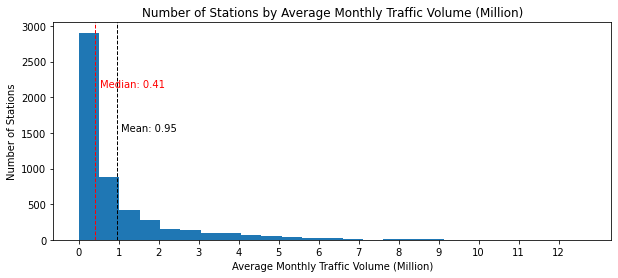

In [106]:
fig = plt.figure(1,figsize=(10, 4))
x = traffic_vol_df_monthly_avg_by_stn['average_monthly_traffic_volume_mil']
plt.hist(x, bins=25)
ax = fig.gca()
ax.set_xticks(np.arange(0, 13, 1))
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.5, 'Mean: {:.2f}'.format(x.mean()))
plt.text(x.median()*1.3, max_ylim*0.7, 'Median: {:.2f}'.format(x.median()), color = 'r')
plt.title('Number of Stations by Average Monthly Traffic Volume (Million)')
plt.xlabel('Average Monthly Traffic Volume (Million)')
plt.ylabel('Number of Stations')
plt.show()

Let's use the median as the threshold to classify whether a station is High Traffic or Low Traffic. We can also use mean, but median makes things easier since it allows us to have a balanced dataset.




In [107]:
traffic_vol_median = traffic_vol_df_monthly_avg_by_stn['average_monthly_traffic_volume'].median()
traffic_vol_df_monthly_avg_by_stn['has_high_traffic'] = traffic_vol_df_monthly_avg_by_stn['average_monthly_traffic_volume'].apply(lambda x: 1 if x >= traffic_vol_median else 0)


In [108]:
traffic_vol_df_monthly_avg_by_stn['has_high_traffic'].value_counts()

1    2607
0    2607
Name: has_high_traffic, dtype: int64

Now, we have our target label for classification! We can combine this with the station dataframe we currently have to get one single dataframe containing both the features and the label.

In [109]:
final_station_df_combined = pd.merge(final_station_df, traffic_vol_df_monthly_avg_by_stn, on = 'state_station', how = 'inner')

Next, we can further explore our data by doing a few exploratory analyses using visualizations:

- Since traffic volume dataframe has multiple time-related features eg. month, day of week, hour, we can plot time series charts to see if there are any interesting patterns.

- Given that we are interested in which locations have high traffic volume, a map visualization will be helpful to discover insights about this.

## Time series visualization of traffic volume

In [110]:
def plot_time_series(title, xlabel, ylabel, x_min_number, x_max_number, y_column):
    fig = plt.figure(1,figsize=(10, 4))
    ax = fig.gca()
    ax.set_xticks(np.arange(x_min_number, x_max_number + 1, 1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.arange(x_min_number, x_max_number + 1, 1), y_column)
    #plt.legend()
    return plt.show()

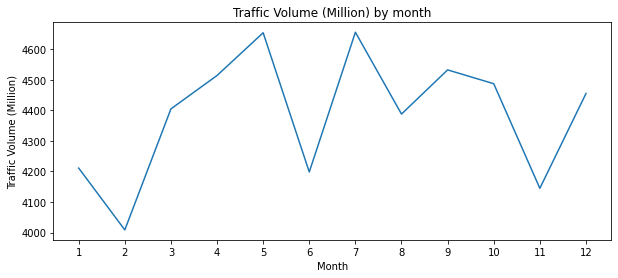

In [111]:
total_traffic_vol_by_month = traffic_volume_df_final.groupby(['month_of_data'], as_index = False)['traffic_volume_daily'].sum().rename(columns = {'traffic_volume_daily': 'traffic_volume_monthly'})
total_traffic_vol_by_month['traffic_volume_monthly_mil'] = total_traffic_vol_by_month['traffic_volume_monthly']/1000000
plot_time_series("Traffic Volume (Million) by month", 'Month', 'Traffic Volume (Million)', 1, 12, total_traffic_vol_by_month['traffic_volume_monthly_mil'])


From plotting traffic volume by month, we can see that the months with highest traffic volume are May and July.

We can also observe dips in certain months such as February, June, August and November. 

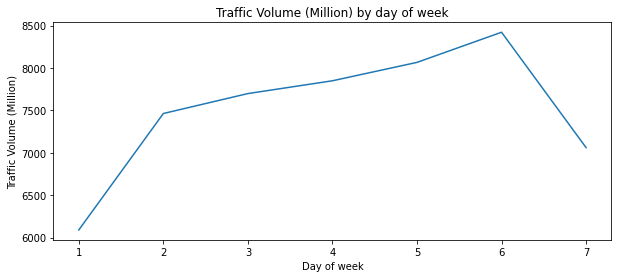

In [112]:
total_traffic_vol_by_dow = traffic_volume_df_final.groupby(['day_of_week'], as_index = False)['traffic_volume_daily'].sum()
total_traffic_vol_by_dow['traffic_volume_daily_mil'] = total_traffic_vol_by_dow['traffic_volume_daily']/1000000
plot_time_series("Traffic Volume (Million) by day of week", 'Day of week', 'Traffic Volume (Million)', 1, 7, total_traffic_vol_by_dow['traffic_volume_daily_mil'])


Given that different countries may have different definitions of day of week, the definition used in the dataframe is as follows:
- Sunday: day of week = 1
- Monday: day of week = 2
- Tuesday: day of week = 3
- Wednesday: day of week = 4
- Thursday: day of week = 5
- Friday: day of week = 6
- Saturday: day of week = 7

Therefore, we can observe that the lowest traffic volumes are on the weekends (Saturday and Sunday) while the highest traffic volumes are on weekdays, which makes sense since people might be resting at home on the weekends and going to work on the weekdays.

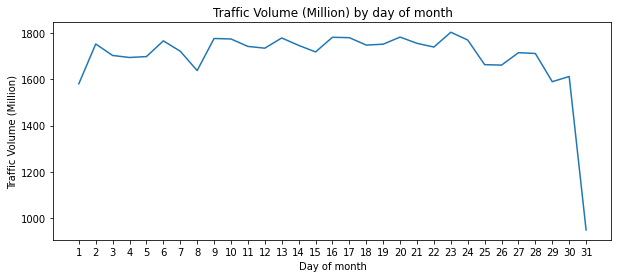

In [113]:
total_traffic_vol_by_dod =  traffic_volume_df_final.groupby(["day_of_data"],as_index=False)["traffic_volume_daily"].sum()
total_traffic_vol_by_dod['traffic_volume_daily_mil'] = total_traffic_vol_by_dod['traffic_volume_daily']/1000000
plot_time_series("Traffic Volume (Million) by day of month", 'Day of month', 'Traffic Volume (Million)', 1, 31, total_traffic_vol_by_dod['traffic_volume_daily_mil'])

For traffic volume by day of month, we see a pretty stable trend with a trough on Day 31. This is likely because not every month has Day 31 (eg. last day of April is Day 30) and therefore volume for Day 31 will be relatively low compared to other days of the month.

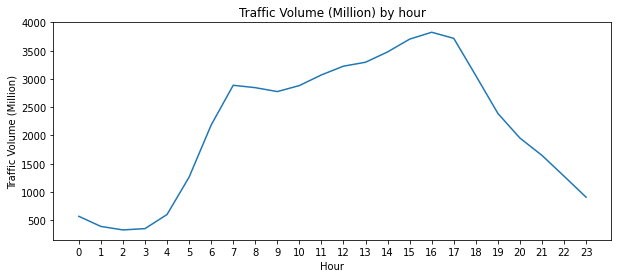

In [114]:
total_traffic_vol_by_hour = pd.DataFrame(np.sum(traffic_volume_df_final.loc[:,"traffic_volume_counted_after_0000_to_0100":"traffic_volume_counted_after_2300_to_2400"])).rename(columns = {0: 'traffic_volume_hourly'})
total_traffic_vol_by_hour['traffic_volume_hourly_mil'] = total_traffic_vol_by_hour['traffic_volume_hourly']/1000000
plot_time_series("Traffic Volume (Million) by hour", 'Hour', 'Traffic Volume (Million)', 0, 23, total_traffic_vol_by_hour['traffic_volume_hourly_mil'])

For traffic volume by hour, we can see that the first peak occurs around 7am, this is likely because people are going to work at this time.

The second peak occurs around 4pm, which is when people are most likely ending work and going home.

In [115]:
def plot_multiple_time_series(title, xlabel, ylabel, x_min_number, x_max_number, df, column_name, metric_name, fig_size = (10, 4)):
    fig = plt.figure(1,figsize=fig_size)
    ax = fig.gca()
    ax.set_xticks(np.arange(x_min_number, x_max_number + 1, 1))
    x = np.arange(x_min_number, x_max_number + 1, 1)
    category_list = df[column_name].unique()
    for i in category_list:
        y = df.loc[df[column_name] == i][metric_name]
        plt.plot(x, y, label = i)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    return plt.show()

In [116]:
def pivot_and_plot_monthly_traffic_vol_per_stn(df, column_name, fig_size = (10, 4)):
    pivot_df = pd.pivot_table(
       df,
       index=['month_of_data', column_name],
       aggfunc={'traffic_volume_daily': np.sum, 'state_station': pd.Series.nunique}
    ).rename(columns={'traffic_volume_daily': 'traffic_volume_monthly', 'state_station': 'no_stations'}).reset_index()

    pivot_df['traffic_volume_monthly_per_stn'] = pivot_df['traffic_volume_monthly']/pivot_df['no_stations']
    pivot_df['traffic_volume_monthly_per_stn_thousand'] = pivot_df['traffic_volume_monthly_per_stn']/1000
    return plot_multiple_time_series("Traffic Volume (K) per station by month by " + str(column_name), 'Month', 'Traffic Volume (K)', 1, 12, pivot_df, column_name, 'traffic_volume_monthly_per_stn_thousand', fig_size = fig_size)
    

Previously, we have plotted time series charts by various datetime features. We can also plot time series charts for a given feature (eg. urban_road_type) and compare the traffic volume across a time period for different categories of the feature.

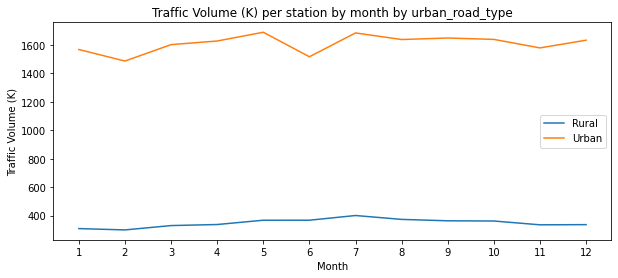

In [117]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'urban_road_type')

From plotting traffic volume each month for urban road type, we can see that Urban roads have significantly higher traffic volume compared to Rural roads.

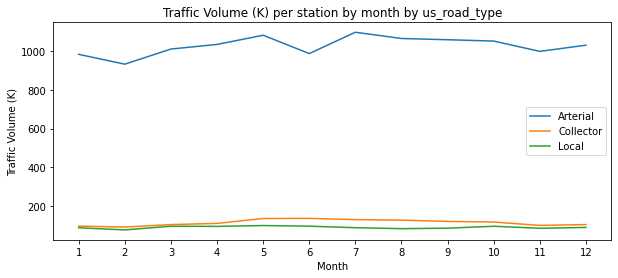

In [118]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'us_road_type')

For us road type (Arterial, Collector, Local), we can see that Arterial roads have significantly higher traffic volume compared to Collector and Local roads. This makes sense since Arterial roads provide the highest mobility and include highways and high-speed roadways.

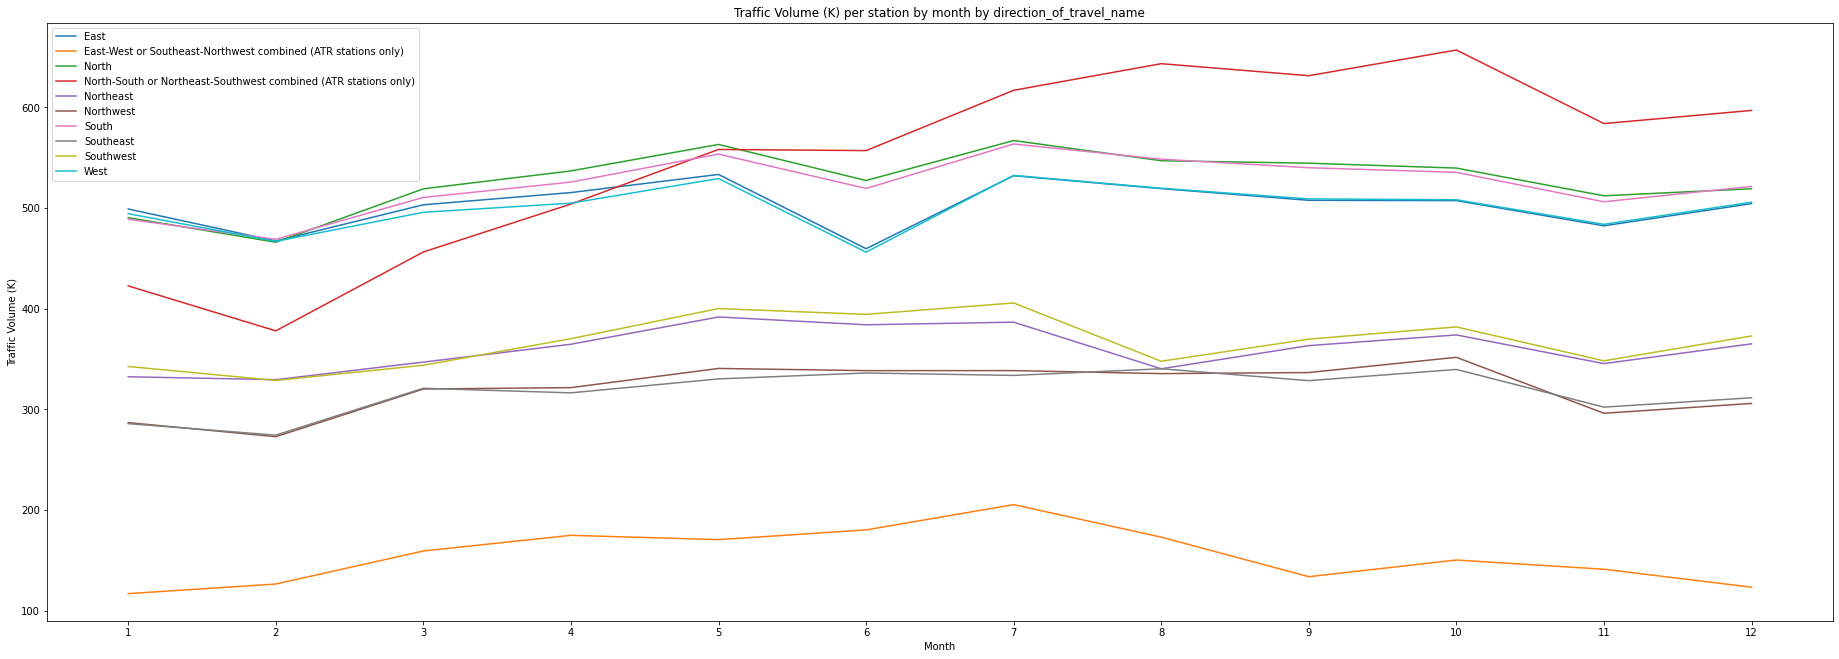

In [119]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'direction_of_travel_name', fig_size = (32, 11))

The original direction_of_travel_name features has too many categories, which makes it a bit difficult to discern trends. Let's try plotting the same graph using the feature we created: direction_of_travel_name_clean.

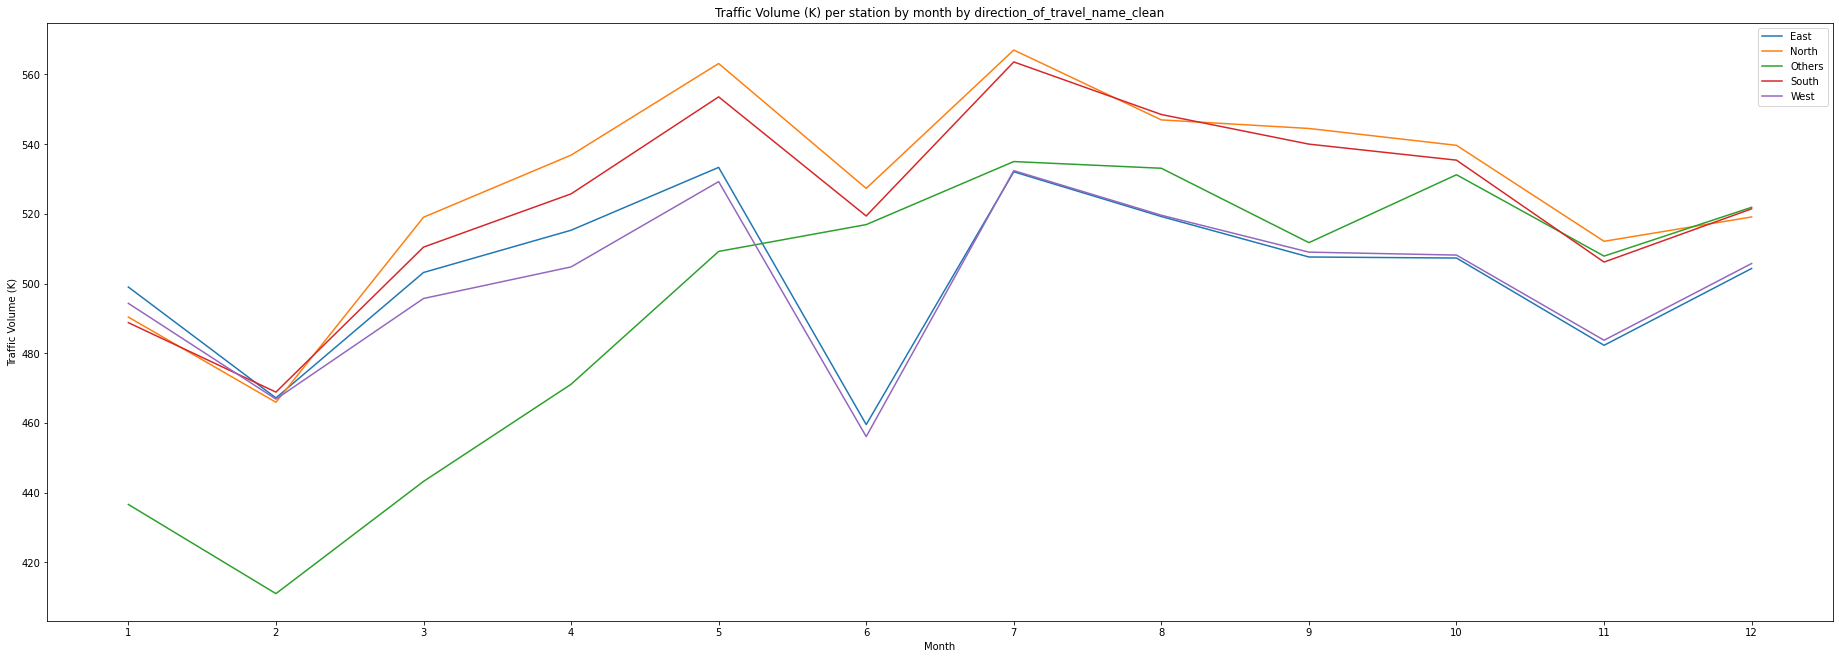

In [120]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'direction_of_travel_name_clean', fig_size = (32, 11))

Interestingly, we see that the traffic volume trend for East is very similar to that for West. The same applies to North and South as well.

There could be various reasons behind this. For instance, a sensor might be monitoring different directions for the same road. Therefore, if a car travels on that road, it gets captured once in the direction of East, and another time in the direction of West.

Nevertheless, given how correlated the traffic volume for the directions are, we might have to combine features for East/West and North/South directions later.

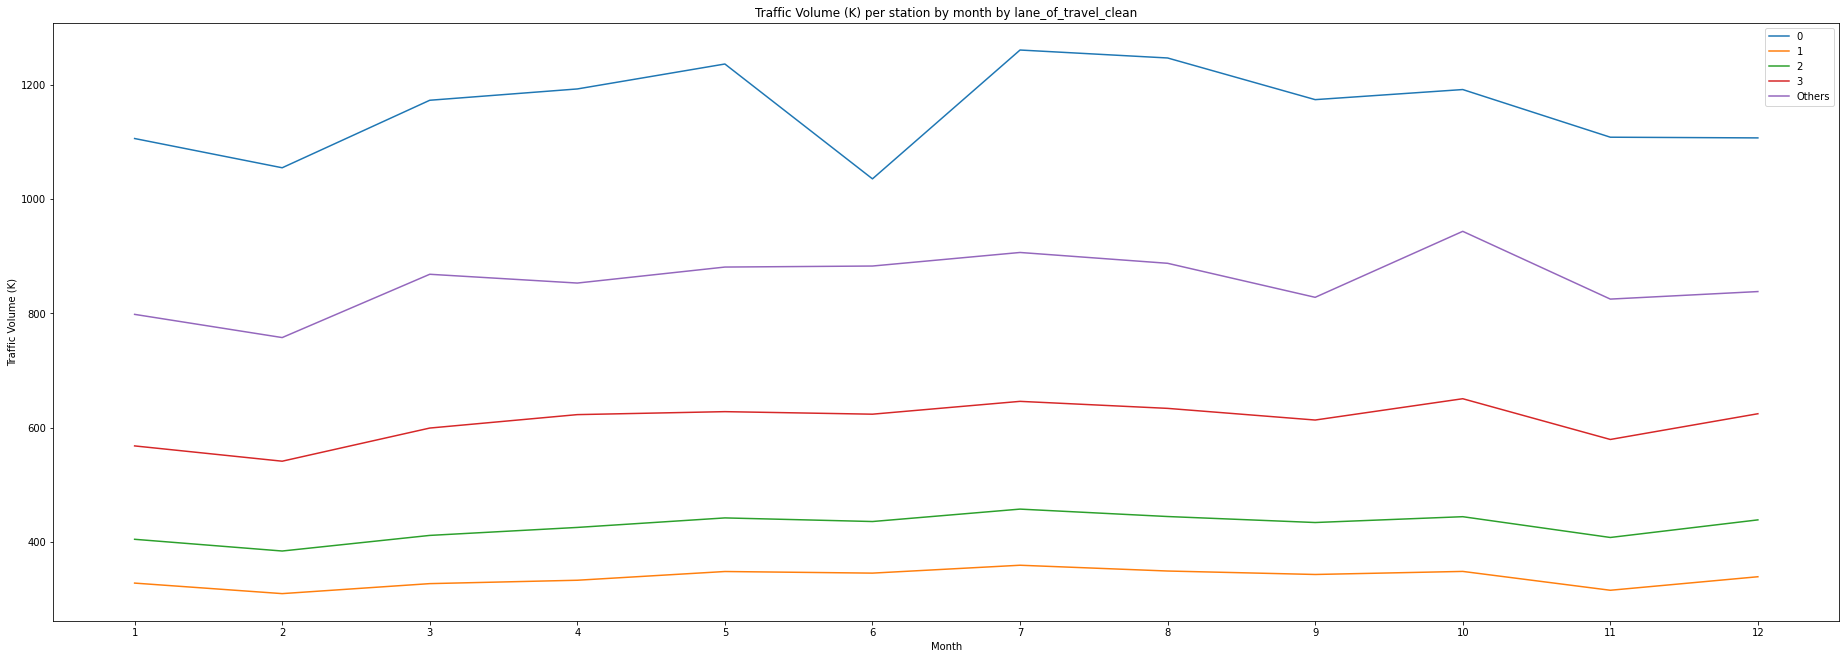

In [121]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'lane_of_travel_clean', fig_size = (32, 11))

For the lane of travel feature we created, we can see a clear difference in traffic volumes between each of the lanes.

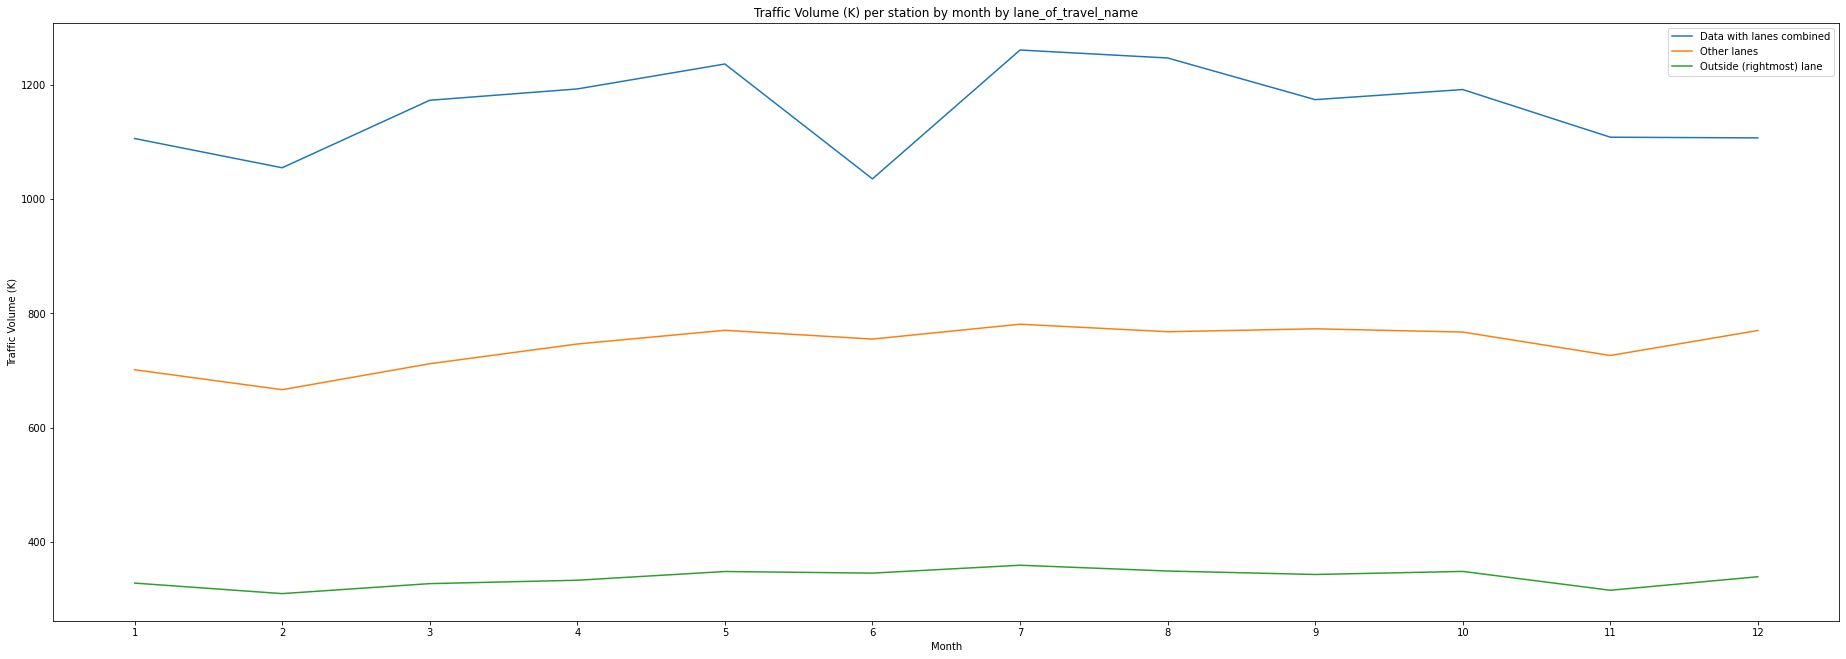

In [122]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'lane_of_travel_name', fig_size = (32, 11))

For the less granular lane_of_travel_name feature given to us, we can see that Data with lanes combined (lane 0) has the highest traffic volume, followed by other lanes (lane 1) and lastly the Outside rightmost lane.

### Map visualization of Traffic volume by State and County

To identify the locations with highest traffic volume, it's helpful to do a map visualization. Since we have state and county information, we can create map visualizations by state and county.

In [123]:
#Define function to help us create map visualizations for state and county
def make_map(df, postal_code_col, metric_col, legend_name, map_type="state"):
    
    url = (
        "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
    )
    
    if map_type == "county":
        f = open('us-counties.json')
        state_geo = json.load(f)                       #return json object as dict
    else:
        state_geo = f"{url}/us-states.json"

    m = folium.Map(location=[48, -102], zoom_start=3)

    folium.Choropleth(
        geo_data=state_geo,
        name="choropleth",
        data=df,
        columns=[postal_code_col, metric_col],
        nan_fill_color='grey',
        nan_fill_opacity=0.2,
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
    ).add_to(m)

    folium.LayerControl().add_to(m)
    
    return m

In [124]:
traffic_volume_df_monthly = traffic_volume_df_final.groupby(["fips_state_code", "month_of_data"],as_index=False)["traffic_volume_daily"].sum().rename(columns = {'traffic_volume_daily': 'traffic_volume_monthly'})
traffic_volume_df_average_monthly = traffic_volume_df_monthly.groupby(["fips_state_code"],as_index=False)["traffic_volume_monthly"].mean().rename(columns = {'traffic_volume_monthly': 'traffic_volume_monthly_average'})
traffic_volume_df_average_monthly = pd.merge(traffic_volume_df_average_monthly, us_states, left_on = 'fips_state_code', right_on = 'FIPS', how = 'left').drop(['FIPS'],axis=1).rename(columns = {'Name':'state_name','Postal Code':'state_postal_code'})
traffic_volume_df_average_monthly.head()

fips_state_code  traffic_volume_monthly_average  state_name  \
0                1                   121792492.083     Alabama   
1                2                    25049039.083      Alaska   
2                4                   408768925.167     Arizona   
3                5                     8975574.250    Arkansas   
4                6                   552689021.333  California   

  state_postal_code  
0                AL  
1                AK  
2                AZ  
3                AR  
4                CA

In [125]:
traffic_volume_df_average_monthly.sort_values(by = 'traffic_volume_monthly_average', ascending = False).head(10)

fips_state_code  traffic_volume_monthly_average  state_name  \
4                 6                   552689021.333  California   
2                 4                   408768925.167     Arizona   
9                12                   367792979.333     Florida   
10               13                   257663317.000     Georgia   
38               48                   232640979.750       Texas   
33               39                   208522802.167        Ohio   
22               26                   191284765.250    Michigan   
41               53                   176880059.083  Washington   
43               55                   133580379.000   Wisconsin   
11               15                   131964911.167      Hawaii   

   state_postal_code  
4                 CA  
2                 AZ  
9                 FL  
10                GA  
38                TX  
33                OH  
22                MI  
41                WA  
43                WI  
11                HI

First, let's visualize Average monthly traffic volume for each state.

In [126]:
make_map(traffic_volume_df_average_monthly, "state_postal_code", "traffic_volume_monthly_average", "Average Monthly Traffic Volume")

From the map visualization, we can clearly see that states California and Arizona have high traffic volume.

However, given that there may be different number of stations in a state, the states may have high traffic volume simply because they have a large number of stations.

To account for this, we can show Average monthly traffic volume per station for each state instead.

In [127]:
#good to check how many active stations in one state
stations_df = traffic_volume_df_final.groupby(["fips_state_code"],as_index=False)["station_id"].nunique().rename(columns = {'station_id':'no_stations'})

In [128]:
stations_df.head(10)

fips_state_code  no_stations
0                1          149
1                2          104
2                4          152
3                5           23
4                6          288
5                8          105
6                9            1
7               10           77
8               11            2
9               12          274

In [129]:
traffic_volume_df_monthly_per_stn = pd.merge(traffic_volume_df_monthly, stations_df, on = 'fips_state_code')
traffic_volume_df_monthly_per_stn['traffic_vol_monthly_per_stn'] = traffic_volume_df_monthly_per_stn['traffic_volume_monthly']/traffic_volume_df_monthly_per_stn['no_stations']
traffic_volume_df_monthly_per_stn_avg = traffic_volume_df_monthly_per_stn.groupby(["fips_state_code"],as_index=False)["traffic_vol_monthly_per_stn"].mean().rename(columns = {'traffic_vol_monthly_per_stn': 'traffic_vol_monthly_per_stn_avg'})
traffic_volume_df_monthly_per_stn_avg_df = pd.merge(traffic_volume_df_monthly_per_stn_avg, us_states, left_on = 'fips_state_code', right_on = 'FIPS', how = 'left').drop(['FIPS'],axis=1).rename(columns = {'Name':'state_name','Postal Code':'state_postal_code'}) 
traffic_volume_df_monthly_per_stn_avg_df.head()

fips_state_code  traffic_vol_monthly_per_stn_avg  state_name  \
0                1                       817399.276     Alabama   
1                2                       240856.145      Alaska   
2                4                      2689269.245     Arizona   
3                5                       390242.359    Arkansas   
4                6                      1919059.102  California   

  state_postal_code  
0                AL  
1                AK  
2                AZ  
3                AR  
4                CA

In [130]:
traffic_volume_df_monthly_per_stn_avg_df.sort_values(by = 'traffic_vol_monthly_per_stn_avg', ascending = False).head(10)

fips_state_code  traffic_vol_monthly_per_stn_avg            state_name  \
2                 4                      2689269.245               Arizona   
4                 6                      1919059.102            California   
8                11                      1896249.167  District of Columbia   
36               44                      1810720.009          Rhode Island   
11               15                      1783309.610                Hawaii   
20               24                      1597974.523              Maryland   
22               26                      1594039.710              Michigan   
9                12                      1342310.144               Florida   
33               39                      1241207.156                  Ohio   
10               13                      1155440.883               Georgia   

   state_postal_code  
2                 AZ  
4                 CA  
8                 DC  
36                RI  
11                HI  
20                MD  
22                MI  
9                 FL  
33                OH  
10                GA

In [131]:
make_map(traffic_volume_df_monthly_per_stn_avg_df, "state_postal_code", "traffic_vol_monthly_per_stn_avg", "Average Monthly Traffic Volume Per Station")

After taking into account the number of stations, we see some difference in the ranking of states with highest traffic volume. We also see that Arizona is now the state with the highest traffic volume.

Now that we have created map visualizations for states, we can do the same for counties as well.

In [132]:
county_mapping = traffic_station_df_final[["state_station", "fips_county_code"]].drop_duplicates()
county_mapping.set_index(["state_station"], inplace=True)
traffic_volume_df_county = traffic_volume_df_final[["state_station", "fips_state_code", "station_id", "month_of_data", "traffic_volume_daily"]]
traffic_volume_df_county.set_index(["state_station"], inplace=True)
traffic_volume_df_county_daily = traffic_volume_df_county.join(county_mapping, how = 'inner').reset_index()
traffic_volume_df_county_daily

state_station  fips_state_code station_id  month_of_data  \
0            1 000002                1     000002              4   
1            1 000002                1     000002              3   
2            1 000002                1     000002              3   
3            1 000002                1     000002              9   
4            1 000002                1     000002              5   
...               ...              ...        ...            ...   
5148228      9 000268                9     000268             10   
5148229      9 000268                9     000268             10   
5148230      9 000268                9     000268             10   
5148231      9 000268                9     000268             10   
5148232      9 000268                9     000268             10   

         traffic_volume_daily fips_county_code  
0                        2078               71  
1                        5397               71  
2                        2656               71  
3                        5010               71  
4                        5571               71  
...                       ...              ...  
5148228                 13219                2  
5148229                 13007                2  
5148230                 17769                2  
5148231                 17603                2  
5148232                 17755                2  

[5148233 rows x 6 columns]

In [133]:
traffic_volume_df_county_monthly = traffic_volume_df_county_daily.groupby(["fips_state_code", "fips_county_code", "month_of_data"],as_index=False)["traffic_volume_daily"].sum().rename(columns = {'traffic_volume_daily': 'traffic_volume_monthly'})
stations_county_df = traffic_volume_df_county_daily.groupby(["fips_state_code", "fips_county_code"],as_index=False)["station_id"].nunique().rename(columns = {'station_id':'no_stations'})
traffic_volume_df_county_monthly_per_stn = pd.merge(traffic_volume_df_county_monthly, stations_county_df, on = ['fips_state_code','fips_county_code'])
traffic_volume_df_county_monthly_per_stn['traffic_vol_monthly_per_stn'] = traffic_volume_df_county_monthly_per_stn['traffic_volume_monthly']/traffic_volume_df_county_monthly_per_stn['no_stations']
traffic_volume_df_county_monthly_per_stn_avg = traffic_volume_df_county_monthly_per_stn.groupby(["fips_state_code", "fips_county_code"],as_index=False)["traffic_vol_monthly_per_stn"].mean().rename(columns = {'traffic_vol_monthly_per_stn': 'traffic_vol_monthly_per_stn_avg'})

In [134]:
#Process state code and county code to be used for creating map
traffic_volume_df_county_monthly_per_stn_avg['fips_county_code_unique'] = traffic_volume_df_county_monthly_per_stn_avg["fips_state_code"].astype(str) + traffic_volume_df_county_monthly_per_stn_avg["fips_county_code"].apply(lambda x: str(x).zfill(3))

In [135]:
make_map(traffic_volume_df_county_monthly_per_stn_avg, "fips_county_code_unique", "traffic_vol_monthly_per_stn_avg", "Average Monthly Traffic Volume by county", "county")

Given that there are too many states, it is difficult to identify clear patterns from the map visualization.

However, even among high traffic states we've identified earlier such as Arizona and California, we can see that only specific counties have especially high traffic volume. This could mean that it might be more effective to manage traffic planning on county level instead of state level.

Lastly, both the map visualizations for state and county show that certain states and counties have higher traffic volume and therefore could be useful features to be included in modeling later.

### Correlation analysis between Features

Before we do the modeling, it is usually a good idea to analyze the interactions between different features. If two features are highly correlated, it will be good to remove one of them or merge them since they provide very similar information.

To analyze the interactions between our continuous variables, we can do a correlation analysis.

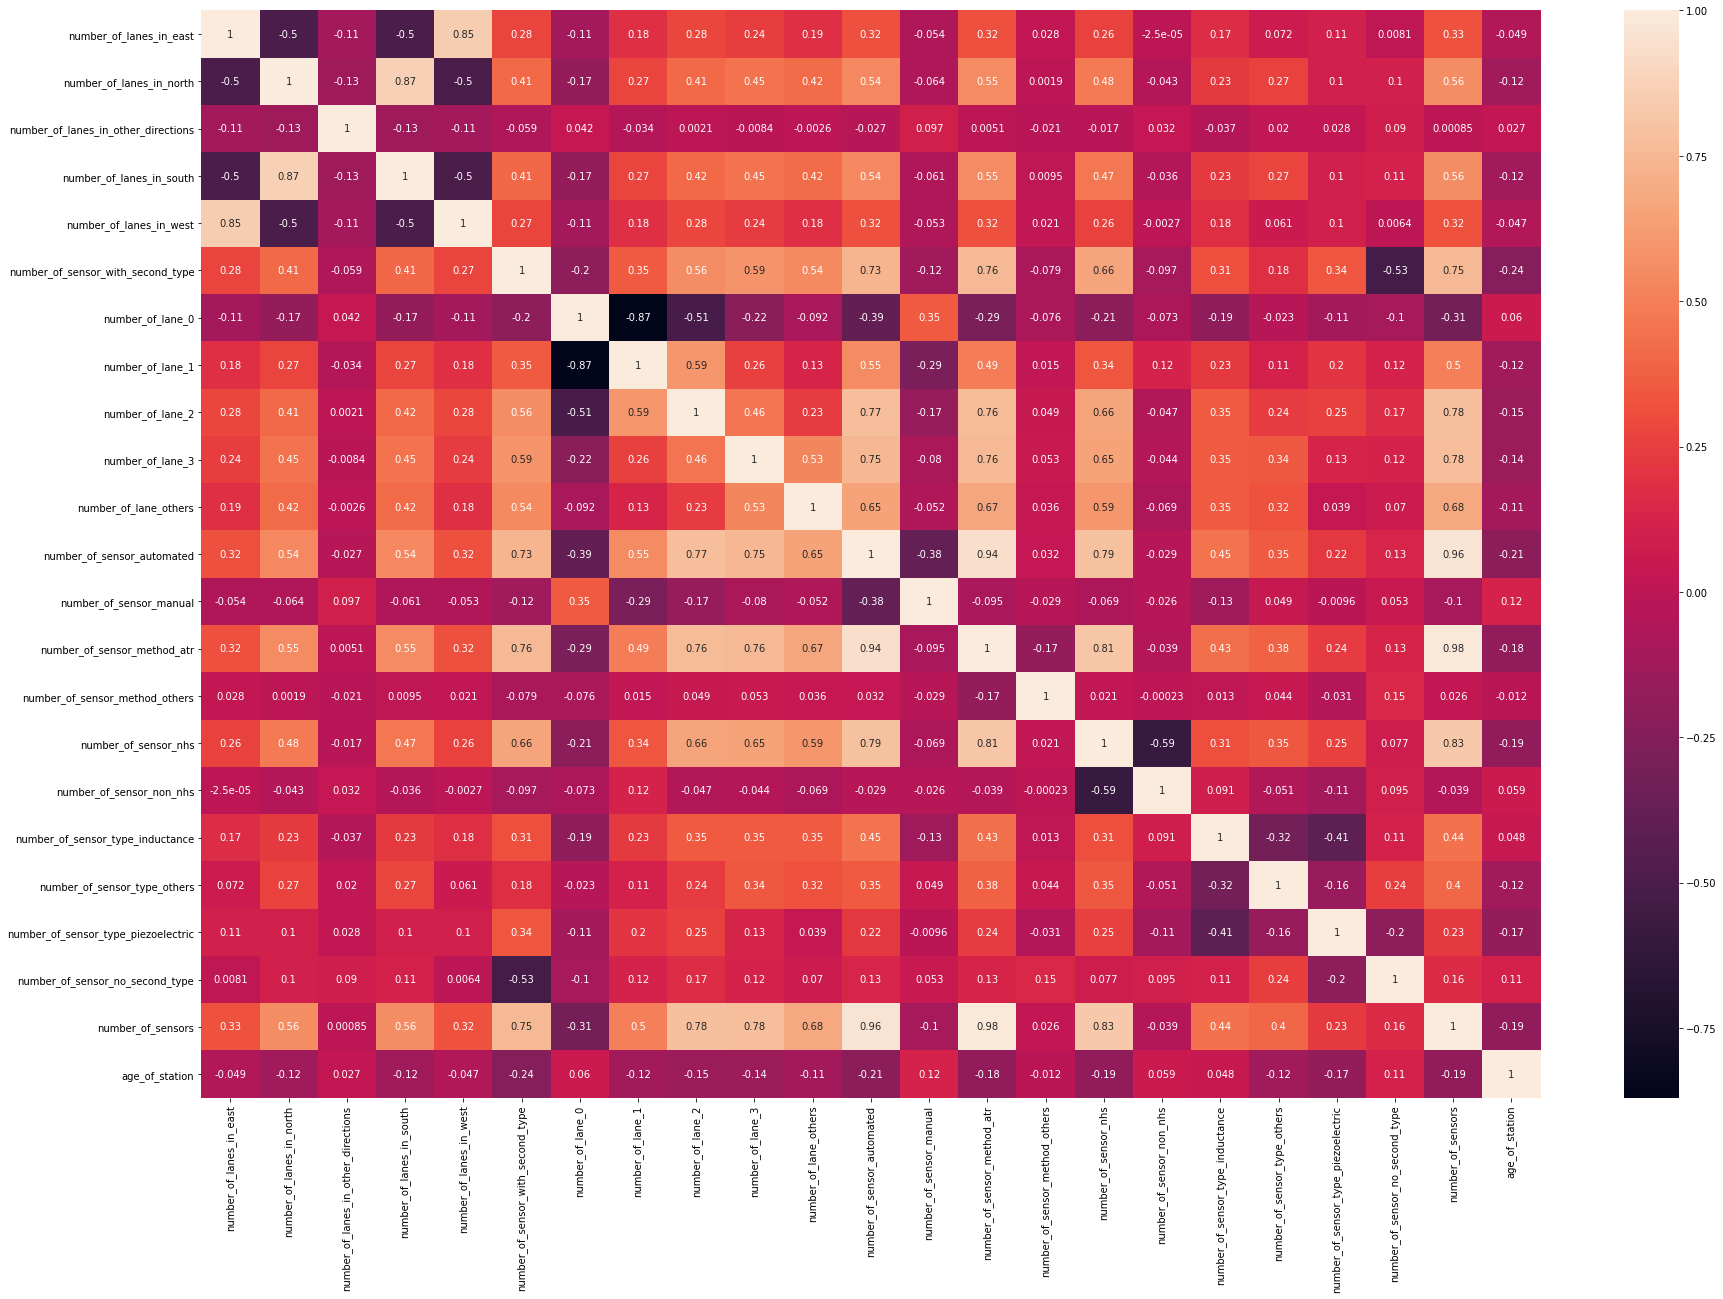

In [136]:
def plot_correlation_matrix(columns):
    corrMatrix = final_station_df[columns].corr()
    fig, ax = plt.subplots(figsize=(30,20))
    sn.heatmap(corrMatrix, annot=True, ax = ax)
    return plt.show()

#select only continuous variables
columns = ['number_of_lanes_in_east', 'number_of_lanes_in_north',
       'number_of_lanes_in_other_directions', 'number_of_lanes_in_south',
       'number_of_lanes_in_west', 'number_of_sensor_with_second_type',
       'number_of_lane_0', 'number_of_lane_1', 'number_of_lane_2',
       'number_of_lane_3', 'number_of_lane_others',
       'number_of_sensor_automated', 'number_of_sensor_manual',
       'number_of_sensor_method_atr', 'number_of_sensor_method_others',
       'number_of_sensor_nhs', 'number_of_sensor_non_nhs',
       'number_of_sensor_type_inductance', 'number_of_sensor_type_others',
       'number_of_sensor_type_piezoelectric',
       'number_of_sensor_no_second_type', 'number_of_sensors', 'age_of_station']

plot_correlation_matrix(columns)

From the correlation matrix, we can observe several highly correlated features:

- number_of_sensor_automated is highly correlated with number_of_sensor_atr. This makes sense since the method of traffic volume counting also tells us whether it is automated or manual (eg. using Automatic Traffic recorder is an  automated method).

    > Since both features represent similar information, we can just remove one of them. We shall remove number_of_sensor_method_atr, since number_of_sensor_automated is more intuitive. 
    
    > We will also remove its counterpart number_of_sensor_method_others as well, since it has only a small number of non-zero records so it's likely not to be very informative, plus we already have number_of_sensor_manual.


- number_of_sensors is highly correlated with multiple features such as number_of_sensor_automated.

    > Number of sensors is the aggregate, representing the summation of individual features. It is likely highly correlated with number_of_sensor_automated since many stations have automated sensors, therefore number_of_sensor_automated would be close to number_of_sensors.
    
    > Since information can be represented by individual features, we can just remove number_of_sensors feature.
    
- As we discovered in the time-series visualizations, number_of_lanes_in_north has a high correlation with number_of_lanes_in_south, while number_of_lanes_in_east has a high correlation with number_of_lanes_in_west.

    > In this case, we'll just keep 1 and remove the other as well.

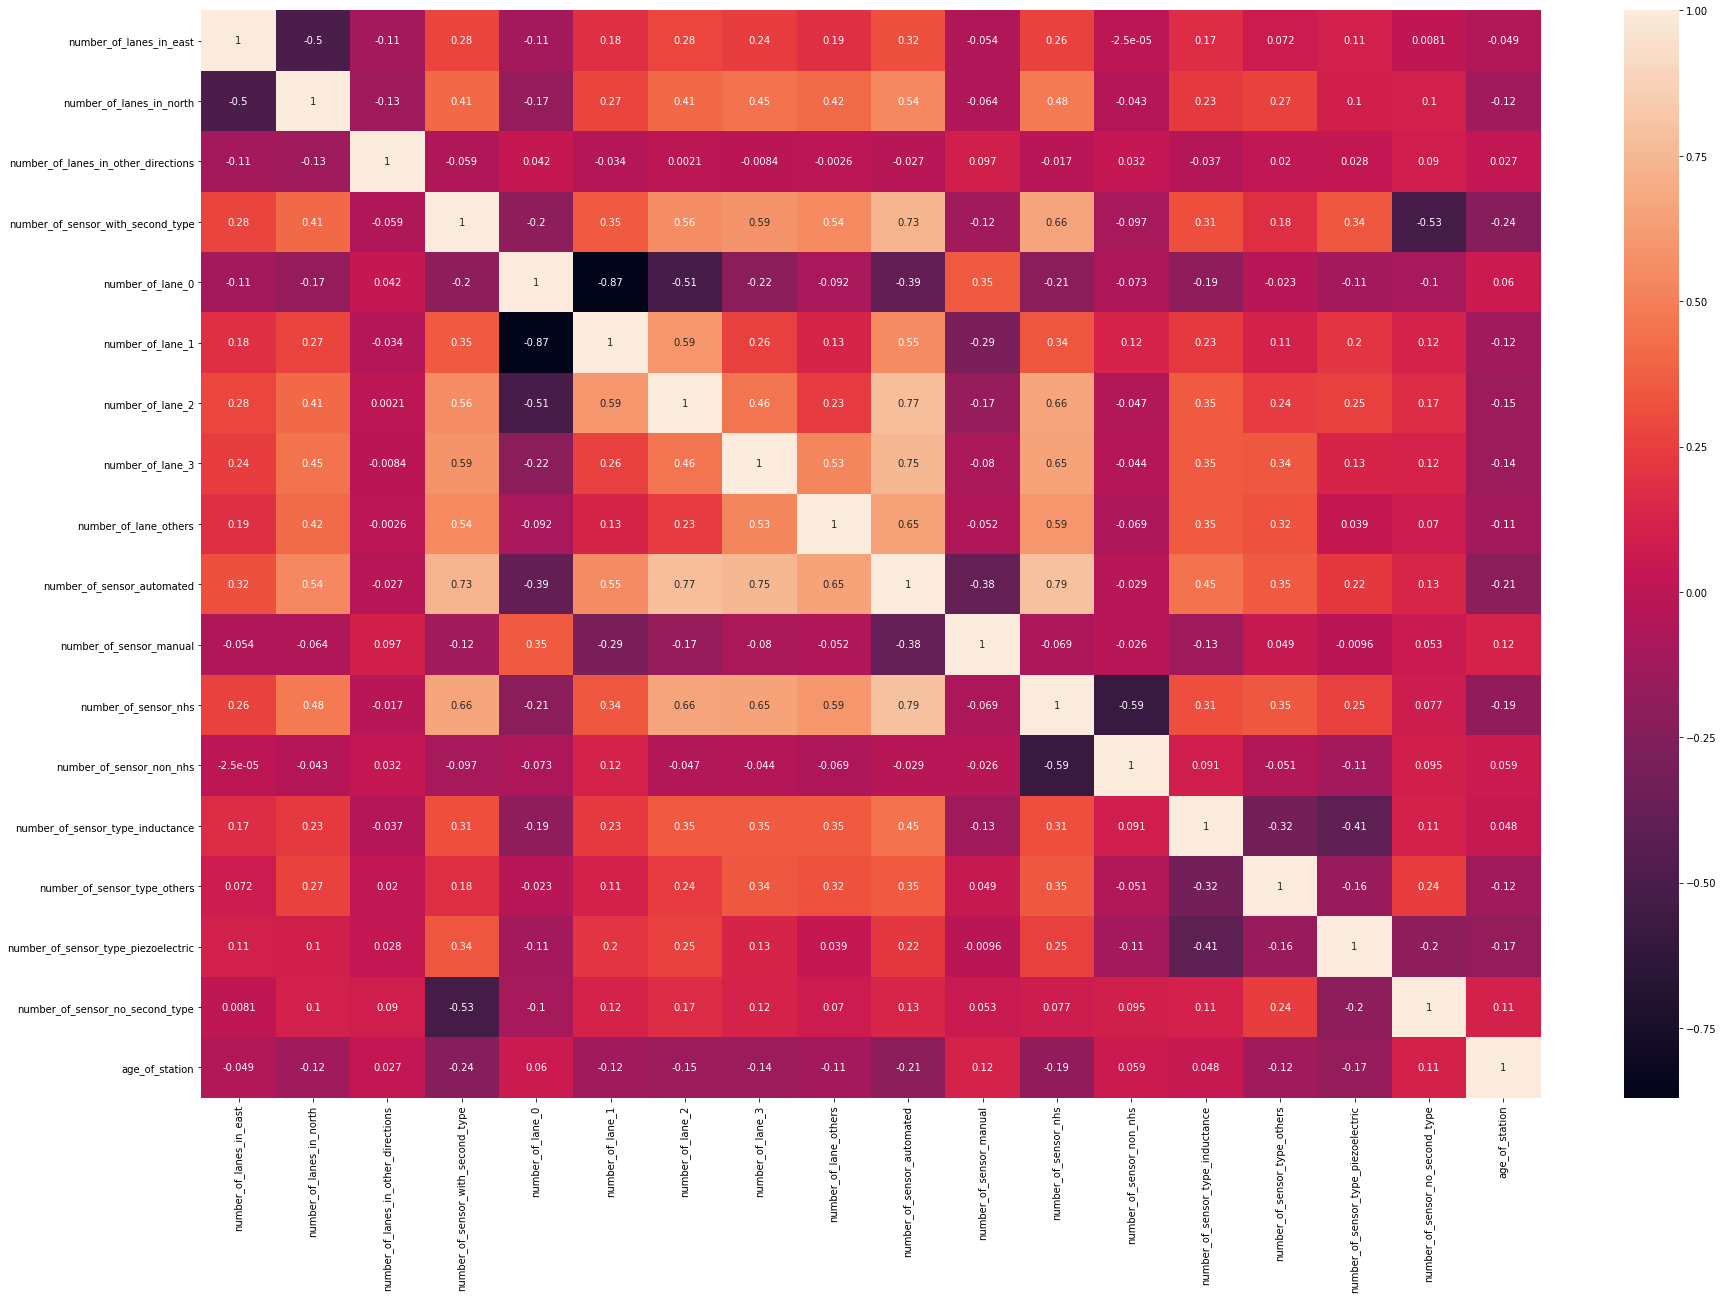

In [137]:
columns = ['number_of_lanes_in_east', 'number_of_lanes_in_north',
       'number_of_lanes_in_other_directions', 'number_of_sensor_with_second_type',
       'number_of_lane_0', 'number_of_lane_1', 'number_of_lane_2',
       'number_of_lane_3', 'number_of_lane_others',
       'number_of_sensor_automated', 'number_of_sensor_manual',
       'number_of_sensor_nhs', 'number_of_sensor_non_nhs',
       'number_of_sensor_type_inductance', 'number_of_sensor_type_others',
       'number_of_sensor_type_piezoelectric',
       'number_of_sensor_no_second_type', 'age_of_station']

plot_correlation_matrix(columns)

After removing the features, we see that the correlation between features is not that high now.

Some features such as number_of_sensor_automated and number_of_sensor_nhs still have high correlation with other features. However, since they represent different information from other variables, we will keep them for now.

Now that we have selected the key features, we can move on to building our model. Technically, we can also do feature selection for our categorical variables (such as doing a chi squared analysis) but let's try using our current set of features first.

# Model Building 

### Preparing data for modeling

Before we proceed with model building, some of our features are still not encoded, so we have to do so as our model only recognizes numeric representations. We will use label encoding due to its convenience and because one hot encoding has a problem with dimensionality.

The features we will encode are:
- state feature (fips_state_code)
- county feature (we will have to concatenate fips_state_code and fips_county_code, just like we did in the map visualization)
- functional_classification_name
- urban_road_type
- us_road_type

In [138]:
final_station_df_combined['fips_county_code_unique'] = final_station_df_combined["fips_state_code"].astype(str) + final_station_df_combined["fips_county_code"].apply(lambda x: str(x).zfill(3))

In [139]:
final_station_df_combined['fips_county_code_unique'] = final_station_df_combined['fips_county_code_unique'].astype(int) #convert to integer, so encoding will happen in right sequence
cols_to_be_encoded = ['fips_state_code', 'fips_county_code_unique', 'functional_classification_name', 'urban_road_type', 'us_road_type']
cols_encoded = ['fips_state_code_encoded', 'fips_county_code_unique_encoded', 'functional_classification_name_encoded', 'urban_road_type_encoded', 'us_road_type_encoded']

le = LabelEncoder()
final_station_df_combined[cols_encoded] = final_station_df_combined[cols_to_be_encoded].apply(le.fit_transform)

In [140]:
final_station_df_combined[['fips_state_code', 'fips_state_code_encoded']].drop_duplicates().sort_values(by = 'fips_state_code').head(10)

fips_state_code  fips_state_code_encoded
0                   1                        0
1304                2                        1
3272                4                        2
4153                5                        3
4820                6                        4
5108                8                        5
5213                9                        6
149                10                        7
226                11                        8
228                12                        9

In [141]:
final_station_df_combined[['fips_county_code_unique', 'fips_county_code_unique_encoded']].drop_duplicates().sort_values(by = 'fips_county_code_unique')

fips_county_code_unique  fips_county_code_unique_encoded
30                       1001                                0
15                       1003                                1
16                       1005                                2
102                      1009                                3
17                       1011                                4
...                       ...                              ...
4662                    56037                             1572
4678                    56039                             1573
4702                    56041                             1574
4704                    56043                             1575
4687                    56045                             1576

[1577 rows x 2 columns]

In [142]:
final_station_df_combined[['functional_classification_name', 'functional_classification_name_encoded']].drop_duplicates().sort_values(by = 'functional_classification_name')

functional_classification_name  \
1269                                Rural: Local System   
19                               Rural: Major Collector   
2                                 Rural: Minor Arterial   
149                              Rural: Minor Collector   
1                Rural: Principal Arterial - Interstate   
0                     Rural: Principal Arterial - Other   
86                                     Urban: Collector   
528                                 Urban: Local System   
8                                 Urban: Minor Arterial   
38               Urban: Principal Arterial - Interstate   
18                    Urban: Principal Arterial - Other   
62    Urban: Principal Arterial - Other Freeways or ...   

      functional_classification_name_encoded  
1269                                       0  
19                                         1  
2                                          2  
149                                        3  
1                                          4  
0                                          5  
86                                         6  
528                                        7  
8                                          8  
38                                         9  
18                                        10  
62                                        11

Now that we have encoded our features, we can proceed with preparing our training and test data.

Currently, we have around 5K samples. There should be enough training samples, so we shall use a 70/30 split for our training and test data.

In [143]:
columns = ['number_of_lanes_in_east', 'number_of_lanes_in_north',
       'number_of_lanes_in_other_directions', 'number_of_sensor_with_second_type',
       'number_of_lane_0', 'number_of_lane_1', 'number_of_lane_2',
       'number_of_lane_3', 'number_of_lane_others',
       'number_of_sensor_automated', 'number_of_sensor_manual',
       'number_of_sensor_nhs', 'number_of_sensor_non_nhs',
       'number_of_sensor_type_inductance', 'number_of_sensor_type_others',
       'number_of_sensor_type_piezoelectric',
       'number_of_sensor_no_second_type', 'age_of_station',
       'fips_state_code_encoded', 'fips_county_code_unique_encoded',
       'functional_classification_name_encoded', 'urban_road_type_encoded', 'us_road_type_encoded',
       'sensor_type', 'second_type_of_sensor',
       'method_traffic_vol_counting', 'method_data_retrieval', 
       'lane_type', 'national_highway_system', 'has_high_traffic'     
]

train, test = train_test_split(final_station_df_combined[columns], test_size = 0.3, random_state = RANDOM_STATE)
train_y = train['has_high_traffic']
test_y = test['has_high_traffic']
 
train_x = train
train_x.pop('has_high_traffic')
test_x = test
test_x.pop('has_high_traffic')

28      1
1734    1
3432    0
1162    0
3816    0
       ..
938     1
2857    1
4247    1
3691    1
6       0
Name: has_high_traffic, Length: 1565, dtype: int64

### Baseline Model

Now that we have prepared our training and test data, we can build a baseline model.

For our baseline model, we shall use a Random Forest Classifier. This is because Random Forest is scale-invariant so we don't have to scale our features (unlike certain models such as SVM) and Random Forest usually gives pretty good performance.

For model evaluation, we can use several metrics such as AUROC score or F1 score. Given that our dataset is balanced, we can just use AUROC score to evaluate our model. AUROC score compares the True Positive Rate and False Positive Rate of our samples.

0.8472094284277024
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       777
           1       0.84      0.86      0.85       788

    accuracy                           0.85      1565
   macro avg       0.85      0.85      0.85      1565
weighted avg       0.85      0.85      0.85      1565



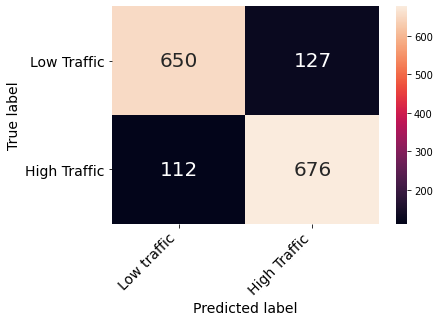

In [144]:
model1 = RandomForestClassifier(random_state = RANDOM_STATE)
model1.fit(X=train_x, y=train_y)
 
test_y_pred = model1.predict(test_x)
cm = confusion_matrix(test_y.tolist(), test_y_pred.tolist())
confusion_matrix_df = pd.DataFrame(cm, ('Low Traffic', 'High Traffic'), ('Low traffic', 'High Traffic'))
heatmap = sn.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

print(roc_auc_score(test_y, test_y_pred))
print(classification_report(test_y, test_y_pred))

### Obtaining the Best Model

With the baseline model, we obtain an AUROC score of 0.866. That's a pretty good result. However, are there other models that can beat this baseline?

Let's try building and fitting other state-of-the-art tree-based models to see if we can get a better result.

In [145]:
classifiers = [
    AdaBoostClassifier(random_state = RANDOM_STATE),
    GradientBoostingClassifier(random_state = RANDOM_STATE),
    XGBClassifier(random_state=RANDOM_STATE),
    lgb.LGBMClassifier(random_state=RANDOM_STATE),
    CatBoostClassifier(random_state=RANDOM_STATE)
]

for classifier in classifiers:
    classifier.fit(train_x, train_y)   
    print(classifier)
    
    test_y_pred = classifier.predict(test_x) 
    print('Model AUROC: ' + str(roc_auc_score(test_y, test_y_pred)))

AdaBoostClassifier(random_state=1)
Model AUROC: 0.8555749367932108
GradientBoostingClassifier(random_state=1)
Model AUROC: 0.8637607876186556
[23:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Model AUROC: 0.8772293867471533
LGBMClassifier(random_state=1)
Model AUROC: 0.8651555834296951
Learning rate set to 0.017905
0:	learn: 0.6812822	total: 55.9ms	remaining: 55.9s
1:	learn: 0.6662133	total: 59.2ms	remaining: 29.6s
2:	learn: 0.6529932	total: 62.5ms	remaining: 20.8s
3:	learn: 0.6402469	total: 65.5ms	remaining: 16.3s
4:	learn: 0.6273389	total: 69.4ms	remaining: 13.8s
5:	learn: 0.6164501	total: 72.5ms	rema

162:	learn: 0.3125432	total: 1.12s	remaining: 5.76s
163:	learn: 0.3121683	total: 1.13s	remaining: 5.77s
164:	learn: 0.3116611	total: 1.14s	remaining: 5.77s
165:	learn: 0.3114585	total: 1.16s	remaining: 5.82s
166:	learn: 0.3110995	total: 1.16s	remaining: 5.81s
167:	learn: 0.3108883	total: 1.17s	remaining: 5.79s
168:	learn: 0.3105216	total: 1.18s	remaining: 5.78s
169:	learn: 0.3100879	total: 1.18s	remaining: 5.77s
170:	learn: 0.3097500	total: 1.19s	remaining: 5.76s
171:	learn: 0.3096811	total: 1.2s	remaining: 5.76s
172:	learn: 0.3093295	total: 1.2s	remaining: 5.75s
173:	learn: 0.3091415	total: 1.21s	remaining: 5.75s
174:	learn: 0.3088548	total: 1.22s	remaining: 5.74s
175:	learn: 0.3084037	total: 1.23s	remaining: 5.74s
176:	learn: 0.3083201	total: 1.23s	remaining: 5.72s
177:	learn: 0.3080576	total: 1.23s	remaining: 5.7s
178:	learn: 0.3077313	total: 1.24s	remaining: 5.7s
179:	learn: 0.3075171	total: 1.25s	remaining: 5.69s
180:	learn: 0.3072297	total: 1.26s	remaining: 5.69s
181:	learn: 0.30

347:	learn: 0.2743389	total: 2.38s	remaining: 4.46s
348:	learn: 0.2741861	total: 2.38s	remaining: 4.44s
349:	learn: 0.2740764	total: 2.38s	remaining: 4.43s
350:	learn: 0.2737950	total: 2.39s	remaining: 4.41s
351:	learn: 0.2736154	total: 2.39s	remaining: 4.4s
352:	learn: 0.2735235	total: 2.4s	remaining: 4.39s
353:	learn: 0.2734379	total: 2.4s	remaining: 4.38s
354:	learn: 0.2733486	total: 2.4s	remaining: 4.36s
355:	learn: 0.2731308	total: 2.41s	remaining: 4.36s
356:	learn: 0.2730572	total: 2.41s	remaining: 4.35s
357:	learn: 0.2728588	total: 2.42s	remaining: 4.34s
358:	learn: 0.2727800	total: 2.42s	remaining: 4.33s
359:	learn: 0.2727263	total: 2.43s	remaining: 4.31s
360:	learn: 0.2725952	total: 2.43s	remaining: 4.3s
361:	learn: 0.2725061	total: 2.43s	remaining: 4.29s
362:	learn: 0.2724416	total: 2.44s	remaining: 4.28s
363:	learn: 0.2723544	total: 2.44s	remaining: 4.27s
364:	learn: 0.2721679	total: 2.44s	remaining: 4.25s
365:	learn: 0.2719530	total: 2.45s	remaining: 4.24s
366:	learn: 0.271

539:	learn: 0.2478991	total: 3.3s	remaining: 2.81s
540:	learn: 0.2478283	total: 3.3s	remaining: 2.8s
541:	learn: 0.2477825	total: 3.3s	remaining: 2.79s
542:	learn: 0.2476547	total: 3.31s	remaining: 2.78s
543:	learn: 0.2475695	total: 3.31s	remaining: 2.77s
544:	learn: 0.2475210	total: 3.31s	remaining: 2.76s
545:	learn: 0.2473780	total: 3.31s	remaining: 2.75s
546:	learn: 0.2472426	total: 3.32s	remaining: 2.75s
547:	learn: 0.2470403	total: 3.32s	remaining: 2.74s
548:	learn: 0.2468730	total: 3.33s	remaining: 2.73s
549:	learn: 0.2467558	total: 3.33s	remaining: 2.72s
550:	learn: 0.2466923	total: 3.33s	remaining: 2.71s
551:	learn: 0.2466076	total: 3.33s	remaining: 2.71s
552:	learn: 0.2465195	total: 3.34s	remaining: 2.7s
553:	learn: 0.2463584	total: 3.34s	remaining: 2.69s
554:	learn: 0.2462208	total: 3.35s	remaining: 2.68s
555:	learn: 0.2461384	total: 3.35s	remaining: 2.67s
556:	learn: 0.2460379	total: 3.35s	remaining: 2.67s
557:	learn: 0.2459454	total: 3.35s	remaining: 2.66s
558:	learn: 0.245

739:	learn: 0.2256560	total: 4.23s	remaining: 1.49s
740:	learn: 0.2255791	total: 4.24s	remaining: 1.48s
741:	learn: 0.2255520	total: 4.24s	remaining: 1.47s
742:	learn: 0.2254430	total: 4.25s	remaining: 1.47s
743:	learn: 0.2253343	total: 4.25s	remaining: 1.46s
744:	learn: 0.2252572	total: 4.25s	remaining: 1.46s
745:	learn: 0.2252096	total: 4.26s	remaining: 1.45s
746:	learn: 0.2251618	total: 4.26s	remaining: 1.44s
747:	learn: 0.2251356	total: 4.26s	remaining: 1.44s
748:	learn: 0.2250478	total: 4.27s	remaining: 1.43s
749:	learn: 0.2248500	total: 4.27s	remaining: 1.42s
750:	learn: 0.2247495	total: 4.27s	remaining: 1.42s
751:	learn: 0.2246575	total: 4.28s	remaining: 1.41s
752:	learn: 0.2245521	total: 4.28s	remaining: 1.4s
753:	learn: 0.2244877	total: 4.28s	remaining: 1.4s
754:	learn: 0.2243929	total: 4.29s	remaining: 1.39s
755:	learn: 0.2243210	total: 4.29s	remaining: 1.38s
756:	learn: 0.2241753	total: 4.29s	remaining: 1.38s
757:	learn: 0.2240813	total: 4.3s	remaining: 1.37s
758:	learn: 0.2

906:	learn: 0.2110506	total: 5.18s	remaining: 531ms
907:	learn: 0.2109664	total: 5.18s	remaining: 525ms
908:	learn: 0.2108739	total: 5.18s	remaining: 519ms
909:	learn: 0.2107782	total: 5.2s	remaining: 514ms
910:	learn: 0.2106962	total: 5.21s	remaining: 509ms
911:	learn: 0.2105825	total: 5.22s	remaining: 503ms
912:	learn: 0.2104614	total: 5.23s	remaining: 498ms
913:	learn: 0.2103752	total: 5.23s	remaining: 492ms
914:	learn: 0.2103437	total: 5.24s	remaining: 486ms
915:	learn: 0.2103255	total: 5.24s	remaining: 480ms
916:	learn: 0.2102700	total: 5.24s	remaining: 475ms
917:	learn: 0.2101650	total: 5.25s	remaining: 469ms
918:	learn: 0.2100738	total: 5.26s	remaining: 463ms
919:	learn: 0.2099721	total: 5.26s	remaining: 458ms
920:	learn: 0.2099027	total: 5.27s	remaining: 452ms
921:	learn: 0.2098231	total: 5.27s	remaining: 446ms
922:	learn: 0.2097250	total: 5.27s	remaining: 440ms
923:	learn: 0.2096631	total: 5.28s	remaining: 434ms
924:	learn: 0.2096273	total: 5.28s	remaining: 428ms
925:	learn: 0

With an AUROC score of 0.877, looks like CatBoost model has the best performance. Let's further improve its performance by tuning its hyperparameters.

In [146]:
#Hyperparameter tuning for most optimal model
CBC = CatBoostClassifier(iterations = 1000, random_state=RANDOM_STATE)      
  
params = {  
    'depth': [4, 5, 6, 7],
    'learning_rate' : [0.01, 0.05, 0.1]
}

grid = GridSearchCV(estimator=CBC, param_grid=params, verbose = 2, cv = 5, n_jobs = -1, scoring='roc_auc')

grid.fit(train_x, train_y)

print("score = %3.3f" %(grid.best_score_))
print(grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.6656648	total: 4.4ms	remaining: 4.39s
1:	learn: 0.6388868	total: 11.6ms	remaining: 5.77s
2:	learn: 0.6091008	total: 16.2ms	remaining: 5.38s
3:	learn: 0.5851632	total: 22.5ms	remaining: 5.59s
4:	learn: 0.5647768	total: 26.8ms	remaining: 5.33s
5:	learn: 0.5423630	total: 30.9ms	remaining: 5.12s
6:	learn: 0.5237600	total: 36ms	remaining: 5.11s
7:	learn: 0.5083748	total: 39.5ms	remaining: 4.89s
8:	learn: 0.4935589	total: 43.7ms	remaining: 4.82s
9:	learn: 0.4825855	total: 53.5ms	remaining: 5.29s
10:	learn: 0.4686022	total: 60.3ms	remaining: 5.42s
11:	learn: 0.4580300	total: 67.1ms	remaining: 5.52s
12:	learn: 0.4475053	total: 71.3ms	remaining: 5.41s
13:	learn: 0.4386269	total: 77.1ms	remaining: 5.43s
14:	learn: 0.4307989	total: 86.1ms	remaining: 5.65s
15:	learn: 0.4244342	total: 90.6ms	remaining: 5.57s
16:	learn: 0.4186823	total: 94.9ms	remaining: 5.49s
17:	learn: 0.4119987	total: 101ms	remaining: 5.48s
18:	learn: 0.4070

171:	learn: 0.2904739	total: 1.76s	remaining: 8.47s
172:	learn: 0.2902786	total: 1.77s	remaining: 8.48s
173:	learn: 0.2897307	total: 1.78s	remaining: 8.44s
174:	learn: 0.2892976	total: 1.79s	remaining: 8.43s
175:	learn: 0.2888856	total: 1.79s	remaining: 8.39s
176:	learn: 0.2886260	total: 1.79s	remaining: 8.34s
177:	learn: 0.2883661	total: 1.8s	remaining: 8.33s
178:	learn: 0.2879770	total: 1.81s	remaining: 8.29s
179:	learn: 0.2877002	total: 1.81s	remaining: 8.24s
180:	learn: 0.2874988	total: 1.81s	remaining: 8.2s
181:	learn: 0.2870453	total: 1.82s	remaining: 8.17s
182:	learn: 0.2867942	total: 1.82s	remaining: 8.12s
183:	learn: 0.2863728	total: 1.82s	remaining: 8.08s
184:	learn: 0.2860183	total: 1.83s	remaining: 8.05s
185:	learn: 0.2858397	total: 1.83s	remaining: 8.01s
186:	learn: 0.2856159	total: 1.83s	remaining: 7.97s
187:	learn: 0.2853483	total: 1.84s	remaining: 7.93s
188:	learn: 0.2848285	total: 1.84s	remaining: 7.91s
189:	learn: 0.2844221	total: 1.85s	remaining: 7.88s
190:	learn: 0.

341:	learn: 0.2528286	total: 3s	remaining: 5.78s
342:	learn: 0.2526401	total: 3.01s	remaining: 5.76s
343:	learn: 0.2525334	total: 3.02s	remaining: 5.77s
344:	learn: 0.2524063	total: 3.03s	remaining: 5.76s
345:	learn: 0.2523436	total: 3.04s	remaining: 5.74s
346:	learn: 0.2522854	total: 3.15s	remaining: 5.93s
347:	learn: 0.2520461	total: 3.16s	remaining: 5.92s
348:	learn: 0.2519626	total: 3.17s	remaining: 5.91s
349:	learn: 0.2518629	total: 3.18s	remaining: 5.9s
350:	learn: 0.2517391	total: 3.19s	remaining: 5.9s
351:	learn: 0.2516321	total: 3.21s	remaining: 5.9s
352:	learn: 0.2514486	total: 3.22s	remaining: 5.89s
353:	learn: 0.2512254	total: 3.22s	remaining: 5.88s
354:	learn: 0.2509478	total: 3.23s	remaining: 5.87s
355:	learn: 0.2508219	total: 3.23s	remaining: 5.85s
356:	learn: 0.2507244	total: 3.24s	remaining: 5.84s
357:	learn: 0.2504882	total: 3.25s	remaining: 5.82s
358:	learn: 0.2502337	total: 3.25s	remaining: 5.81s
359:	learn: 0.2501186	total: 3.26s	remaining: 5.8s
360:	learn: 0.24988

516:	learn: 0.2286719	total: 4.26s	remaining: 3.98s
517:	learn: 0.2286234	total: 4.27s	remaining: 3.98s
518:	learn: 0.2283944	total: 4.28s	remaining: 3.96s
519:	learn: 0.2283175	total: 4.28s	remaining: 3.95s
520:	learn: 0.2282669	total: 4.28s	remaining: 3.94s
521:	learn: 0.2281116	total: 4.29s	remaining: 3.92s
522:	learn: 0.2280252	total: 4.29s	remaining: 3.91s
523:	learn: 0.2279476	total: 4.29s	remaining: 3.9s
524:	learn: 0.2277612	total: 4.3s	remaining: 3.89s
525:	learn: 0.2276330	total: 4.3s	remaining: 3.88s
526:	learn: 0.2274852	total: 4.3s	remaining: 3.86s
527:	learn: 0.2273581	total: 4.31s	remaining: 3.85s
528:	learn: 0.2272986	total: 4.31s	remaining: 3.84s
529:	learn: 0.2271528	total: 4.31s	remaining: 3.83s
530:	learn: 0.2270174	total: 4.32s	remaining: 3.81s
531:	learn: 0.2268542	total: 4.32s	remaining: 3.8s
532:	learn: 0.2267053	total: 4.32s	remaining: 3.79s
533:	learn: 0.2265326	total: 4.33s	remaining: 3.78s
534:	learn: 0.2264484	total: 4.33s	remaining: 3.76s
535:	learn: 0.226

701:	learn: 0.2091635	total: 4.99s	remaining: 2.12s
702:	learn: 0.2090538	total: 5s	remaining: 2.11s
703:	learn: 0.2090038	total: 5s	remaining: 2.1s
704:	learn: 0.2089328	total: 5s	remaining: 2.09s
705:	learn: 0.2088702	total: 5.01s	remaining: 2.08s
706:	learn: 0.2088058	total: 5.01s	remaining: 2.08s
707:	learn: 0.2087570	total: 5.01s	remaining: 2.07s
708:	learn: 0.2086702	total: 5.02s	remaining: 2.06s
709:	learn: 0.2085411	total: 5.02s	remaining: 2.05s
710:	learn: 0.2085096	total: 5.03s	remaining: 2.04s
711:	learn: 0.2084778	total: 5.03s	remaining: 2.03s
712:	learn: 0.2084508	total: 5.03s	remaining: 2.02s
713:	learn: 0.2083454	total: 5.04s	remaining: 2.02s
714:	learn: 0.2083007	total: 5.04s	remaining: 2.01s
715:	learn: 0.2082092	total: 5.05s	remaining: 2s
716:	learn: 0.2081874	total: 5.06s	remaining: 2s
717:	learn: 0.2081386	total: 5.06s	remaining: 1.99s
718:	learn: 0.2080453	total: 5.06s	remaining: 1.98s
719:	learn: 0.2079988	total: 5.07s	remaining: 1.97s
720:	learn: 0.2079262	total:

893:	learn: 0.1945853	total: 5.74s	remaining: 681ms
894:	learn: 0.1945665	total: 5.74s	remaining: 674ms
895:	learn: 0.1945263	total: 5.75s	remaining: 667ms
896:	learn: 0.1944489	total: 5.75s	remaining: 661ms
897:	learn: 0.1943700	total: 5.75s	remaining: 654ms
898:	learn: 0.1943065	total: 5.76s	remaining: 647ms
899:	learn: 0.1942710	total: 5.76s	remaining: 640ms
900:	learn: 0.1941999	total: 5.76s	remaining: 633ms
901:	learn: 0.1941349	total: 5.77s	remaining: 627ms
902:	learn: 0.1940979	total: 5.77s	remaining: 620ms
903:	learn: 0.1939809	total: 5.77s	remaining: 613ms
904:	learn: 0.1939479	total: 5.78s	remaining: 606ms
905:	learn: 0.1938901	total: 5.78s	remaining: 600ms
906:	learn: 0.1937353	total: 5.78s	remaining: 593ms
907:	learn: 0.1937075	total: 5.78s	remaining: 586ms
908:	learn: 0.1936034	total: 5.79s	remaining: 579ms
909:	learn: 0.1935770	total: 5.79s	remaining: 573ms
910:	learn: 0.1935065	total: 5.79s	remaining: 566ms
911:	learn: 0.1934831	total: 5.79s	remaining: 559ms
912:	learn: 

It appears that using depth = 4, learning rate = 0.05 and iterations = 1000 allows us to achieve an AUROC score of 0.945. However, grid search is only done based on the training data, so we still need to test this on the unseen test data.

Let's create a new CatBoostClassifier with the new best hyperparameters and test its performance on the test data.

In [147]:
final_model = CatBoostClassifier(depth = 4, learning_rate = 0.05, iterations = 1000, random_state = RANDOM_STATE) 

final_model.fit(train_x, train_y)   

test_y_pred = final_model.predict(test_x)
    
print('Model AUROC: ' + str(roc_auc_score(test_y, test_y_pred)))

0:	learn: 0.6656648	total: 3.86ms	remaining: 3.85s
1:	learn: 0.6388868	total: 14.6ms	remaining: 7.28s
2:	learn: 0.6091008	total: 18.4ms	remaining: 6.1s
3:	learn: 0.5851632	total: 22.1ms	remaining: 5.49s
4:	learn: 0.5647768	total: 25.2ms	remaining: 5s
5:	learn: 0.5423630	total: 30ms	remaining: 4.97s
6:	learn: 0.5237600	total: 35.6ms	remaining: 5.05s
7:	learn: 0.5083748	total: 39.8ms	remaining: 4.93s
8:	learn: 0.4935589	total: 49.3ms	remaining: 5.42s
9:	learn: 0.4825855	total: 52.9ms	remaining: 5.24s
10:	learn: 0.4686022	total: 56.8ms	remaining: 5.1s
11:	learn: 0.4580300	total: 63.8ms	remaining: 5.25s
12:	learn: 0.4475053	total: 67.7ms	remaining: 5.14s
13:	learn: 0.4386269	total: 72.5ms	remaining: 5.11s
14:	learn: 0.4307989	total: 81.2ms	remaining: 5.33s
15:	learn: 0.4244342	total: 84.2ms	remaining: 5.18s
16:	learn: 0.4186823	total: 87ms	remaining: 5.03s
17:	learn: 0.4119987	total: 90.6ms	remaining: 4.94s
18:	learn: 0.4070868	total: 94.1ms	remaining: 4.86s
19:	learn: 0.4036205	total: 97.

183:	learn: 0.2863728	total: 730ms	remaining: 3.24s
184:	learn: 0.2860183	total: 734ms	remaining: 3.23s
185:	learn: 0.2858397	total: 737ms	remaining: 3.23s
186:	learn: 0.2856159	total: 740ms	remaining: 3.21s
187:	learn: 0.2853483	total: 744ms	remaining: 3.21s
188:	learn: 0.2848285	total: 747ms	remaining: 3.2s
189:	learn: 0.2844221	total: 751ms	remaining: 3.2s
190:	learn: 0.2840919	total: 755ms	remaining: 3.2s
191:	learn: 0.2838217	total: 759ms	remaining: 3.19s
192:	learn: 0.2833837	total: 763ms	remaining: 3.19s
193:	learn: 0.2830930	total: 767ms	remaining: 3.19s
194:	learn: 0.2828926	total: 770ms	remaining: 3.18s
195:	learn: 0.2826392	total: 773ms	remaining: 3.17s
196:	learn: 0.2824389	total: 777ms	remaining: 3.17s
197:	learn: 0.2821596	total: 782ms	remaining: 3.17s
198:	learn: 0.2818253	total: 786ms	remaining: 3.17s
199:	learn: 0.2815104	total: 790ms	remaining: 3.16s
200:	learn: 0.2814376	total: 793ms	remaining: 3.15s
201:	learn: 0.2811851	total: 798ms	remaining: 3.15s
202:	learn: 0.2

359:	learn: 0.2501186	total: 1.48s	remaining: 2.63s
360:	learn: 0.2498848	total: 1.49s	remaining: 2.63s
361:	learn: 0.2497088	total: 1.49s	remaining: 2.63s
362:	learn: 0.2494742	total: 1.49s	remaining: 2.62s
363:	learn: 0.2493310	total: 1.5s	remaining: 2.62s
364:	learn: 0.2491631	total: 1.5s	remaining: 2.62s
365:	learn: 0.2489520	total: 1.51s	remaining: 2.61s
366:	learn: 0.2488215	total: 1.51s	remaining: 2.6s
367:	learn: 0.2486906	total: 1.51s	remaining: 2.6s
368:	learn: 0.2484661	total: 1.52s	remaining: 2.6s
369:	learn: 0.2483178	total: 1.52s	remaining: 2.59s
370:	learn: 0.2481620	total: 1.52s	remaining: 2.59s
371:	learn: 0.2478930	total: 1.53s	remaining: 2.58s
372:	learn: 0.2477675	total: 1.53s	remaining: 2.58s
373:	learn: 0.2476153	total: 1.54s	remaining: 2.58s
374:	learn: 0.2474146	total: 1.55s	remaining: 2.59s
375:	learn: 0.2473131	total: 1.56s	remaining: 2.59s
376:	learn: 0.2470834	total: 1.57s	remaining: 2.59s
377:	learn: 0.2469339	total: 1.57s	remaining: 2.59s
378:	learn: 0.246

523:	learn: 0.2279476	total: 2.24s	remaining: 2.04s
524:	learn: 0.2277612	total: 2.25s	remaining: 2.03s
525:	learn: 0.2276330	total: 2.25s	remaining: 2.03s
526:	learn: 0.2274852	total: 2.25s	remaining: 2.02s
527:	learn: 0.2273581	total: 2.26s	remaining: 2.02s
528:	learn: 0.2272986	total: 2.26s	remaining: 2.01s
529:	learn: 0.2271528	total: 2.26s	remaining: 2.01s
530:	learn: 0.2270174	total: 2.27s	remaining: 2s
531:	learn: 0.2268542	total: 2.27s	remaining: 2s
532:	learn: 0.2267053	total: 2.28s	remaining: 2s
533:	learn: 0.2265326	total: 2.28s	remaining: 1.99s
534:	learn: 0.2264484	total: 2.29s	remaining: 1.99s
535:	learn: 0.2263017	total: 2.3s	remaining: 1.99s
536:	learn: 0.2261521	total: 2.3s	remaining: 1.99s
537:	learn: 0.2260996	total: 2.31s	remaining: 1.98s
538:	learn: 0.2260688	total: 2.31s	remaining: 1.98s
539:	learn: 0.2258770	total: 2.32s	remaining: 1.97s
540:	learn: 0.2257554	total: 2.32s	remaining: 1.97s
541:	learn: 0.2256489	total: 2.33s	remaining: 1.97s
542:	learn: 0.2255007	t

699:	learn: 0.2093576	total: 3.36s	remaining: 1.44s
700:	learn: 0.2092555	total: 3.37s	remaining: 1.44s
701:	learn: 0.2091635	total: 3.37s	remaining: 1.43s
702:	learn: 0.2090538	total: 3.37s	remaining: 1.42s
703:	learn: 0.2090038	total: 3.38s	remaining: 1.42s
704:	learn: 0.2089328	total: 3.38s	remaining: 1.42s
705:	learn: 0.2088702	total: 3.38s	remaining: 1.41s
706:	learn: 0.2088058	total: 3.39s	remaining: 1.4s
707:	learn: 0.2087570	total: 3.4s	remaining: 1.4s
708:	learn: 0.2086702	total: 3.4s	remaining: 1.4s
709:	learn: 0.2085411	total: 3.4s	remaining: 1.39s
710:	learn: 0.2085096	total: 3.41s	remaining: 1.39s
711:	learn: 0.2084778	total: 3.43s	remaining: 1.39s
712:	learn: 0.2084508	total: 3.44s	remaining: 1.38s
713:	learn: 0.2083454	total: 3.44s	remaining: 1.38s
714:	learn: 0.2083007	total: 3.44s	remaining: 1.37s
715:	learn: 0.2082092	total: 3.45s	remaining: 1.37s
716:	learn: 0.2081874	total: 3.45s	remaining: 1.36s
717:	learn: 0.2081386	total: 3.45s	remaining: 1.36s
718:	learn: 0.2080

860:	learn: 0.1967149	total: 3.95s	remaining: 638ms
861:	learn: 0.1966302	total: 3.95s	remaining: 633ms
862:	learn: 0.1965151	total: 3.96s	remaining: 628ms
863:	learn: 0.1964451	total: 3.96s	remaining: 623ms
864:	learn: 0.1963664	total: 3.96s	remaining: 618ms
865:	learn: 0.1962199	total: 3.96s	remaining: 613ms
866:	learn: 0.1961544	total: 3.96s	remaining: 608ms
867:	learn: 0.1960544	total: 3.97s	remaining: 603ms
868:	learn: 0.1960380	total: 3.97s	remaining: 599ms
869:	learn: 0.1960169	total: 3.97s	remaining: 594ms
870:	learn: 0.1959658	total: 3.98s	remaining: 589ms
871:	learn: 0.1959213	total: 3.98s	remaining: 584ms
872:	learn: 0.1958620	total: 3.98s	remaining: 579ms
873:	learn: 0.1957946	total: 3.99s	remaining: 575ms
874:	learn: 0.1957794	total: 3.99s	remaining: 570ms
875:	learn: 0.1957330	total: 3.99s	remaining: 565ms
876:	learn: 0.1957156	total: 3.99s	remaining: 560ms
877:	learn: 0.1956961	total: 4s	remaining: 555ms
878:	learn: 0.1956191	total: 4s	remaining: 550ms
879:	learn: 0.1955

As we can see, after testing the model on the test data, the improvement isn't that much from using the default model. The AUROC score improved from 0.8766 to 0.8773, which isn't that significant a difference. 

Nevertheless, this model is likely good enough to give us actionable insights. Let's continue to use this model and examine the most important features.

# Analysis on Most Important Features

In [148]:
feature_importance_df = pd.DataFrame(data = {'feature_name': final_model.feature_names_, 'feature_importance': final_model.feature_importances_})
feature_importance_df.sort_values(by = 'feature_importance', ascending = False).head(10)

feature_name  feature_importance
20  functional_classification_name_encoded              26.638
19         fips_county_code_unique_encoded              14.171
17                          age_of_station               9.121
4                         number_of_lane_0               6.158
9               number_of_sensor_automated               5.012
18                 fips_state_code_encoded               4.770
27                               lane_type               4.008
6                         number_of_lane_2               3.349
11                    number_of_sensor_nhs               3.161
7                         number_of_lane_3               2.583

Looking at the top 3 features, looks like the functional classification name/road type is pretty important in predicting traffic volume, followed by county and age of station.

The remaining features in the top 10 include state, number of sensors that are automated or with second type, as well as features related to lanes. Let's explore some of these features in greater detail.

In [149]:
final_station_df_combined2 = final_station_df_combined.copy()
final_station_df_combined2 = pd.get_dummies(final_station_df_combined2, columns = ['has_high_traffic'])
final_station_df_combined2.rename(columns={"has_high_traffic_0": "low_traffic", "has_high_traffic_1": "high_traffic"}, inplace = True)

final_station_df_combined2_roadtype = final_station_df_combined2.pivot_table(index = "functional_classification_name", values = ["high_traffic", "low_traffic"], aggfunc=sum).reset_index()
#As there are too many categories, we will filter for categories with at least 100 samples
final_station_df_combined2_roadtype = final_station_df_combined2_roadtype.query('high_traffic > 100 or low_traffic > 100')
final_station_df_combined2_roadtype

functional_classification_name  high_traffic  \
1                              Rural: Major Collector         8.000   
2                               Rural: Minor Arterial        30.000   
4              Rural: Principal Arterial - Interstate       416.000   
5                   Rural: Principal Arterial - Other       227.000   
8                               Urban: Minor Arterial        99.000   
9              Urban: Principal Arterial - Interstate       873.000   
10                  Urban: Principal Arterial - Other       493.000   
11  Urban: Principal Arterial - Other Freeways or ...       447.000   

    low_traffic  
1       341.000  
2       530.000  
4       197.000  
5       918.000  
8       179.000  
9        43.000  
10      221.000  
11       40.000

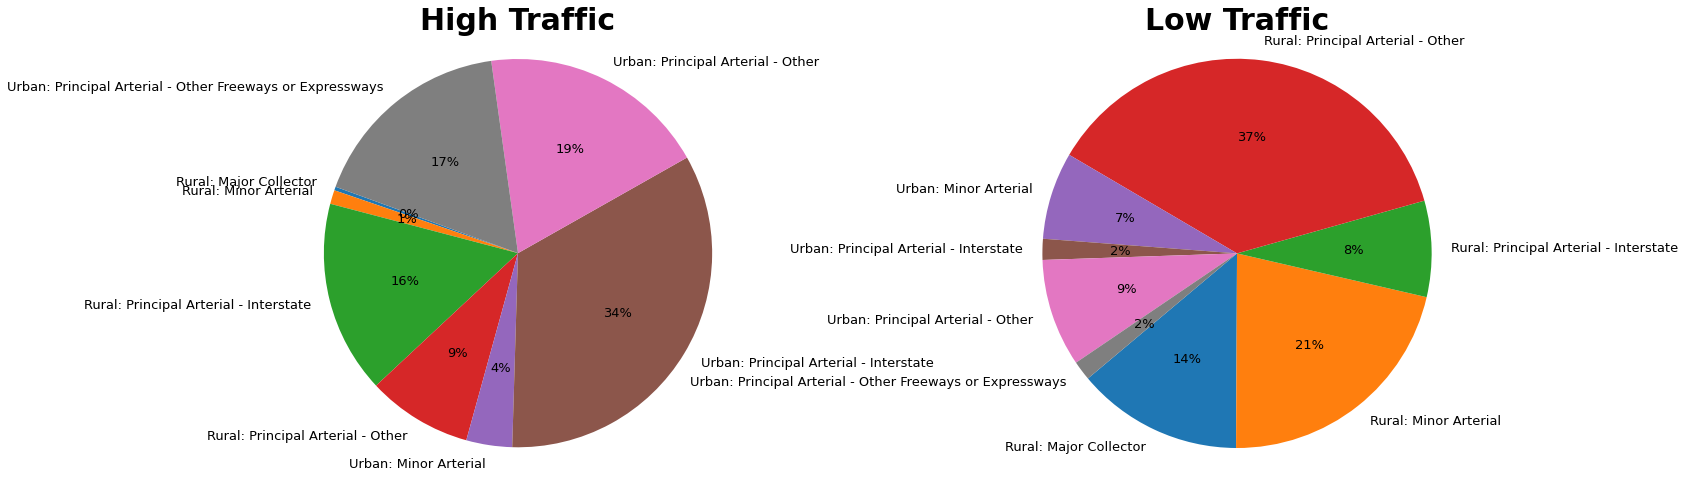

In [150]:
# Pie chart
labels = final_station_df_combined2_roadtype.functional_classification_name.to_list()
sizes1 = final_station_df_combined2_roadtype.high_traffic.to_list()
sizes2 = final_station_df_combined2_roadtype.low_traffic.to_list()
 
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_axes([0, 0, .6, .6], aspect=1)
ax1.pie(sizes1, labels=labels, autopct='%1.0f%%', startangle=160, textprops={'fontsize': 13})
ax2 = fig.add_axes([.5, .0, .6, .6], aspect=1)
ax2.pie(sizes2, labels=labels, autopct='%1.0f%%', startangle=220, textprops={'fontsize': 13})

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax2.axis('equal')  
ax1.set_title('High Traffic', weight = "bold", fontsize = "30", color = "black")
ax2.set_title('Low Traffic', weight = "bold", fontsize = "30", color = "black")
plt.show()

From the above pie charts on Functional classification name, we can make the following observations:

- High Traffic stations are predominantly monitoring Urban roads, while Low Traffic stations are predominantly monitoring Rural roads.

- High Traffic stations largely monitor Principal Arterial roads, while Low Traffic stations have a greater mix of Principal Arterial roads, Minor Arterial roads and Major Collector road.

It appears that Rural Principal Arterial roads make up a sizeable proportion of both High Traffic and Low Traffic populations.

On the other hand, it appears that Urban Principal Arterial roads tend to have higher traffic.

In [151]:
final_station_df_combined2_county = final_station_df_combined2.pivot_table(index = "fips_county_code_unique", values = ["high_traffic", "low_traffic"], aggfunc=sum).reset_index()
us_county_state = pd.merge(us_counties, us_states, left_on = 'state', right_on = 'Postal Code', how = 'inner')
final_station_df_combined2_county = pd.merge(final_station_df_combined2_county, us_county_state, left_on = 'fips_county_code_unique', right_on = 'fips', how = 'inner').drop(columns = ['fips', 'FIPS'])

high_traffic_county = final_station_df_combined2_county.sort_values(by = 'high_traffic', ascending = False).head(10)
high_traffic_county


fips_county_code_unique  high_traffic  low_traffic                name  \
74                       4013           125            2     Maricopa County   
113                      6037            45            2  Los Angeles County   
339                     15003            34            1     Honolulu County   
342                     16001            27           14          Ada County   
1221                    44007            26            3   Providence County   
27                       1073            24            1    Jefferson County   
932                     33015            23           13   Rockingham County   
1429                    53033            22            1         King County   
294                     13121            22            4       Fulton County   
1257                    48029            22            5        Bexar County   

     state           Name Postal Code  
74      AZ        Arizona          AZ  
113     CA     California          CA  
339     HI         Hawaii          HI  
342     ID          Idaho          ID  
1221    RI   Rhode Island          RI  
27      AL        Alabama          AL  
932     NH  New Hampshire          NH  
1429    WA     Washington          WA  
294     GA        Georgia          GA  
1257    TX          Texas          TX

For county, we can identify the counties containing the most high traffic stations.

From the US government of Transportation's perspective, these will be the counties we are interested in improving traffic management.

To give more context, maybe we can identify the proportion of road types/functional classification name for each of these counties.

In [152]:
county_roadtype = final_station_df_combined[['fips_county_code_unique', 'state_station', 'functional_classification_name']].drop_duplicates()
county_roadtype

fips_county_code_unique state_station  \
0                        1071      1 000002   
1                        1115      1 000004   
2                        1047      1 000006   
3                        1031      1 000008   
4                        1099      1 000009   
...                       ...           ...   
5209                     8009      8 105178   
5210                     8035      8 105548   
5211                     8001      8 105550   
5212                     8041      8 107900   
5213                     9002      9 000268   

                         functional_classification_name  
0                     Rural: Principal Arterial - Other  
1                Rural: Principal Arterial - Interstate  
2                                 Rural: Minor Arterial  
3                     Rural: Principal Arterial - Other  
4                                 Rural: Minor Arterial  
...                                                 ...  
5209                  Rural: Principal Arterial - Other  
5210  Urban: Principal Arterial - Other Freeways or ...  
5211             Urban: Principal Arterial - Interstate  
5212                  Rural: Principal Arterial - Other  
5213  Urban: Principal Arterial - Other Freeways or ...  

[5214 rows x 3 columns]

In [153]:
county_roadtype_transformed = pd.get_dummies(county_roadtype, columns = ['functional_classification_name']).groupby(['fips_county_code_unique']).sum().reset_index()
pd.merge(high_traffic_county, county_roadtype_transformed, on = 'fips_county_code_unique', how = 'inner')

fips_county_code_unique  high_traffic  low_traffic                name  \
0                     4013           125            2     Maricopa County   
1                     6037            45            2  Los Angeles County   
2                    15003            34            1     Honolulu County   
3                    16001            27           14          Ada County   
4                    44007            26            3   Providence County   
5                     1073            24            1    Jefferson County   
6                    33015            23           13   Rockingham County   
7                    53033            22            1         King County   
8                    13121            22            4       Fulton County   
9                    48029            22            5        Bexar County   

  state           Name Postal Code  \
0    AZ        Arizona          AZ   
1    CA     California          CA   
2    HI         Hawaii          HI   
3    ID          Idaho          ID   
4    RI   Rhode Island          RI   
5    AL        Alabama          AL   
6    NH  New Hampshire          NH   
7    WA     Washington          WA   
8    GA        Georgia          GA   
9    TX          Texas          TX   

   functional_classification_name_Rural: Local System  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    
5                                                  0    
6                                                  0    
7                                                  0    
8                                                  0    
9                                                  0    

   functional_classification_name_Rural: Major Collector  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       
5                                                  0       
6                                                  3       
7                                                  0       
8                                                  0       
9                                                  6       

   functional_classification_name_Rural: Minor Arterial  \
0                                                  0      
1                                                  0      
2                                                  1      
3                                                  1      
4                                                  1      
5                                                  0      
6                                                  0      
7                                                  0      
8                                                  0      
9                                                  4      

   functional_classification_name_Rural: Minor Collector  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       
5                                                  0       
6                                                  0       
7                                                  0       
8                                                  0       
9                                                  1       

   functional_classification_name_Rural: Principal Arterial - Interstate  \
0                                                  1        

Looking at the counts under each functional classification name column, it's pretty clear that the top 10 counties  largely have stations monitoring **Urban Principal Arterial Roads**.

This makes us wonder: can we identify the counties which have greater number of Rural roads and contain many high traffic stations? This is because it may be expected that Urbanised locations have high traffic, and we may be  more interested in understanding why Rural locations have high traffic as well. Moreover, given our analysis on road type above, we have shown that some Rural roads do have high traffic.


In [154]:
county_roadtype_transformed['no_of_rural_roads'] = county_roadtype_transformed.iloc[:,1:7].sum(axis=1)
county_roadtype_transformed['no_of_urban_roads'] = county_roadtype_transformed.iloc[:,7:13].sum(axis=1)
county_roadtype_transformed['has_more_rural_roads'] = np.where(county_roadtype_transformed['no_of_rural_roads'] > county_roadtype_transformed['no_of_urban_roads'], True, False)
pd.merge(final_station_df_combined2_county, county_roadtype_transformed.query('has_more_rural_roads == True'), on = 'fips_county_code_unique', how = 'inner').sort_values(by = 'high_traffic', ascending = False).head(10)

fips_county_code_unique  high_traffic  low_traffic               name  \
826                     48029            22            5       Bexar County   
636                     33013            20           21   Merrimack County   
119                     10003            17           11  New Castle County   
71                       6029            11            4        Kern County   
120                     10005            10           17      Sussex County   
1                        1003             9            3     Baldwin County   
118                     10001             8           14        Kent County   
1035                    55139             7            1   Winnebago County   
754                     41039             7            6        Lane County   
222                     16055             7            9    Kootenai County   

     state           Name Postal Code  \
826     TX          Texas          TX   
636     NH  New Hampshire          NH   
119     DE       Delaware          DE   
71      CA     California          CA   
120     DE       Delaware          DE   
1       AL        Alabama          AL   
118     DE       Delaware          DE   
1035    WI      Wisconsin          WI   
754     OR         Oregon          OR   
222     ID          Idaho          ID   

      functional_classification_name_Rural: Local System  \
826                                                   0    
636                                                   0    
119                                                   0    
71                                                    0    
120                                                   0    
1                                                     0    
118                                                   0    
1035                                                  0    
754                                                   0    
222                                                   0    

      functional_classification_name_Rural: Major Collector  \
826                                                   6       
636                                                   6       
119                                                   1       
71                                                    0       
120                                                  10       
1                                                     0       
118                                                   3       
1035                                                  0       
754                                                   1       
222                                                   1       

      functional_classification_name_Rural: Minor Arterial  ...  \
826                                                   4     ...   
636                                                   6     ...   
119                                                   1     ...   
71                                                    2     ...   
120                                                   0     ...   
1                                                     1     ...   
118                                                   1     ...   
1035                                                  0     ...   
754                                                   1     ...   
222                                                   2     ...   

      functional_classification_name_Rural: Principal Arterial - Other  \
826                                                   0                  
636                                                   6                  
119                                                  10                  
71                                                    6                  
120                                                  13                  
1                                                     6                  
118                                                  10                  

Above, we have identified high traffic stations that have a higher proportion of Rural roads.

- This gives us valuable insights on which counties we might want to look into to improve traffic management. For instance, looking at the 6th record, Baldwin County, we can see that 3/4 of its Rural road stations have high traffic. We might want to look into this county to see why this is so.
    
However, currently, it is still a bit difficult to gather insights from the dataframe. This is because even though we have the number of high and low traffic stations for a county, as well as number of rural and urban roads, we do not know exactly whether the rural roads for a county has high traffic.

- For example, for the 3rd record, New Castle County, it has 17 high traffic stations. How do we know whether these high traffic stations come from rural or urban roads?

- Even though the county has 15 rural roads, it's not fair to assume that all of them have high traffic. Therefore, our current dataframe does not tell us how many high traffic stations are actually attributed to rural roads.

To account for this, we will have to pivot our dataframe differently.

In [155]:
high_traffic_rural_df = final_station_df_combined2.pivot_table(index = "fips_county_code_unique", columns = "urban_road_type", values = ["high_traffic", "low_traffic"], aggfunc=sum).reset_index()
high_traffic_rural_df.columns = high_traffic_rural_df.columns.map('_'.join)
high_traffic_rural_df.rename(columns = {high_traffic_rural_df.columns[0]: 'fips_county_code_unique'}, inplace = True)
high_traffic_rural_df2 = pd.merge(high_traffic_rural_df, us_county_state, left_on = 'fips_county_code_unique', right_on = 'fips', how = 'inner').drop(columns = ['fips', 'FIPS'])
high_traffic_rural_df2.fillna(0, inplace = True)
high_traffic_rural_df3 = pd.merge(high_traffic_rural_df2, county_roadtype_transformed, on = 'fips_county_code_unique', how = 'inner').drop(columns = ['Postal Code'])
high_traffic_rural_df3['pct_high_traffic_rural'] = high_traffic_rural_df3['high_traffic_Rural']/(high_traffic_rural_df3['high_traffic_Rural'] + high_traffic_rural_df3['high_traffic_Urban'])
high_traffic_rural_df3['pct_rural_high_traffic'] = high_traffic_rural_df3['high_traffic_Rural']/(high_traffic_rural_df3['no_of_rural_roads'])
high_traffic_rural_df3.sort_values(by = ['high_traffic_Rural', 'pct_high_traffic_rural'], ascending = False).head(10)

fips_county_code_unique  high_traffic_Rural  high_traffic_Urban  \
194                     10005              10.000               0.000   
1                        1003               9.000               0.000   
931                     33013               9.000              11.000   
1257                    48029               9.000              13.000   
109                      6029               7.000               4.000   
932                     33015               6.000              17.000   
1538                    55139               5.000               2.000   
1487                    55025               5.000              10.000   
193                     10003               5.000              12.000   
1429                    53033               5.000              17.000   

      low_traffic_Rural  low_traffic_Urban               name state  \
194              17.000              0.000      Sussex County    DE   
1                 3.000              0.000     Baldwin County    AL   
931              18.000              3.000   Merrimack County    NH   
1257              5.000              0.000       Bexar County    TX   
109               4.000              0.000        Kern County    CA   
932               6.000              7.000  Rockingham County    NH   
1538              1.000              0.000   Winnebago County    WI   
1487              2.000              1.000        Dane County    WI   
193              10.000              1.000  New Castle County    DE   
1429              1.000              0.000        King County    WA   

               Name  functional_classification_name_Rural: Local System  \
194        Delaware                                                  0    
1           Alabama                                                  0    
931   New Hampshire                                                  0    
1257          Texas                                                  0    
109      California                                                  0    
932   New Hampshire                                                  0    
1538      Wisconsin                                                  0    
1487      Wisconsin                                                  0    
193        Delaware                                                  0    
1429     Washington                                                  0    

      functional_classification_name_Rural: Major Collector  ...  \
194                                                  10      ...   
1                                                     0      ...   
931                                                   6      ...   
1257                                                  6      ...   
109                                                   0      ...   
932                                                   3      ...   
1538                                                  0      ...   
1487                                                  0      ...   
193                                                   1      ...   
1429                                                  0      ...   

      functional_classification_name_Urban: Local System  \
194                                                   0    
1                                                     0    
931                                                   0    
1257                                                  0    
109                                                   0    
932                                                   0    
1538                                                  0    
1487                                                  0    
193                                                   0    
1429                                                  0    

      functional_classification_name_Urban: Minor Arterial  \
194                                                   0      
1                                                     0     

We have managed to split our high traffic and low traffic columns into rural and urban road types. This allows us to identify the number of high traffic rural roads per county.

Thereafter, we can sort the dataframe to get the top 10 counties containing the most high traffic rural roads.

To get deeper insight, we also defined 2 new columns:

- 'pct_high_traffic_rural': this represents % of high traffic roads that are Rural. If this is high, this means that most of the high traffic roads for a county actually come from Rural roads.

- 'pct_rural_high_traffic': this represents % of Rural roads that are high traffic. If this is high, this means that most of the Rural roads for a county have high traffic

With this information, US Department of Transportation will be better able to target counties to improve traffic planning.

Now, let's move onto exploring insights for lane type and lane-related features.

In [156]:
def assign_lanetype_name(value):
    if value == 0:
        return "Lane 0 only"
    elif value == 1:
        return "Lane 1 only"
    elif value == 5:
        return "Lane 1 and other lanes"

final_station_df_combined2_lanetype = final_station_df_combined2.pivot_table(index = "lane_type", values = ["high_traffic", "low_traffic"], aggfunc=sum).reset_index()
final_station_df_combined2_lanetype = final_station_df_combined2_lanetype.query('high_traffic > 100 or low_traffic > 100')
final_station_df_combined2_lanetype['lane_type_name'] = final_station_df_combined2_lanetype.lane_type.apply(assign_lanetype_name)

In [157]:
final_station_df_combined2_lanetype

lane_type  high_traffic  low_traffic          lane_type_name
0          0       896.000      826.000             Lane 0 only
1          1        57.000     1192.000             Lane 1 only
4          5      1552.000      573.000  Lane 1 and other lanes

For lane_type, there are 3 main categories that have at least a hundred samples: 'Lane 0 only', 'Lane 1 only' and 'Lane 1 and other lanes'

- For 'Lane 0 only', we can see the number of high traffic stations who have Lane 0 only do not differ that much from the number of low traffic stations. So the sole fact that a station is monitoring Lane 0 isn't associated with high traffic volume.

    > However, as seen in feature importance, the **number of** lane 0s that a station is monitoring is an important feature. We shall explore this later.
    
- For 'Lane 1 only', we can see that stations who have Lane 1 only tend to belong to low traffic stations. Recall that lane 1 refers to the outside (rightmost) lane. It makes sense that there won't be much traffic recorded at the station if it only has Lane 1 only. 
  
    > We have also shown this in our time series chart by lane type. You can see this in the following chart again. Lane 1 tends to have the lowest traffic volume across the months.
    
- Interestingly, for stations with both Lane 1 and other lanes, we see that 3/4 of the stations belonging to high traffic stations, while remaining 1/4 belong to low traffic. Given that Lane 1 Only stations are largely low traffic, it is likely that this shift to being classified as high traffic is most likely due to high traffic volume from other stations. 
 
    > As you can see in the following chart, other lanes (Lanes 2, 3 and Others) tend to have relatively high traffic volume.

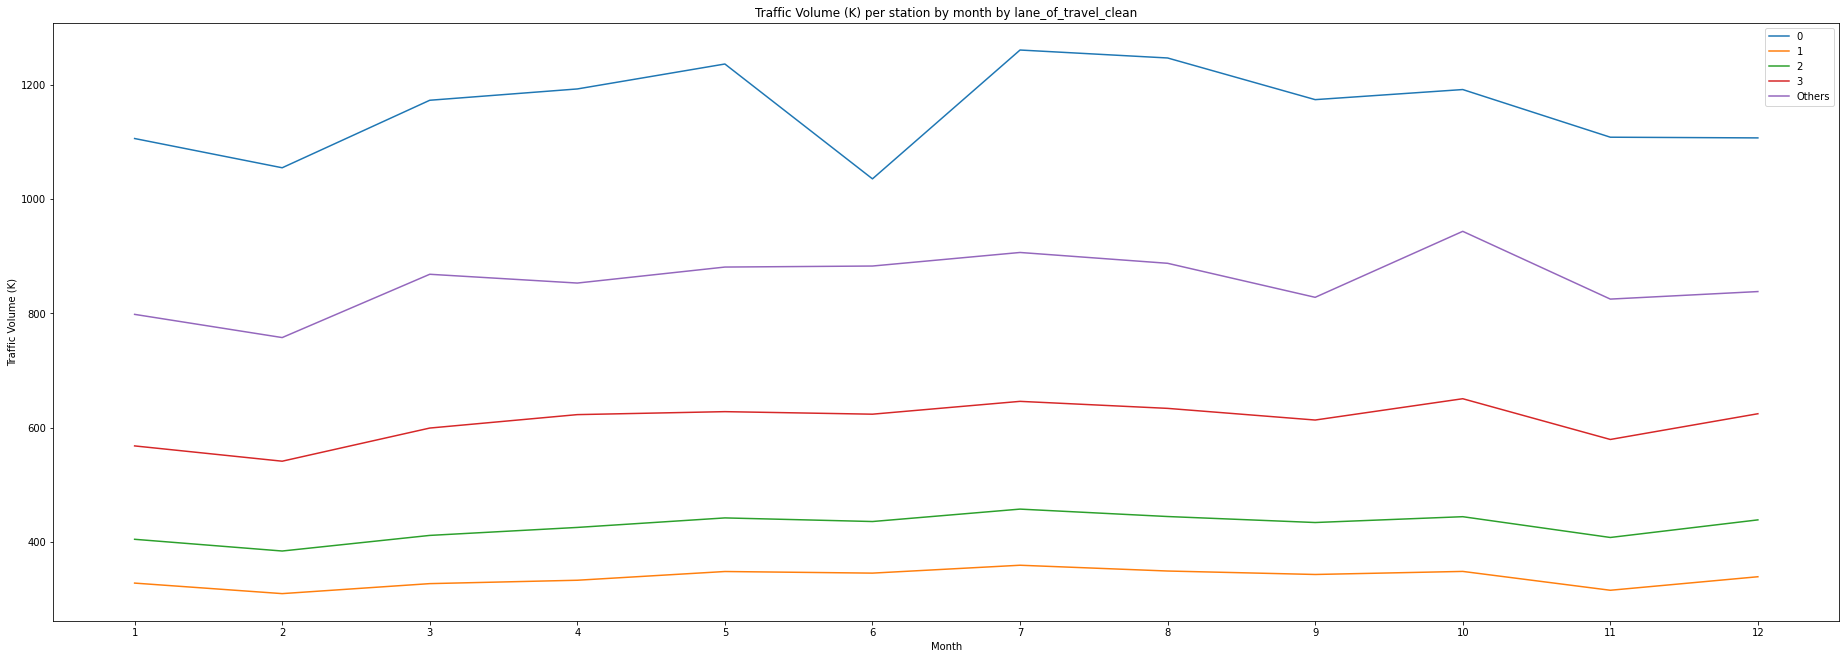

In [158]:
pivot_and_plot_monthly_traffic_vol_per_stn(traffic_volume_df_final, 'lane_of_travel_clean', fig_size = (32, 11))

We will now look at the number of lane features (number_of_lane_0, number_of_lane_2, number_of_lane_3).

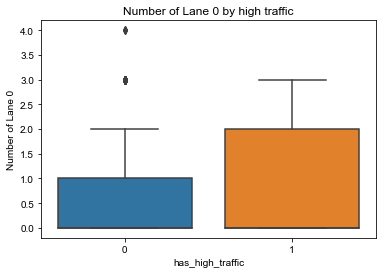

In [159]:
lane_0_df = final_station_df_combined[['number_of_lane_0', 'has_high_traffic']]
ax = sn.boxplot(x="has_high_traffic", y="number_of_lane_0", data=lane_0_df) 
sn.set(rc={'figure.figsize':(8,5)})
ax.set(ylabel='Number of Lane 0')
ax.set_title('Number of Lane 0 by high traffic')
plt.show()

Even though the median for both categories is 0, it seems that a greater number of high traffic stations have at least two lane 0s compared to low traffic stations.

In [160]:
print(final_station_df_combined.query('has_high_traffic == 1 & number_of_lane_0 > 0')['number_of_lane_0'].value_counts())
print(final_station_df_combined.query('has_high_traffic == 0 & number_of_lane_0 > 0')['number_of_lane_0'].value_counts())

2    807
1    174
3     15
Name: number_of_lane_0, dtype: int64
2    514
1    271
3     53
4      3
Name: number_of_lane_0, dtype: int64


Indeed, if we exclude stations with zero lane 0s, we can see that there is a greater number of high traffic stations with >= 2 lane 0s compared to low traffic stations.

In [161]:
print(final_station_df_combined.query('has_high_traffic == 1 & number_of_lane_2 > 0')['number_of_lane_2'].value_counts())
print(final_station_df_combined.query('has_high_traffic == 0 & number_of_lane_2 > 0')['number_of_lane_2'].value_counts())
print(final_station_df_combined.query('has_high_traffic == 1 & number_of_lane_3 > 0')['number_of_lane_3'].value_counts())
print(final_station_df_combined.query('has_high_traffic == 0 & number_of_lane_3 > 0')['number_of_lane_3'].value_counts())

2    1424
1     227
Name: number_of_lane_2, dtype: int64
2    432
1    145
Name: number_of_lane_2, dtype: int64
2    514
1    229
Name: number_of_lane_3, dtype: int64
1    29
2     8
Name: number_of_lane_3, dtype: int64


We can also observe similar patterns for Lanes 2 and 3. Therefore, we can conclude that there is a greater number of high traffic stations with at least 2 lanes combined (lane 0) or at least 2 other lanes (lane 2/3) compared to lower traffic stations.

For the US department of Transportation, it might be worth checking to see if high traffic stations with at least 2 lanes combined or at least 2 other lanes have good traffic planning, and ensure that poor traffic planning is not the reason why these stations have high traffic. 

Lastly, let's explore insights for the age of station feature.

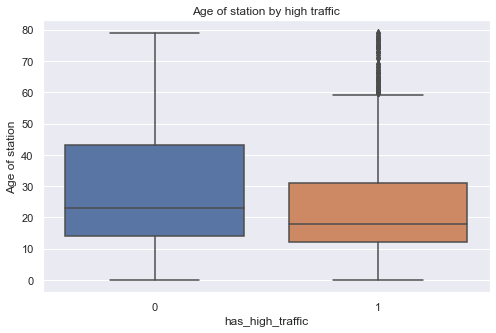

In [162]:
age_df = final_station_df_combined[['age_of_station','has_high_traffic']]
ax = sn.boxplot(x="has_high_traffic", y="age_of_station", data=age_df) 
sn.set(rc={'figure.figsize':(8,5)})
ax.set(ylabel='Age of station')
ax.set_title('Age of station by high traffic')
plt.show()

In [163]:
print(final_station_df_combined.query('has_high_traffic == 1')['age_of_station'].describe())
print(final_station_df_combined.query('has_high_traffic == 0')['age_of_station'].describe())

count   2607.000
mean      23.150
std       16.284
min        0.000
25%       12.000
50%       18.000
75%       31.000
max       79.000
Name: age_of_station, dtype: float64
count   2607.000
mean      28.718
std       20.044
min        0.000
25%       14.000
50%       23.000
75%       43.000
max       79.000
Name: age_of_station, dtype: float64


We can observe that the median age for High Traffic stations is 18, which is 5 years younger than the median age for Low Traffic stations of 23.

# Conclusion

We have come a long way and accomplished a lot. As a summary, the following is the process we took:

1. **Understanding the problem and defining the approach**:

    - Before we started the analysis, we took some time to think about what kind of patterns the US Department of Transportation is interested in and what kind of questions they hope to get insights on from the analysis.
    
    - With this in mind, we scoped the problem as a classification task and defined our general approach in solving the task.
    

2. **Preliminary exploration of features + Data cleaning**:
    - During this step, we did some exploration of the features in our 2 dataframes traffic_station_df and traffic_volume_df. In the process, we realised that several issues regarding data quality and did substantial data cleaning. This was important to ensure that we were able to join our dataframes at the right level, as well as to ensure accurate sensor and traffic volume records.
    
    - We also managed to engineer several features which we thought will be useful for the model building process.
    

3. **Exploratory Data Analysis**

    - Given that our dataframes are at station level, we managed to define an appropriate target label for modeling.
    - We also created time series and map visualizations to better explore the data, and identified several potentially important features that appear to be associated with traffic volume.
    - In addition, we did a correlation analysis between continuous variables and removed highly correlated variables, so that there aren't duplicate variables representing the same information when we do modeling. 
    
    

4. **Model Building**

    - We prepared the data for modeling by doing label encoding, as well as a train/test split.
    - After preparing the data, we first built a baseline model and fitted it to the data.
    - Thereafter, we tried to improve the baseline performance by building and fitting multiple state-of-the-art models. We then obtained the best model and performed hyperparameter tuning to further improve its performance.
    
   

5. **Analysis on Important features**

    - From the model, we obtained the most important features for predicting high traffic stations.
    
    - We then did a deep dive analysis on several of the important features. From the analysis, we discovered several key insights and made a few recommendations to US Department of Transportation for traffic planning.

The key insights and recommendations from the analysis are:

- Urban roads tend to have higher traffic volume compared to Rural roads. In addition, a large proportion of high traffic stations is monitoring Urban Principal Arterial roads. On the other hand, Rural Principal Arterial roads make up a sizeable proportion of both high traffic and low traffic populations.


- County is more significant in predicting high traffic stations compared to States. For a state, there might be a few particular counties that experience high traffic volume. Therefore, it might be good for US Department of Transportation to do traffic planning at a county level instead of state level. 


- To help the government with traffic planning on county level, we highlight a few counties with high traffic volume that the government may want to look deeper into. The top 3 counties with high traffic stations are as follows. In addition, it also appears that majority of the top counties with high traffic stations have Urban Principal Arterial roads.

  > Maricopa County in Arizona, with 125 high traffic stations and 2 low traffic stations
  
  > Los Angeles County in California, with 45 high traffic stations and 2 low traffic stations
  
  > Honolulu County in Hawaii, with 34 high traffic stations and 1 low traffic station

- The top 3 counties with high traffic Rural stations are as follows:

  > Sussex County in Delaware, with 10 high traffic Rural stations. Given that the county has 27 Rural stations, this means 37% of its Rural stations have high traffic. Given that the county has 10 high traffic stations, this means 100% of its high traffic stations are Rural stations.
  
  > Baldwin County in Alabama, with 9 high traffic Rural stations. Given that the county has 12 Rural stations, this means 75% of its Rural stations have high traffic. Given that the county has 9 high traffic stations, this means 100% of its high traffic stations are Rural. 
  
  > Merrimack County in New Hampshire, with 9 high traffic Rural stations. Given that the county has 27 Rural stations, this means 33% of its Rural stations have high traffic. Given that the county has 20 high traffic stations, this means that 45% of its high traffic stations are Rural, while the remaining 55% are Urban.

- Stations monitoring just the outside rightmost lane (lane 1) tend to have lower traffic volume. For data with lanes combined (lane 0) and other lanes, it appears that there is a greater number of high traffic stations with at least two lane 0s or at least two other lanes  compared to lower traffic stations. For the US department of Transportation, it might be worth checking to see if high traffic stations with at least two lane 0s or at least two other lanes have good traffic planning, and ensure that poor traffic planning is not the reason why these stations have high traffic.


- The median age for high traffic stations is 18, which is 5 years younger than the median age for low traffic stations of 23.